# 1. Introduction


## 1.1 About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
from keras.callbacks import EarlyStopping
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.


The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [2]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Full Value Property Tax Rate|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. At the time regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

## 1.2 Adding more readable column names

In [4]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [5]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [7]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

#### Objective 1: Use descriptive statistics and plots to describe the Boston House Prices Dataset

In the section I will use descriptive statistics and plots to provide a summary of the dataset and describe it's main features. This is of course a compenent of any data analysis project and will also aid in the identifying the steps that need to be taken in the data pre-processing stage of implementing the machine learning model that is shown later in this project.

## 2.1 Basic Information 

Pandas "info()" method can tell us the counts of datapoints in each of the features and also show if there are any missing / null values in the dataset. As we can see below, there are no null values that will have to be dealt with.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2.2 Measures of central tendancy and measures of spread / dispersion

Next we will look at the measures of central tendancy and the spread / dispersion of the data.

1. Measures of Central Tendancy attempt to give one number that best summarises the data. These include the mean/average, median and mode. 
2. Measures of spead / dispersion show the variability within the data. These include the range (max - min), standard deviation, variance, skewness, kurtosis etc.

Pandas "describe()" function quickly gives an overview of some of these key statistics for each of the features in the dataset.

In [9]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking at the means, range, and quartile values in the above tables indicates that some of the features have very unevenly distributed values. Especially the crime rate and number of black people per 1000 people. It is also worth noting that different features are operating on very different scales.

The above table does not give the mode (most commonly occuring value) for each of the features, but the Pandas "mode()" function can be used to get this.

In [10]:
df.mode()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.01501,0.0,18.1,0.0,0.538,5.713,100.0,3.4952,24.0,666.0,20.2,396.9,6.36,50.0
1,14.33370,NaN,NaN,NaN,NaN,6.127,NaN,NaN,NaN,NaN,NaN,NaN,7.79,NaN
2,NaN,NaN,NaN,NaN,NaN,6.167,NaN,NaN,NaN,NaN,NaN,NaN,8.05,NaN
3,NaN,NaN,NaN,NaN,NaN,6.229,NaN,NaN,NaN,NaN,NaN,NaN,14.10,NaN
4,NaN,NaN,NaN,NaN,NaN,6.405,NaN,NaN,NaN,NaN,NaN,NaN,18.13,NaN
5,NaN,NaN,NaN,NaN,NaN,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is worth noting that the most common Median House price is 50,000 which also happens to be the maximum value. This will need to be looked at more closely. Other features where the mode is equal to the max value include:
1. The % of houses in the area built before 1940 - The mode is 100%, but this is believable in an old city like Boston.
2. Number of accessible highways - The mode and max are 24. 
3. Number of Blacks per 1000 - the mode and max are 396.9, but for such a specific number it may only have occured twice to be counted as the mode. 
4. Percentage of industrial land - The max and mode are both 18.1. Again this will need to be looked at more closely to see if it's an error. 

In [11]:
df.median()

Crime_Rate          0.25651
%_Large_Plots       0.00000
%_Indus             9.69000
By_River            0.00000
NOX                 0.53800
Rooms               6.20850
%_Pre_1940         77.50000
Dist_to_Jobs        3.20745
Highway_Access      5.00000
Tax               330.00000
PTRatio            19.05000
Blks_per_1000     391.44000
%_Lower_Status     11.36000
Median_Val         21.20000
dtype: float64

Comparing the above median values of the features to the max and mins again gives the impression of some highly skewed / unevenly distributed data.

## 2.3 Distribution of Variables

Next we will plot the distribution of the values and see if that highlights any issue or outliers. Beginning with the target variable - Median Value of House Prices.

As can be seen from the above KDE and Boxplot, there is a cluster of outliers in the upper range of values. It may be better to remove these later.

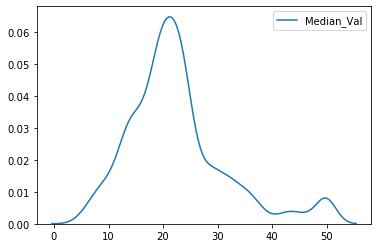

In [12]:
sns.kdeplot(df['Median_Val'])

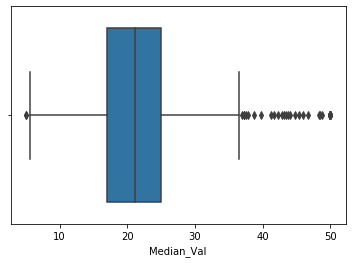

In [13]:
sns.boxplot(df['Median_Val'])

Looking at the all the features side by side, we can see that only Rooms, % of Lower Status people, Median Value are close to being normaly distributed. 

The "By_River" variable is a dummy variable with a boolean value. 

Crime rate, and the % of Large Plots have a large number of values close to zero which is understandable and doesn't set any alarm bells ringing about errors in the data.

The number of black people per 1000 tends towards the 40% mark, which again seems reasonable for a major US city and doesn't give any indication of errors in the data.

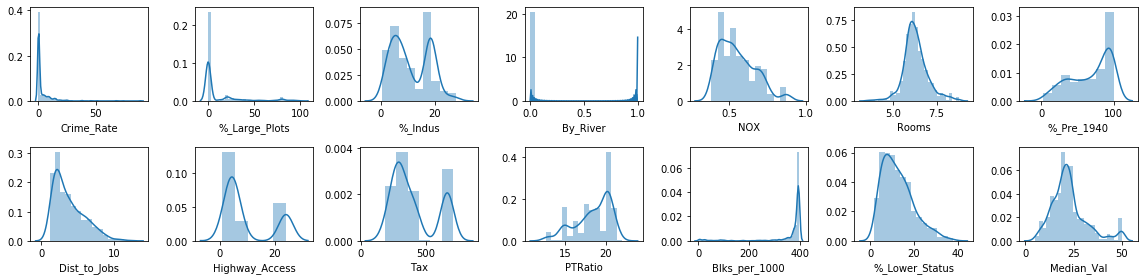

In [14]:
# distributions of the data
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.distplot(df[col[index]], ax = ax[i][j])
        index = index + 1

pyplt.tight_layout()

## 2.4 Relationships between the Variables

This next section will highlight any relationships between the data, beginning with creating a corrolation table.

In [15]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


As we can see from the above there are a number of variables that are strongly positively correlated, for example:

1. Tax and access to highways (0.91) - understandable as highways are paid for out of taxes.
2. NOX and the % of Industrial Land (0.76) - not very suprising that industrial areas would have high levels of NOX. 
2. NOX and the % of Pre 1940 houses (0.73) - possibly older houses would be burning coal.
3. Tax and the % of Industrial Land (0.71) 

There are also some strongly negatively correlated variables:

1. NOX and Distance to Jobs (-0.77) - makes sense as areas of employment are likely to be industrial and have more NOX. The further away you are, the better the air
2. % Pre 1940s houses and Distance to Jobs (-0.75) - makes sense as older areas are more likely to be located in the city centre near areas of employment. 
3. % Industrial and Distance to Jobs (-0.71) - same reasoning as point 1 above

In summary, there isn't anything unusual about the values in the correlation table that requires further investigation. 

Looking more closely at the correlation between the features and the target variable (Median House Prices), we can see that Rooms and % Lower Status are the most strongly corrolated. The rest of the variables are either moderately or weakly corrolated. This would indicate that the percentage of lower status people and the number of rooms are the best predictors of the housing prices. We will investigate this further later in this project.

In [16]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

Looking at below scatterplots of the different features vs the Median Value, Rooms and % of Lower Status People again stand out as having a relationship with it. 

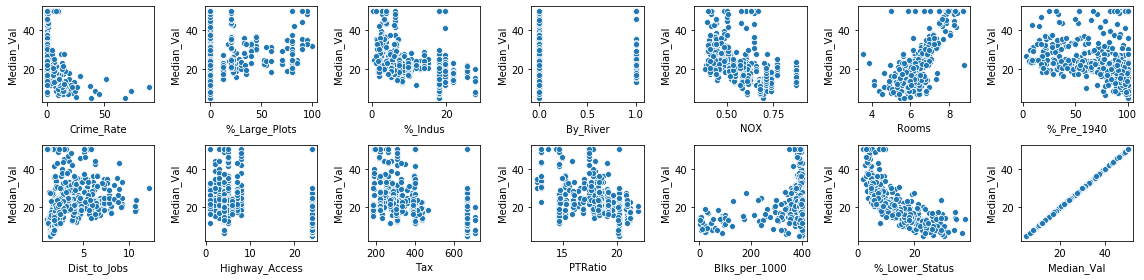

In [17]:
# scatter plots of the variables vs Median Value
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.scatterplot(df[col[index]], y="Median_Val", data=df, ax=ax[i][j])
        index = index + 1
        
        

pyplt.tight_layout()

Looking at the three most strongly corrolated values with the Median Value below, it's clear that the first two variables have a much more obvious relationship, while the Pupil Teacher ratio has much more noise.

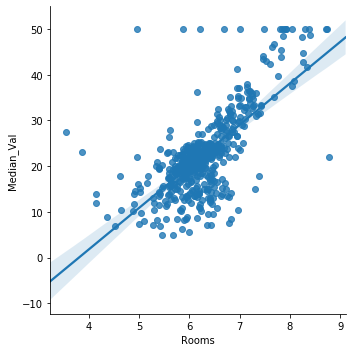

In [18]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

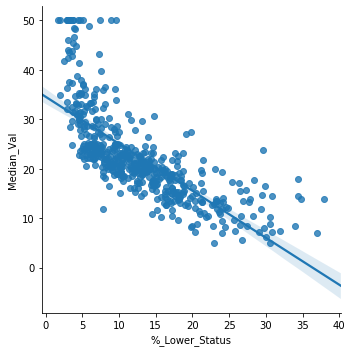

In [19]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

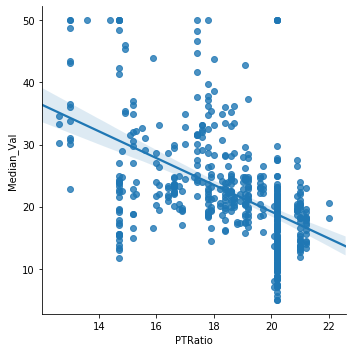

In [20]:
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

## 2.5 Conclusions from the Descriptive Analytics

My main conclusions or items of note from this section are:

1. There are no null values in the data that will need to be dealt with.
2. There are some potential errors / outliers in the Median Values with 14 values being at the max value of $50,000
3. The only other two variables with a normal distribution are also the most strongly corrolated with the Median Value

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below.

## 3.1 Looking more closely at the  "By_River" variable

As we can see from the below histogram, there are significantly more areas in our dataset that are located away from the Charles river than next to the Charles River (35).  (471)

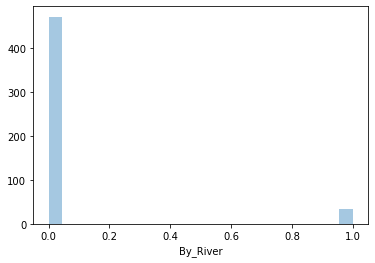

In [21]:
sns.distplot(df['By_River'], kde=False)

In [22]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [23]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

The exact count is:
* 35 next to the river 
* 471 away from the river

Looking at the distribution of the two categories we can see that the houses by the river would seems to have a higher percentage of more expensive houses. In addition, the cheapest house located away from the river.  

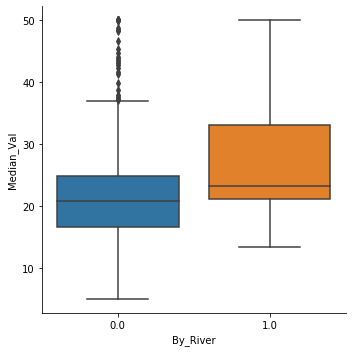

In [24]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

In [25]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]

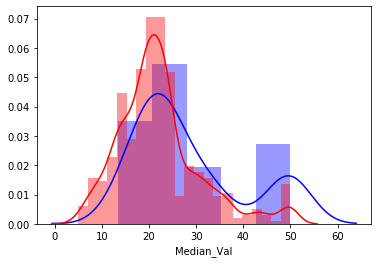

In [26]:
ax = sns.distplot(next_to_river['Median_Val'], color="blue")
ax = sns.distplot(away_from_river['Median_Val'], color="red")
pyplt.rcParams["figure.figsize"] = (20,20)

This is reflected in the descriptive statistics below with the "Next to River" values having a higher mean and mimimum value of than the areas that are located "Away from the River"

In [27]:
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [28]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

## 3.2 T-test

From the above plots and descriptive statistics it would seem that there does indeed to be some difference in the housing prices in areas along the Charles River vs those that aren't. A T-Test can be used to get futher confirmation of this (or indeed disprove this). 

### 3.2.1 Why use a T-Test?

A T-test is used to compare the means of two samples when the parameters of the population as a whole are not known. Using it will allow us to prove or reject the below Null Hypothosis and Alternative Hypothosis [14].

1. The Null Hypothesis is that there is no significant difference between houses along the Charles River and those that aren't.

2. The Alternative Hypothesis is that there is a significant difference between these two groups. 



### 3.2.2 T-Test Requirements

Before we can apply a T-Test, it is first necessary to ensure that our datasets meets the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale of 0-50|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

#### 3.2.2.1 Removing Outliers

As I mentioned earlier in this project, the "Median Val" variable has many outliers. This is clearly displayed in the Boxplot below. 

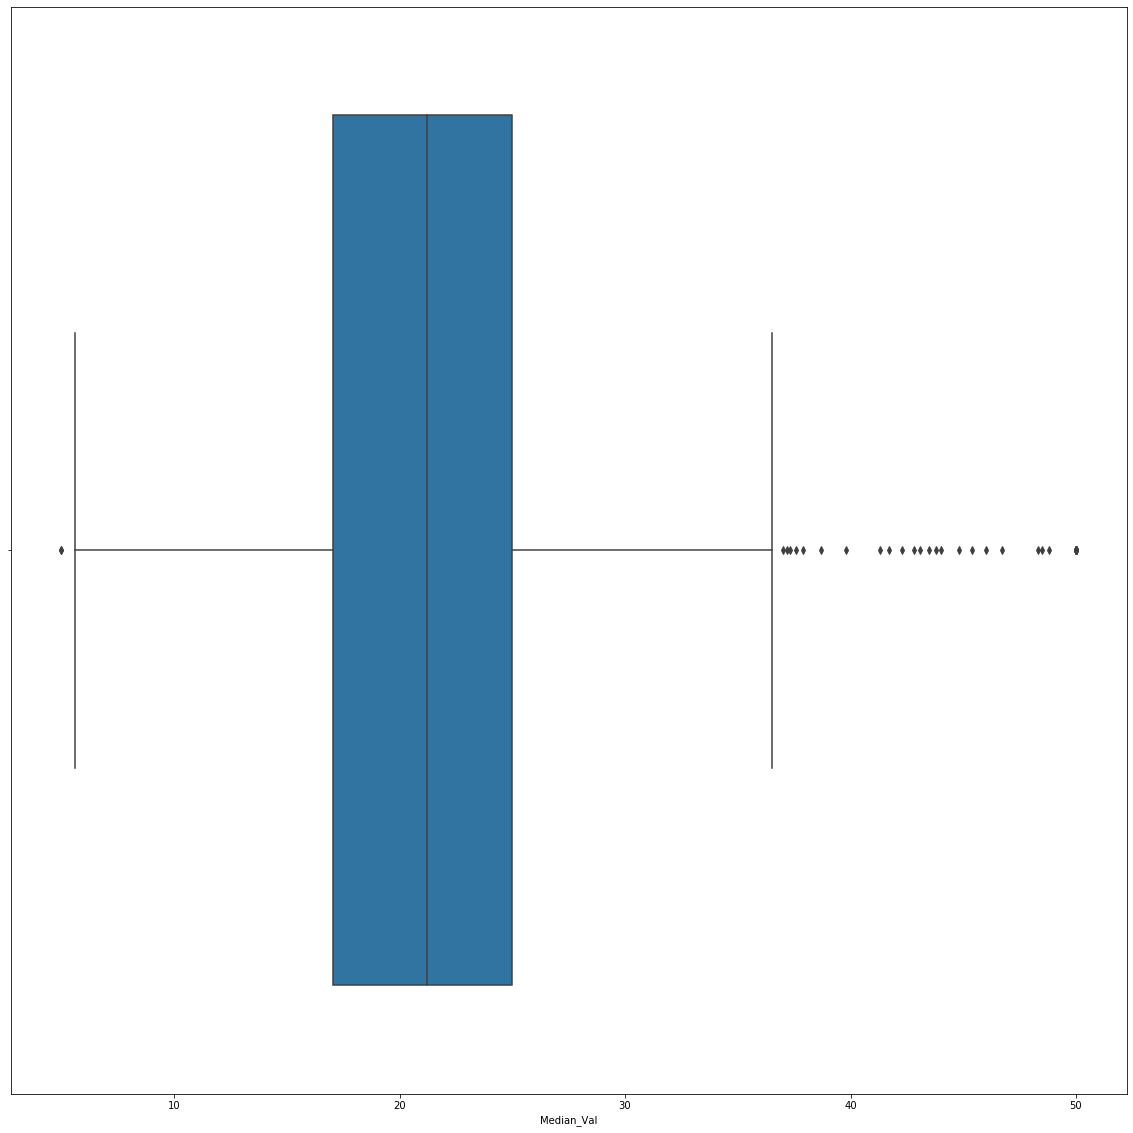

In [29]:
sns.boxplot(df['Median_Val'])

In [30]:
df["Median_Val"][df["Median_Val"] ==50].count()

16

There are also 16 areas where the median value of houses is $50,000, but nothing higher that this value. This could indicate  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers I have assigned a threshold for the Median Value, above or below which i have consider the data point to be an outlier. The most obvious way to do this is to follow the same method as the box-plot and remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [31]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [32]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [33]:
IQR = Q3 - Q1
IQR

7.975000000000001

Having calculated the interquartile range, this was then used find the upper and lower "whisker" values for the box plot which will acts as the "outlier thresholds".

In [34]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [35]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [36]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There were two data points below the lower threshold.

In [37]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [38]:
above["Median_Val"].count()

38

There were 38 datapoints that were higher that the upper threshold. Using these thresholds I created a dataset of data that was within these two thresholds called "no_outliers".

In [39]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Comparing the two groups with the outliers removed shows that the median values of the two groups was now much closer together, but the range of values in the "Away from River" group was still much wider.

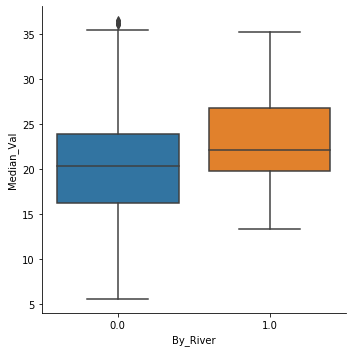

In [40]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

#### 3.2.2.2 Determining if the Dependant Variable is Approxmately Normally Distributed in Each Group.

In order to test this I created two new groups from the "no_outliers" dataset:
1. Next to River
2. Away from River

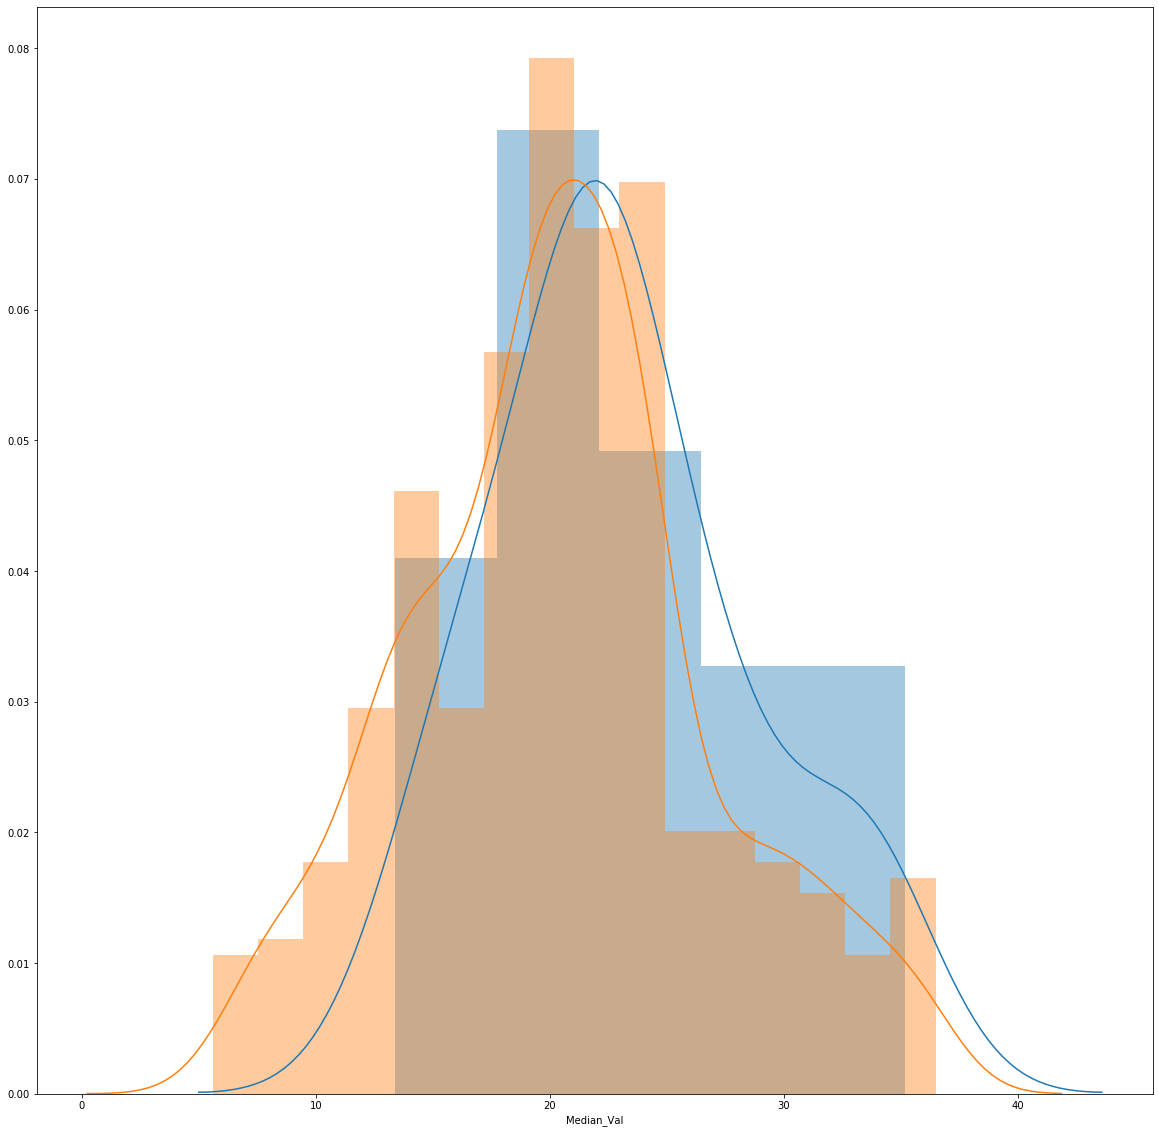

In [41]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" group it can be observed that both are much closer to appearing to be normally distributed than the original dataset with the outliers included.

I performed a further test using Scipys "normaltest" method to confirm this.

In [42]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). I can therefore be said the no significant departure from normality was found [15].

#### 3.2.2.3 Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid t-test it is necessary to check if both samples have similar variances. Levenes test can be used to do this. It tests the null hypothosis that variances are equal. 

In [43]:
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The P-value is greater than the threshold of 0.05 so it can be said that there is no signifcant difference in the variances of both groups.

In [44]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [45]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


#### 3.2.2.4 Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have been removed.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### 3.3 T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [46]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current section was to test if there is a significant difference in the Median Value of House Prices between the house prices in areas by or not by the Charles River in Boston.

In [47]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [48]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference < 0 p value =,0.9819
5,Difference > 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test showed a P-value of 0.0362. This is lower than the 0.05 threshold giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

It can therefore be concluded that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predicting House Prices using a Neural Network


#### Objective 3: Predict the median house price based on the other variables in the dataset using neural network

## 4.0 Overview

In this section, I have built a model for a neural network that has gone through several iterations in order to determine which configuration of the model was delivering the best predictions.

Before creating the model I did several preprocessing steps to prepare the training and test data. Following that I created a "baseline" model to measure subsequent iterations performance against.

I then outlined the different elements of the model that could be adjusted and tested to see if they could improve performance. 

Following that I created and tested several different versions of the model, changing one key element each time e.g. number of epochs, layers size etc with an attempt at further tuning using Principal Component Analysis and Feature Selection.

Finally, I selected the best performing model from the various iteration as my final model.

**NOTE:** *I have commented out the code for several of the model testing functions below. Some of these can take quiet some time to run, so I felt it was safest to comment them out in case someone was to use the "Rull All" option.*

## 4.1 Pre-Processing

Before proceeding with the creation of the model it is necessary to ensure the data is as error free as possible and in the right format for feeding into the model.

In this project I took the following pre-processing steps:

1. Dealt with any Null values
2. Dealt with Categorical Variables
3. Standardised the Data

It should be noted that record with an outlier in the Median Value variable have already been removed during the preperation for the T-Test above. 


### 4.1.1 Null Values

First I checked to see if the cleansed dataset contained any Null values. If there were Null values, the row containing the value will be need to be removed or the value would have needed to be replaced.

In [49]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

However, as can be seen from the table above, there were no null values.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located next to or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore, it was not necessary to have to do any encoding or processing of this variable.

In [50]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise  the Data

Standardisation means transforming all values in a dataset so that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, looking at the below shows that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [51]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before the data was scaled it needed to be split into the independent and dependent variables for the model.

#### 4.1.3.1 Shuffling the Data

Before splitting the data it was also suffled. This is more important in classification tasks where the dataset is sorted by class, but it is also good to ensure all of the data from a particular area didn't end up in just the training dataset and not the test dataset. Following that, the data was split into the input and taget variables for the model.

In [52]:
no_outliers = shuffle(no_outliers)

In [53]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

#### 4.1.3.2 Splitting into Test and Training Sets

The data then needed to be split into the testing and training sets. For this project I have used a 80:20 train:test split. 

Sklearn's model selection tool for can be used to perform the split. 

In [54]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [55]:
x_train.iloc[0] # snapshot of a single row of data

Crime_Rate          0.25915
%_Large_Plots       0.00000
%_Indus            21.89000
By_River            0.00000
NOX                 0.62400
Rooms               5.69300
%_Pre_1940         96.00000
Dist_to_Jobs        1.78830
Highway_Access      4.00000
Tax               437.00000
PTRatio            21.20000
Blks_per_1000     392.11000
%_Lower_Status     17.19000
Name: 127, dtype: float64

#### 4.1.3.3 Standarising the Data

Once the data was split into testing and training sets was standardised / scaled.


In [56]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [57]:
x_train.iloc[0]

Crime_Rate       -0.383673
%_Large_Plots    -0.484726
%_Indus           1.593092
By_River         -0.262613
NOX               0.596714
Rooms            -0.821208
%_Pre_1940        0.970699
Dist_to_Jobs     -0.978601
Highway_Access   -0.607263
Tax               0.210822
PTRatio           1.266993
Blks_per_1000     0.397966
%_Lower_Status    0.565021
Name: 0, dtype: float64

In [58]:
x_train.describe().round()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
count,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
mean,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.0,-0.0,-1.0,-0.0,-1.0,-4.0,-2.0,-1.0,-1.0,-1.0,-3.0,-4.0,-2.0
25%,-0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
75%,-0.0,0.0,1.0,-0.0,1.0,1.0,1.0,1.0,-0.0,1.0,1.0,0.0,1.0
max,10.0,4.0,2.0,4.0,3.0,4.0,1.0,3.0,2.0,2.0,2.0,0.0,4.0


##  4.2 Baseline prediction test

After the data processing was complete, it was possible to proceed with the creation of a baseline model. For the baseline model I added:
1. An input layer with a number of units equal to the number of input features in the dataset.
2. An output layer with one unit as the model is only supposed to produce one output value.
3. 100 epochs - number chosen at random
4. A batch size of 5 - number chosen at random

In [59]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [60]:
m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 1s 4ms/step - loss: 472.0388
Epoch 2/100
372/372 [==============================] - 0s 504us/step - loss: 437.1269
Epoch 3/100
372/372 [==============================] - 0s 403us/step - loss: 396.9968
Epoch 4/100
372/372 [==============================] - 0s 374us/step - loss: 345.7431
Epoch 5/100
372/372 [==============================] - 0s 379us/step - loss: 284.0872
Epoch 6/100
372/372 [==============================] - 0s 372us/step - loss: 220.0319
Epoch 7/100
372/372 [==============================] - 0s 394us/step - loss: 163.5533
Epoch 8/100
372/372 [==============================] - 0s 386us/step - loss: 119.8578
Epoch 9/100
372/372 [==============================] - 0s 388us/step - loss: 89.5277
Epoch 10/100
372/372 [==============================] - 0s 391us/step - loss: 69.0708
Epoch 11/100
372/372 [==============================] - 0s 372us/step - loss: 54.6598
Epoch 12/100
372/372 [==============================] - 0

372/372 [==============================] - 0s 354us/step - loss: 5.8845
Epoch 97/100
372/372 [==============================] - 0s 357us/step - loss: 5.9182
Epoch 98/100
372/372 [==============================] - 0s 335us/step - loss: 5.8288
Epoch 99/100
372/372 [==============================] - 0s 362us/step - loss: 5.8296
Epoch 100/100
372/372 [==============================] - 0s 365us/step - loss: 5.7907


In [61]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[30.771067, 16.153131, 14.778919, 16.965858, 21.526583, 28.547174,
        15.199216, 24.094734, 16.532328, 21.40668 , 24.123915, 23.583866,
        21.114603, 17.879272, 24.73106 , 21.376472, 28.069738, 27.435171,
        24.86872 , 19.462584,  9.401781, 22.119442, 23.003822, 28.858223,
        30.919884, 19.801313, 16.665413, 16.851322, 20.406351, 23.73238 ,
        18.497038, 16.199324, 25.476107, 11.615366, 17.792418,  9.394792,
        27.830265, 19.319618, 20.371883,  9.570566, 15.227782, 20.959446,
        17.954617, 23.373262, 19.856827, 19.42977 , 22.764801, 16.55338 ,
        27.08323 , 15.744199, 30.868763, 21.186356, 17.995869, 15.692352,
        18.576666, 21.157145, 18.768492, 13.193385, 19.813673, 18.741415,
        20.411037, 10.433045, 13.527252, 14.44716 , 14.769137, 32.10624 ,
        20.944916, 23.369396, 18.421392, 16.391312, 26.114584, 13.620273,
        13.326334, 23.767763, 20.383345, 19.136261, 11.436048, 26.053265,
        17.362072, 19.320883, 10.64593

In [62]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([33.4, 15.2, 14.1, 13.1, 21.4, 27.9, 14.9, 22.3, 15.1, 21.2, 24.7,
       22.2, 20.1, 17.5, 24.7, 19.1, 30.1, 30.5, 22.5, 19.5,  6.3, 20.2,
       20.6, 29.9, 34.7, 22.2, 19. , 12.5, 19.1, 21.7, 22.7, 14.2, 23.7,
       13.2, 16.8,  8.5, 28. , 21.5, 21.7, 13.8, 13.6, 19.9, 19.4, 21.6,
       18.8, 23.1, 20.6, 23.2, 32.5, 13.6, 33.1, 20.6, 13.8, 16.7, 17.8,
       19. , 20.9, 15. , 20.4, 19.4, 22.6, 10.4, 13.4, 18.6, 13.3, 35.1,
       19.4, 18.5, 18.9, 17.4, 26.2, 17.6,  7.2, 22.2, 19.3, 19.8,  8.8,
       24.4, 16.1, 22. , 10.5, 15.6, 23.9, 20.4,  7.5, 10.2, 36.4, 19.6,
       32.9, 17.4, 19.6, 11.3, 23.8, 26.6], dtype=float32)

In [63]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,30.771067,33.400002,8.543529
1,16.153131,15.200000,5.900600
2,14.778919,14.100000,4.593833
3,16.965858,13.100000,22.786102
4,21.526583,21.400000,0.588032
...,...,...,...
89,21.281733,17.400000,18.239740
90,19.630119,19.600000,0.153432
91,12.840207,11.300000,11.995188
92,23.504816,23.799999,1.255841


In [64]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

10.593571

In [65]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 400us/step


5.993504077830213

The initial baseline test I performed showed an average of a 10.7% diffence between the real and predicted test values and an MSE value of 7.3. As can be seen in the following iteration, I found it very difficult to improve this value significantly. 

## 4.3 Factors Considered When Creating Subsequent Models

Before progressing further with project and creating new models, I looked at the main elements that make up a model, what role they perform, and the potential effects of changing them.

### 4.3.1 Model Selection

I used the Sequential Model for all models in ths project. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary for the purposes of this project.

### 4.3.2 Density

This is the layer type. In this type all nodes/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). I saw no reason to change this for the different models in this project.

### 4.3.3 Number of Layers

For the baseline I have added 1 input later and 1 output layer. This is the absolute minimum number a model can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models, having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I have added additional layers in later iterations of the model.

### 4.3.4 Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this projects dataset there are 13 input variables with 1 output required. This is what was entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively, reducing accuracy. 

There are some rules of thumb such for layer sizes such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

However, these fail to take account of size of the training dataset and other considerations [3]. 

I have experimented with different layer sizes in the models below.



### 4.3.5 Activation Functions

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This was obviously not suitable for this project's dataset, but there were several others that were worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scaled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers activated by the ReLU function. 
* ReLu should only be used in hidden layers and not the output layer.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left as the default linear function.




### 4.3.6 Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error", which is what was used in the various models in this project [6].

### 4.3.7 Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I did not think there would be much value in using other optimizers.

### 4.3.8 Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In the Baseline Model I set the model to perform 100 epochs. I tried larger numbers of epochs in later iterations. 

### 4.3.9 Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore, each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 

I have tried several different batch sized in the models below.


## 4.4 Model Tuning

In this section I tested changes to the model based on some of the possible improvements discussed above:

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I did not be change:
1. Activation functions
2. Loss function
3. Optimizer

I attempted to test this in an empirical fashion, changing one parameter at a time and testing to see if it resulted in any improvements vs the Baseline.

### 4.4.1 Batch Sizes

In this section I tested various batch sizes while keeping all other model parameters the same as the Baseline Model.

###### Test 1-  Increasing Batch Size to 32


In [66]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=32)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch1 = m.evaluate(x_test, y_test)

In [67]:
# result_batch1

**Result:** Rejected - MSE increased to 26.539871296984085

###### Test 2 - Batch Size to 16

In [68]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=16)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch2 = m.evaluate(x_test, y_test)

In [69]:
# result_batch2

**Result:** Rejected - MSE increased to 12.633492307460054

###### Test 3 - Batch Size to 4

In [70]:
# Test 3
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=4)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch3 = m.evaluate(x_test, y_test)

In [71]:
# result_batch3

**Result:** Possible candidate. MSE of 7.892184135761667 is closer to the baseline

###### Test 4 - Batch Size to 2

In [72]:
# Test 4
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=2)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch4 = m.evaluate(x_test, y_test)

In [73]:
# result_batch4

**Result:** Possible candidate. MSE of 8.877476955981965 is slightly worse than the baseline.

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [74]:
# function to test batch sizes with 10 test and average of results

# def batchsize_test(tests, b_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")

#         m.fit(x_train, y_train, epochs=100, batch_size=b_size)

#         batch_test1_prediction = m.predict(x_test).T

#         MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_batch3 = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_batch3)
#     avg_result = sum(resultslist) / tests
#     return avg_result

#print(batchsize_test(5, 2))

In [75]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seemed to perform marginally better. Given that this project  dealt with a relatively small dataset memory wasn't an issue so  there was no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

In this section I tested different epoch sizes.

###### Test 1 - 500 Epochs

In [76]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

history = m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 1ms/step - loss: 463.5636
Epoch 2/500
372/372 [==============================] - 0s 886us/step - loss: 397.8615
Epoch 3/500
372/372 [==============================] - 0s 872us/step - loss: 321.6869
Epoch 4/500
372/372 [==============================] - 0s 863us/step - loss: 241.7733
Epoch 5/500
372/372 [==============================] - 0s 901us/step - loss: 160.1404
Epoch 6/500
372/372 [==============================] - 0s 854us/step - loss: 86.0224
Epoch 7/500
372/372 [==============================] - 0s 839us/step - loss: 41.6934
Epoch 8/500
372/372 [==============================] - 0s 852us/step - loss: 24.4880
Epoch 9/500
372/372 [==============================] - 0s 865us/step - loss: 19.5046
Epoch 10/500
372/372 [==============================] - 0s 843us/step - loss: 17.7884
Epoch 11/500
372/372 [==============================] - 0s 879us/step - loss: 16.6857
Epoch 12/500
372/372 [==============================] - 0s 8

372/372 [==============================] - 0s 881us/step - loss: 5.2563
Epoch 98/500
372/372 [==============================] - 0s 831us/step - loss: 5.2303
Epoch 99/500
372/372 [==============================] - 0s 823us/step - loss: 5.2050
Epoch 100/500
372/372 [==============================] - 0s 791us/step - loss: 5.1961
Epoch 101/500
372/372 [==============================] - 0s 812us/step - loss: 5.2360
Epoch 102/500
372/372 [==============================] - 0s 820us/step - loss: 5.2631
Epoch 103/500
372/372 [==============================] - 0s 827us/step - loss: 5.1683
Epoch 104/500
372/372 [==============================] - 0s 863us/step - loss: 5.2346
Epoch 105/500
372/372 [==============================] - 0s 760us/step - loss: 5.1778
Epoch 106/500
372/372 [==============================] - 0s 774us/step - loss: 5.1737
Epoch 107/500
372/372 [==============================] - 0s 780us/step - loss: 5.1702
Epoch 108/500
372/372 [==============================] - 0s 806us/step

372/372 [==============================] - 0s 827us/step - loss: 4.7069
Epoch 193/500
372/372 [==============================] - 0s 875us/step - loss: 4.7223
Epoch 194/500
372/372 [==============================] - 0s 833us/step - loss: 4.6563
Epoch 195/500
372/372 [==============================] - 0s 830us/step - loss: 4.6549
Epoch 196/500
372/372 [==============================] - 0s 813us/step - loss: 4.6701
Epoch 197/500
372/372 [==============================] - 0s 780us/step - loss: 4.6023
Epoch 198/500
372/372 [==============================] - 0s 857us/step - loss: 4.6834
Epoch 199/500
372/372 [==============================] - 0s 817us/step - loss: 4.6567
Epoch 200/500
372/372 [==============================] - 0s 880us/step - loss: 4.6050
Epoch 201/500
372/372 [==============================] - 0s 836us/step - loss: 4.6449
Epoch 202/500
372/372 [==============================] - 0s 853us/step - loss: 4.6737
Epoch 203/500
372/372 [==============================] - 0s 870us/st

372/372 [==============================] - 0s 929us/step - loss: 4.4475
Epoch 288/500
372/372 [==============================] - 0s 932us/step - loss: 4.3722
Epoch 289/500
372/372 [==============================] - 0s 928us/step - loss: 4.3552
Epoch 290/500
372/372 [==============================] - 0s 935us/step - loss: 4.4007
Epoch 291/500
372/372 [==============================] - 0s 900us/step - loss: 4.3754
Epoch 292/500
372/372 [==============================] - 0s 930us/step - loss: 4.3378
Epoch 293/500
372/372 [==============================] - 0s 879us/step - loss: 4.3537
Epoch 294/500
372/372 [==============================] - 0s 930us/step - loss: 4.3264
Epoch 295/500
372/372 [==============================] - 0s 934us/step - loss: 4.3332
Epoch 296/500
372/372 [==============================] - 0s 894us/step - loss: 4.3864
Epoch 297/500
372/372 [==============================] - 0s 932us/step - loss: 4.3340
Epoch 298/500
372/372 [==============================] - 0s 897us/st

372/372 [==============================] - 0s 844us/step - loss: 4.1494
Epoch 383/500
372/372 [==============================] - 0s 864us/step - loss: 4.1727
Epoch 384/500
372/372 [==============================] - 0s 805us/step - loss: 4.1994
Epoch 385/500
372/372 [==============================] - 0s 821us/step - loss: 4.2370
Epoch 386/500
372/372 [==============================] - 0s 821us/step - loss: 4.2061
Epoch 387/500
372/372 [==============================] - 0s 840us/step - loss: 4.2019
Epoch 388/500
372/372 [==============================] - 0s 838us/step - loss: 4.2297
Epoch 389/500
372/372 [==============================] - 0s 860us/step - loss: 4.1618
Epoch 390/500
372/372 [==============================] - 0s 821us/step - loss: 4.2019
Epoch 391/500
372/372 [==============================] - 0s 814us/step - loss: 4.2027
Epoch 392/500
372/372 [==============================] - 0s 850us/step - loss: 4.1621
Epoch 393/500
372/372 [==============================] - 0s 818us/st

372/372 [==============================] - 0s 851us/step - loss: 4.0757
Epoch 478/500
372/372 [==============================] - 0s 801us/step - loss: 4.0794
Epoch 479/500
372/372 [==============================] - 0s 876us/step - loss: 4.0453
Epoch 480/500
372/372 [==============================] - 0s 806us/step - loss: 4.0982
Epoch 481/500
372/372 [==============================] - 0s 821us/step - loss: 4.0616
Epoch 482/500
372/372 [==============================] - 0s 810us/step - loss: 4.0057
Epoch 483/500
372/372 [==============================] - 0s 814us/step - loss: 4.0042
Epoch 484/500
372/372 [==============================] - 0s 819us/step - loss: 4.1108
Epoch 485/500
372/372 [==============================] - 0s 847us/step - loss: 4.0300
Epoch 486/500
372/372 [==============================] - 0s 819us/step - loss: 4.0824
Epoch 487/500
372/372 [==============================] - 0s 850us/step - loss: 4.0407
Epoch 488/500
372/372 [==============================] - 0s 862us/st

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [77]:
print(history.history.keys())

dict_keys(['loss'])


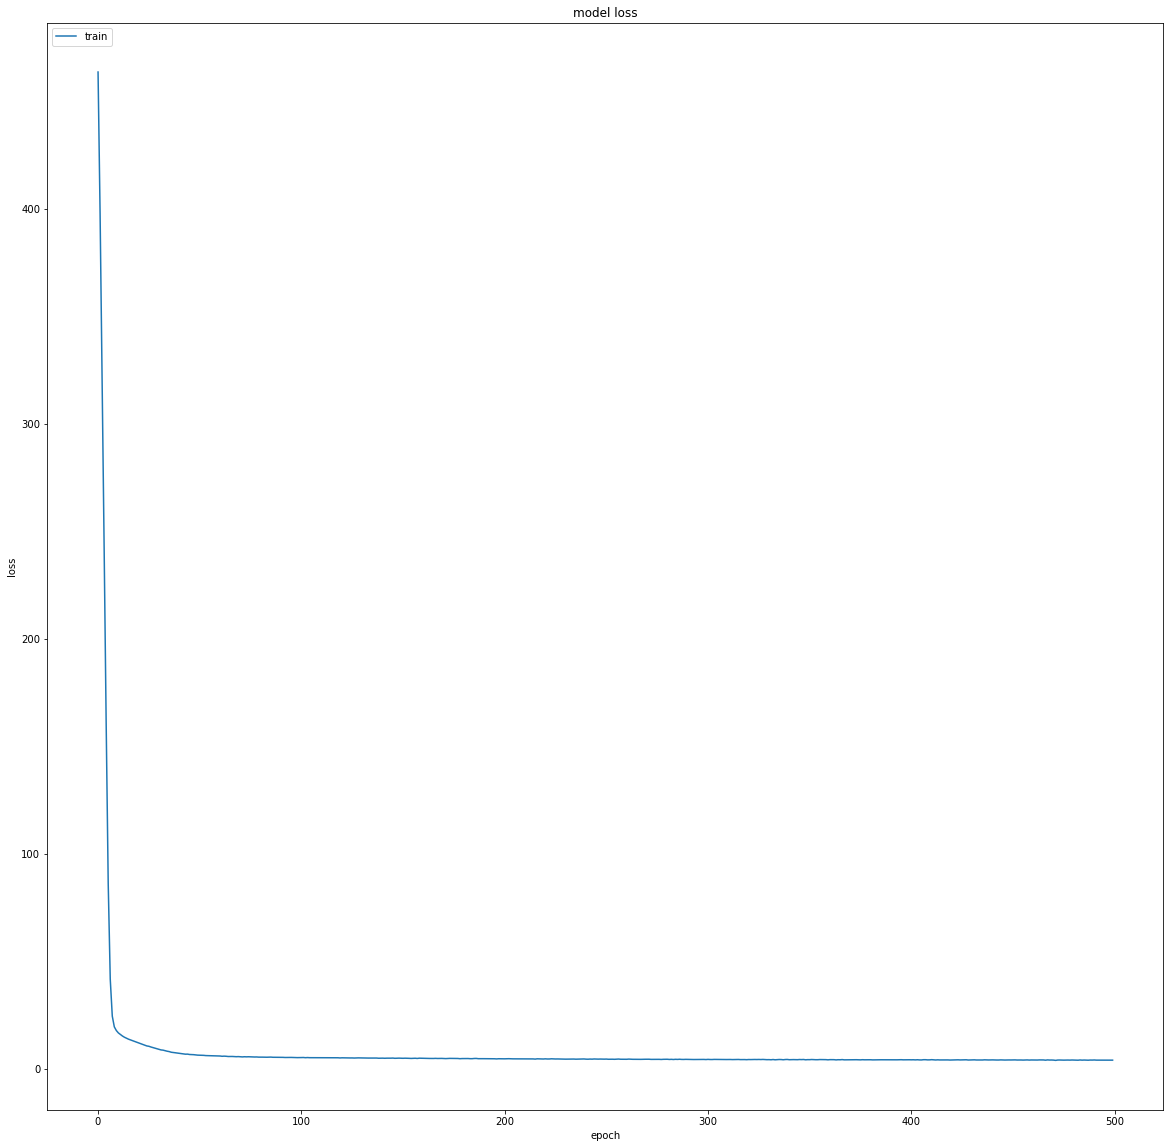

In [78]:
pyplt.plot(history.history['loss'])
pyplt.title('model loss')
pyplt.ylabel('loss')
pyplt.xlabel('epoch')
pyplt.legend(['train', 'test'], loc='upper left')
pyplt.show()

In [79]:
result_epochv1

5.679925218541571

**Result:** The MSE for this model was 5.679925218541571, but I had varying results with several test.

From looking at the above results there definitely seemed to be deminishing returns or even signs of overfitting after the 300 epoch mark. I therefore decided to introduce early stopping in the remaining models.

###### Test 2 - 500 Epochs with Early Stopping

In [80]:
# Test 2
# 
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

# ES_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_ES = m.evaluate(x_test, y_test)

In [81]:
# result_ES

**Result:** MSE was 8.051695742505663

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most tests. This was even when the test was set to only stop when the loss value had not descreased for the previous 10 epochs.

I decided that 250-300 epochs was enough for any further tests.

### 4.4.3 Number of Units per Layer

In this section I adjusted the number of units in the single hidden layer. I used some of the heuristics discussed early as guidelines for selecting the layer sizes.

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. I tested this configuration first.

In [82]:
14*(2/3)


9.333333333333332

In [83]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize9_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN9 = m.evaluate(x_test, y_test)

In [84]:
# result_layerN9

**Result:** The MSE was 8.323373987319622

###### Test 2 - Twice the number of Inputs

The next heuristics I tested was that the number of units in the hidden layer should not be over twice the number of inputs.

In [85]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize26_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN26 = m.evaluate(x_test, y_test)

In [86]:
# result_layerN26

**Result:** This gave MSE results comparable to the Baseline model: 7.729459732136828

###### Test 3 - Quadrupel the Input

In [87]:
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize52_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN52 = m.evaluate(x_test, y_test)

In [88]:
# result_layerN52

**Result:** This configuration gave the best MSE score so far at 5.981633308085989

#### 4.4.3.1 Commentary

Results for diffent layer sizes again appeared to be inconclusive. I therefore decided to test the different model configurations several times and get the average of the results.

In [89]:
# function to test different batch sizes
# def unitsize_test(tests, batchsize, unit_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         #unit_prediction = m.predict(x_test).T

#         #MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_units = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_units)
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [90]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

**Result:** was 8.461502002147919

In [91]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

**Result:** was 7.670181302821382

In [92]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

**Result:** was 8.024365358149751

In [93]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

**Result:** was 7.862417864292226

In [94]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

**Result:** was 8.067290689590129

In [95]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

**Result:** was 7.880062107329673

The best result seemed to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seemed to consistently perform better. I therefore decided to change to a batch size of 4 in the subsequent tests.

### 4.4.4 Number of Layers

Next I tested adding additional layers of neurons to the model. Again, I tested each model configuration 5 times and got the average of the MSE results.

In [96]:
# function to test different amounts of layers
# def layer_count_test(tests, batchsize, unit_size1, unit_size2):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(unit_size2, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         result_units = m.evaluate(x_test, y_test)
        
#         counter += 1
        
#         resultslist.append(result_units)
#         #print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [97]:
# layers_test_results = [
#     layer_count_test(5, 4, 13, 13),
#     layer_count_test(5, 4, 26, 26),
#     layer_count_test(5, 4, 26, 13),
#     layer_count_test(5, 4, 52, 26),
#     layer_count_test(5, 4, 64, 13),
# ]

In [98]:
# labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [99]:
# layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [100]:
# layerresults_df

|Test|Results|
|:------------------------|:---------|
|13 -> 13|7.155485|
|26 -> 26|7.930675|
|26 -> 13|7.613028|
|52 -> 26|8.173526|
|64 -> 13|7.872510|

**Result:** The best results were achieved using two layers of 13 units giving an MSE of 7.155485.

##### Test with 3 Layers 

In [101]:
def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(unit_size3, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
   
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [102]:
three_layers_test_results = [
    three_layer_count_test(5, 4, 13, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 9),
    three_layer_count_test(5, 4, 52, 26, 13),
    three_layer_count_test(5, 4, 64, 26, 13)
]

Epoch 1/300
372/372 [==============================] - 0s 800us/step - loss: 464.9867
Epoch 2/300
372/372 [==============================] - 0s 344us/step - loss: 321.8038
Epoch 3/300
372/372 [==============================] - 0s 351us/step - loss: 68.1668
Epoch 4/300
372/372 [==============================] - 0s 330us/step - loss: 32.4697
Epoch 5/300
372/372 [==============================] - 0s 334us/step - loss: 25.2524
Epoch 6/300
372/372 [==============================] - 0s 331us/step - loss: 21.2691
Epoch 7/300
372/372 [==============================] - 0s 326us/step - loss: 18.6941
Epoch 8/300
372/372 [==============================] - 0s 346us/step - loss: 16.9333
Epoch 9/300
372/372 [==============================] - 0s 334us/step - loss: 15.4475
Epoch 10/300
372/372 [==============================] - 0s 339us/step - loss: 13.9955
Epoch 11/300
372/372 [==============================] - 0s 327us/step - loss: 12.5947
Epoch 12/300
372/372 [==============================] - 0s 31

372/372 [==============================] - 0s 360us/step - loss: 4.4871
Epoch 98/300
372/372 [==============================] - 0s 377us/step - loss: 4.4297
Epoch 99/300
372/372 [==============================] - 0s 336us/step - loss: 4.5508
Epoch 100/300
372/372 [==============================] - 0s 380us/step - loss: 4.4999
Epoch 101/300
372/372 [==============================] - 0s 375us/step - loss: 4.3622
Epoch 102/300
372/372 [==============================] - 0s 370us/step - loss: 4.4661
Epoch 103/300
372/372 [==============================] - 0s 347us/step - loss: 4.4096
Epoch 104/300
372/372 [==============================] - 0s 356us/step - loss: 4.3314
Epoch 105/300
372/372 [==============================] - 0s 362us/step - loss: 4.2897
Epoch 106/300
372/372 [==============================] - 0s 334us/step - loss: 4.3626
Epoch 107/300
372/372 [==============================] - 0s 377us/step - loss: 4.3673
Epoch 108/300
372/372 [==============================] - 0s 353us/step

372/372 [==============================] - 0s 496us/step - loss: 3.4704
Epoch 193/300
372/372 [==============================] - 0s 504us/step - loss: 3.3556
Epoch 194/300
372/372 [==============================] - 0s 505us/step - loss: 3.3429
Epoch 195/300
372/372 [==============================] - 0s 498us/step - loss: 3.3414
Epoch 196/300
372/372 [==============================] - 0s 490us/step - loss: 3.3440
Epoch 197/300
372/372 [==============================] - 0s 504us/step - loss: 3.3954
Epoch 198/300
372/372 [==============================] - 0s 513us/step - loss: 3.2795
Epoch 199/300
372/372 [==============================] - 0s 492us/step - loss: 3.2167
Epoch 200/300
372/372 [==============================] - 0s 513us/step - loss: 3.3033
Epoch 201/300
372/372 [==============================] - 0s 499us/step - loss: 3.3209
Epoch 202/300
372/372 [==============================] - 0s 508us/step - loss: 3.3014
Epoch 203/300
372/372 [==============================] - 0s 507us/st

372/372 [==============================] - 0s 553us/step - loss: 10.1084
Epoch 14/300
372/372 [==============================] - 0s 522us/step - loss: 9.4637
Epoch 15/300
372/372 [==============================] - 0s 538us/step - loss: 9.3382
Epoch 16/300
372/372 [==============================] - 0s 529us/step - loss: 9.1489
Epoch 17/300
372/372 [==============================] - 0s 541us/step - loss: 8.5934
Epoch 18/300
372/372 [==============================] - 0s 496us/step - loss: 8.4088
Epoch 19/300
372/372 [==============================] - 0s 507us/step - loss: 8.1374
Epoch 20/300
372/372 [==============================] - 0s 521us/step - loss: 8.0456
Epoch 21/300
372/372 [==============================] - 0s 513us/step - loss: 7.7427
Epoch 22/300
372/372 [==============================] - 0s 482us/step - loss: 7.5442
Epoch 23/300
372/372 [==============================] - 0s 513us/step - loss: 7.4475
Epoch 24/300
372/372 [==============================] - 0s 487us/step - loss:

372/372 [==============================] - 0s 514us/step - loss: 4.4142
Epoch 110/300
372/372 [==============================] - 0s 529us/step - loss: 4.1599
Epoch 111/300
372/372 [==============================] - 0s 532us/step - loss: 4.2522
Epoch 112/300
372/372 [==============================] - 0s 572us/step - loss: 4.2086
Epoch 113/300
372/372 [==============================] - 0s 539us/step - loss: 4.0133
Epoch 114/300
372/372 [==============================] - 0s 535us/step - loss: 4.1847
Epoch 115/300
372/372 [==============================] - 0s 541us/step - loss: 3.9286
Epoch 116/300
372/372 [==============================] - 0s 545us/step - loss: 4.0649
Epoch 117/300
372/372 [==============================] - 0s 537us/step - loss: 3.9710
Epoch 118/300
372/372 [==============================] - 0s 513us/step - loss: 4.2274
Epoch 119/300
372/372 [==============================] - 0s 530us/step - loss: 4.0135
Epoch 120/300
372/372 [==============================] - 0s 500us/st

372/372 [==============================] - 0s 569us/step - loss: 3.3555
Epoch 205/300
372/372 [==============================] - 0s 554us/step - loss: 3.2670
Epoch 206/300
372/372 [==============================] - 0s 582us/step - loss: 3.3067
Epoch 207/300
372/372 [==============================] - 0s 582us/step - loss: 3.2598
Epoch 208/300
372/372 [==============================] - 0s 525us/step - loss: 3.4235
Epoch 209/300
372/372 [==============================] - 0s 529us/step - loss: 3.3266
Epoch 210/300
372/372 [==============================] - 0s 563us/step - loss: 3.1560
Epoch 211/300
372/372 [==============================] - 0s 566us/step - loss: 3.3247
Epoch 212/300
372/372 [==============================] - 0s 540us/step - loss: 3.3292
Epoch 213/300
372/372 [==============================] - 0s 534us/step - loss: 3.2642
Epoch 214/300
372/372 [==============================] - 0s 544us/step - loss: 3.2293
Epoch 215/300
372/372 [==============================] - 0s 574us/st

372/372 [==============================] - 0s 535us/step - loss: 4.1702
Epoch 80/300
372/372 [==============================] - 0s 567us/step - loss: 4.2807
Epoch 81/300
372/372 [==============================] - 0s 563us/step - loss: 4.2497
Epoch 82/300
372/372 [==============================] - 0s 535us/step - loss: 4.0818
Epoch 83/300
372/372 [==============================] - 0s 545us/step - loss: 4.0339
Epoch 84/300
372/372 [==============================] - 0s 530us/step - loss: 4.0296
Epoch 85/300
372/372 [==============================] - 0s 543us/step - loss: 3.9616
Epoch 86/300
372/372 [==============================] - 0s 545us/step - loss: 4.0073
Epoch 87/300
372/372 [==============================] - 0s 541us/step - loss: 3.9813
Epoch 88/300
372/372 [==============================] - 0s 541us/step - loss: 4.0542
Epoch 89/300
372/372 [==============================] - 0s 533us/step - loss: 4.0570
Epoch 90/300
372/372 [==============================] - 0s 536us/step - loss: 

372/372 [==============================] - 0s 330us/step - loss: 2.6917
Epoch 175/300
372/372 [==============================] - 0s 345us/step - loss: 2.6341
Epoch 176/300
372/372 [==============================] - 0s 344us/step - loss: 2.6248
Epoch 00176: early stopping
94/94 [==============================] - 0s 174us/step
Epoch 1/300
372/372 [==============================] - 0s 705us/step - loss: 469.7002
Epoch 2/300
372/372 [==============================] - 0s 348us/step - loss: 379.9272
Epoch 3/300
372/372 [==============================] - 0s 343us/step - loss: 127.4506
Epoch 4/300
372/372 [==============================] - 0s 316us/step - loss: 35.7554
Epoch 5/300
372/372 [==============================] - 0s 334us/step - loss: 22.2303
Epoch 6/300
372/372 [==============================] - 0s 333us/step - loss: 17.2638
Epoch 7/300
372/372 [==============================] - 0s 368us/step - loss: 14.8129
Epoch 8/300
372/372 [==============================] - 0s 324us/step - loss

372/372 [==============================] - 0s 306us/step - loss: 4.9077
Epoch 94/300
372/372 [==============================] - 0s 339us/step - loss: 4.9730
Epoch 95/300
372/372 [==============================] - 0s 324us/step - loss: 4.9671
Epoch 96/300
372/372 [==============================] - 0s 348us/step - loss: 4.8927
Epoch 97/300
372/372 [==============================] - 0s 358us/step - loss: 4.8540
Epoch 98/300
372/372 [==============================] - 0s 339us/step - loss: 4.9031
Epoch 99/300
372/372 [==============================] - 0s 355us/step - loss: 4.7924
Epoch 100/300
372/372 [==============================] - 0s 331us/step - loss: 4.8529
Epoch 101/300
372/372 [==============================] - 0s 326us/step - loss: 4.8856
Epoch 102/300
372/372 [==============================] - 0s 348us/step - loss: 4.7780
Epoch 103/300
372/372 [==============================] - 0s 338us/step - loss: 4.7484
Epoch 104/300
372/372 [==============================] - 0s 328us/step - l

372/372 [==============================] - 0s 344us/step - loss: 3.7205
Epoch 189/300
372/372 [==============================] - 0s 328us/step - loss: 3.9193
Epoch 190/300
372/372 [==============================] - 0s 343us/step - loss: 3.7761
Epoch 191/300
372/372 [==============================] - 0s 350us/step - loss: 3.8025
Epoch 192/300
372/372 [==============================] - 0s 341us/step - loss: 3.8363
Epoch 193/300
372/372 [==============================] - 0s 329us/step - loss: 3.7185
Epoch 194/300
372/372 [==============================] - 0s 376us/step - loss: 3.7113
Epoch 195/300
372/372 [==============================] - 0s 325us/step - loss: 3.7415
Epoch 196/300
372/372 [==============================] - 0s 342us/step - loss: 3.6119
Epoch 197/300
372/372 [==============================] - 0s 351us/step - loss: 3.6132
Epoch 198/300
372/372 [==============================] - 0s 343us/step - loss: 3.6965
Epoch 199/300
372/372 [==============================] - 0s 352us/st

372/372 [==============================] - 0s 367us/step - loss: 15.4645
Epoch 10/300
372/372 [==============================] - 0s 363us/step - loss: 14.3960
Epoch 11/300
372/372 [==============================] - 0s 364us/step - loss: 13.2860
Epoch 12/300
372/372 [==============================] - 0s 381us/step - loss: 12.2176
Epoch 13/300
372/372 [==============================] - 0s 361us/step - loss: 11.3150
Epoch 14/300
372/372 [==============================] - 0s 343us/step - loss: 10.8582
Epoch 15/300
372/372 [==============================] - 0s 332us/step - loss: 10.2901
Epoch 16/300
372/372 [==============================] - 0s 381us/step - loss: 9.7602
Epoch 17/300
372/372 [==============================] - 0s 355us/step - loss: 9.4486
Epoch 18/300
372/372 [==============================] - 0s 357us/step - loss: 9.1589
Epoch 19/300
372/372 [==============================] - 0s 337us/step - loss: 8.9396
Epoch 20/300
372/372 [==============================] - 0s 375us/step -

372/372 [==============================] - 0s 347us/step - loss: 4.3103
Epoch 106/300
372/372 [==============================] - 0s 379us/step - loss: 4.2025
Epoch 107/300
372/372 [==============================] - 0s 369us/step - loss: 4.3294
Epoch 108/300
372/372 [==============================] - 0s 349us/step - loss: 4.2626
Epoch 109/300
372/372 [==============================] - 0s 355us/step - loss: 4.2394
Epoch 110/300
372/372 [==============================] - 0s 355us/step - loss: 4.1736
Epoch 111/300
372/372 [==============================] - 0s 337us/step - loss: 4.3659
Epoch 112/300
372/372 [==============================] - 0s 357us/step - loss: 4.1839
Epoch 113/300
372/372 [==============================] - 0s 381us/step - loss: 4.2511
Epoch 114/300
372/372 [==============================] - 0s 340us/step - loss: 4.3372
Epoch 115/300
372/372 [==============================] - 0s 326us/step - loss: 4.1150
Epoch 116/300
372/372 [==============================] - 0s 358us/st

372/372 [==============================] - 0s 342us/step - loss: 4.7354
Epoch 39/300
372/372 [==============================] - 0s 371us/step - loss: 4.5750
Epoch 40/300
372/372 [==============================] - 0s 315us/step - loss: 4.7632
Epoch 41/300
372/372 [==============================] - 0s 342us/step - loss: 4.5039
Epoch 42/300
372/372 [==============================] - 0s 341us/step - loss: 4.5659
Epoch 43/300
372/372 [==============================] - 0s 323us/step - loss: 4.5403
Epoch 44/300
372/372 [==============================] - 0s 340us/step - loss: 4.4700
Epoch 45/300
372/372 [==============================] - 0s 361us/step - loss: 4.6122
Epoch 46/300
372/372 [==============================] - 0s 331us/step - loss: 4.5901
Epoch 47/300
372/372 [==============================] - 0s 348us/step - loss: 4.5140
Epoch 48/300
372/372 [==============================] - 0s 342us/step - loss: 4.2743
Epoch 49/300
372/372 [==============================] - 0s 333us/step - loss: 

372/372 [==============================] - 0s 349us/step - loss: 2.7593
Epoch 134/300
372/372 [==============================] - 0s 349us/step - loss: 3.0022
Epoch 135/300
372/372 [==============================] - 0s 344us/step - loss: 2.6755
Epoch 136/300
372/372 [==============================] - 0s 345us/step - loss: 2.5782
Epoch 137/300
372/372 [==============================] - 0s 357us/step - loss: 2.8702
Epoch 138/300
372/372 [==============================] - 0s 333us/step - loss: 2.6640
Epoch 139/300
372/372 [==============================] - 0s 339us/step - loss: 2.7348
Epoch 140/300
372/372 [==============================] - 0s 328us/step - loss: 2.9544
Epoch 141/300
372/372 [==============================] - 0s 334us/step - loss: 2.8752
Epoch 142/300
372/372 [==============================] - 0s 333us/step - loss: 2.7299
Epoch 143/300
372/372 [==============================] - 0s 335us/step - loss: 2.7483
Epoch 144/300
372/372 [==============================] - 0s 356us/st

372/372 [==============================] - 0s 537us/step - loss: 9.1592
Epoch 12/300
372/372 [==============================] - 0s 503us/step - loss: 8.8411
Epoch 13/300
372/372 [==============================] - 0s 505us/step - loss: 8.2986
Epoch 14/300
372/372 [==============================] - 0s 526us/step - loss: 8.1517
Epoch 15/300
372/372 [==============================] - 0s 539us/step - loss: 7.8208
Epoch 16/300
372/372 [==============================] - 0s 527us/step - loss: 7.4167
Epoch 17/300
372/372 [==============================] - 0s 514us/step - loss: 7.2695
Epoch 18/300
372/372 [==============================] - 0s 532us/step - loss: 6.9809
Epoch 19/300
372/372 [==============================] - 0s 518us/step - loss: 6.7261
Epoch 20/300
372/372 [==============================] - 0s 518us/step - loss: 6.6133
Epoch 21/300
372/372 [==============================] - 0s 540us/step - loss: 6.4708
Epoch 22/300
372/372 [==============================] - 0s 530us/step - loss: 

372/372 [==============================] - 0s 537us/step - loss: 3.2854
Epoch 108/300
372/372 [==============================] - 0s 538us/step - loss: 3.2151
Epoch 109/300
372/372 [==============================] - 0s 539us/step - loss: 3.2901
Epoch 110/300
372/372 [==============================] - 0s 534us/step - loss: 3.2295
Epoch 111/300
372/372 [==============================] - 0s 505us/step - loss: 3.0962
Epoch 112/300
372/372 [==============================] - 0s 512us/step - loss: 3.1445
Epoch 113/300
372/372 [==============================] - 0s 494us/step - loss: 3.1369
Epoch 114/300
372/372 [==============================] - 0s 523us/step - loss: 3.0985
Epoch 115/300
372/372 [==============================] - 0s 531us/step - loss: 3.0687
Epoch 116/300
372/372 [==============================] - 0s 531us/step - loss: 3.1302
Epoch 117/300
372/372 [==============================] - 0s 516us/step - loss: 3.0897
Epoch 118/300
372/372 [==============================] - 0s 509us/st

372/372 [==============================] - 0s 504us/step - loss: 3.6200
Epoch 73/300
372/372 [==============================] - 0s 514us/step - loss: 3.5627
Epoch 74/300
372/372 [==============================] - 0s 522us/step - loss: 3.6465
Epoch 75/300
372/372 [==============================] - 0s 511us/step - loss: 3.4679
Epoch 76/300
372/372 [==============================] - 0s 515us/step - loss: 3.3332
Epoch 77/300
372/372 [==============================] - 0s 516us/step - loss: 3.5010
Epoch 78/300
372/372 [==============================] - 0s 507us/step - loss: 3.4191
Epoch 79/300
372/372 [==============================] - 0s 494us/step - loss: 3.4540
Epoch 80/300
372/372 [==============================] - 0s 510us/step - loss: 3.3176
Epoch 81/300
372/372 [==============================] - 0s 510us/step - loss: 3.2471
Epoch 82/300
372/372 [==============================] - 0s 510us/step - loss: 3.2035
Epoch 83/300
372/372 [==============================] - 0s 516us/step - loss: 

372/372 [==============================] - 0s 531us/step - loss: 2.1399
Epoch 168/300
372/372 [==============================] - 0s 519us/step - loss: 2.0884
Epoch 169/300
372/372 [==============================] - 0s 535us/step - loss: 2.1194
Epoch 170/300
372/372 [==============================] - 0s 534us/step - loss: 1.9761
Epoch 171/300
372/372 [==============================] - 0s 530us/step - loss: 2.1340
Epoch 172/300
372/372 [==============================] - 0s 510us/step - loss: 2.1132
Epoch 173/300
372/372 [==============================] - 0s 523us/step - loss: 2.1730
Epoch 174/300
372/372 [==============================] - 0s 499us/step - loss: 2.0968
Epoch 175/300
372/372 [==============================] - 0s 515us/step - loss: 2.0792
Epoch 176/300
372/372 [==============================] - 0s 516us/step - loss: 2.0860
Epoch 177/300
372/372 [==============================] - 0s 519us/step - loss: 2.0271
Epoch 178/300
372/372 [==============================] - 0s 505us/st

372/372 [==============================] - 0s 346us/step - loss: 5.7277
Epoch 29/300
372/372 [==============================] - 0s 392us/step - loss: 5.5654
Epoch 30/300
372/372 [==============================] - 0s 366us/step - loss: 5.6122
Epoch 31/300
372/372 [==============================] - 0s 383us/step - loss: 5.5721
Epoch 32/300
372/372 [==============================] - 0s 328us/step - loss: 5.2178
Epoch 33/300
372/372 [==============================] - 0s 349us/step - loss: 5.1677
Epoch 34/300
372/372 [==============================] - 0s 369us/step - loss: 5.1926
Epoch 35/300
372/372 [==============================] - 0s 365us/step - loss: 5.1009
Epoch 36/300
372/372 [==============================] - 0s 371us/step - loss: 5.0748
Epoch 37/300
372/372 [==============================] - 0s 416us/step - loss: 5.1061
Epoch 38/300
372/372 [==============================] - 0s 332us/step - loss: 5.1261
Epoch 39/300
372/372 [==============================] - 0s 351us/step - loss: 

372/372 [==============================] - 0s 314us/step - loss: 2.7562
Epoch 125/300
372/372 [==============================] - 0s 343us/step - loss: 2.7871
Epoch 126/300
372/372 [==============================] - 0s 327us/step - loss: 2.7742
Epoch 127/300
372/372 [==============================] - 0s 345us/step - loss: 2.8114
Epoch 128/300
372/372 [==============================] - 0s 311us/step - loss: 2.7301
Epoch 129/300
372/372 [==============================] - 0s 335us/step - loss: 2.8407
Epoch 130/300
372/372 [==============================] - 0s 325us/step - loss: 2.9471
Epoch 131/300
372/372 [==============================] - 0s 338us/step - loss: 2.7449
Epoch 132/300
372/372 [==============================] - 0s 330us/step - loss: 2.8332
Epoch 133/300
372/372 [==============================] - 0s 343us/step - loss: 2.7726
Epoch 134/300
372/372 [==============================] - 0s 314us/step - loss: 2.7107
Epoch 135/300
372/372 [==============================] - 0s 330us/st

372/372 [==============================] - 0s 486us/step - loss: 1.9812
Epoch 220/300
372/372 [==============================] - 0s 470us/step - loss: 1.9558
Epoch 221/300
372/372 [==============================] - 0s 467us/step - loss: 1.9422
Epoch 222/300
372/372 [==============================] - 0s 403us/step - loss: 2.0280
Epoch 223/300
372/372 [==============================] - 0s 523us/step - loss: 1.9131
Epoch 224/300
372/372 [==============================] - 0s 604us/step - loss: 2.0585
Epoch 225/300
372/372 [==============================] - 0s 442us/step - loss: 1.9375
Epoch 226/300
372/372 [==============================] - 0s 347us/step - loss: 1.9869
Epoch 227/300
372/372 [==============================] - 0s 345us/step - loss: 1.8778
Epoch 228/300
372/372 [==============================] - 0s 363us/step - loss: 1.9197
Epoch 229/300
372/372 [==============================] - 0s 357us/step - loss: 2.0976
Epoch 230/300
372/372 [==============================] - 0s 332us/st

372/372 [==============================] - 0s 333us/step - loss: 6.9266
Epoch 14/300
372/372 [==============================] - 0s 333us/step - loss: 6.7510
Epoch 15/300
372/372 [==============================] - 0s 342us/step - loss: 6.5372
Epoch 16/300
372/372 [==============================] - 0s 346us/step - loss: 6.4816
Epoch 17/300
372/372 [==============================] - 0s 340us/step - loss: 6.3382
Epoch 18/300
372/372 [==============================] - 0s 349us/step - loss: 6.0933
Epoch 19/300
372/372 [==============================] - 0s 333us/step - loss: 6.1726
Epoch 20/300
372/372 [==============================] - 0s 336us/step - loss: 6.0000
Epoch 21/300
372/372 [==============================] - ETA: 0s - loss: 5.019 - 0s 316us/step - loss: 5.9067
Epoch 22/300
372/372 [==============================] - 0s 338us/step - loss: 5.6464
Epoch 23/300
372/372 [==============================] - 0s 353us/step - loss: 5.7325
Epoch 24/300
372/372 [==============================] 

372/372 [==============================] - 0s 344us/step - loss: 2.9335
Epoch 110/300
372/372 [==============================] - 0s 349us/step - loss: 2.8395
Epoch 111/300
372/372 [==============================] - 0s 342us/step - loss: 2.8350
Epoch 112/300
372/372 [==============================] - 0s 337us/step - loss: 2.9151
Epoch 113/300
372/372 [==============================] - 0s 352us/step - loss: 2.7548
Epoch 114/300
372/372 [==============================] - 0s 354us/step - loss: 2.7724
Epoch 115/300
372/372 [==============================] - 0s 373us/step - loss: 2.7983
Epoch 116/300
372/372 [==============================] - 0s 356us/step - loss: 2.7538
Epoch 00116: early stopping
94/94 [==============================] - 0s 147us/step
Epoch 1/300
372/372 [==============================] - 0s 919us/step - loss: 409.0223
Epoch 2/300
372/372 [==============================] - 0s 379us/step - loss: 123.3099
Epoch 3/300
372/372 [==============================] - 0s 358us/step - 

372/372 [==============================] - 0s 321us/step - loss: 3.6953
Epoch 89/300
372/372 [==============================] - 0s 343us/step - loss: 3.6720
Epoch 90/300
372/372 [==============================] - 0s 356us/step - loss: 3.4848
Epoch 91/300
372/372 [==============================] - 0s 317us/step - loss: 3.5995
Epoch 92/300
372/372 [==============================] - 0s 321us/step - loss: 3.5672
Epoch 93/300
372/372 [==============================] - 0s 333us/step - loss: 3.6021
Epoch 94/300
372/372 [==============================] - 0s 329us/step - loss: 3.5966
Epoch 95/300
372/372 [==============================] - 0s 320us/step - loss: 3.5959
Epoch 96/300
372/372 [==============================] - 0s 327us/step - loss: 3.6528
Epoch 97/300
372/372 [==============================] - 0s 347us/step - loss: 3.4601
Epoch 98/300
372/372 [==============================] - 0s 355us/step - loss: 3.3675
Epoch 99/300
372/372 [==============================] - 0s 330us/step - loss: 

372/372 [==============================] - 0s 477us/step - loss: 13.3460
Epoch 7/300
372/372 [==============================] - 0s 463us/step - loss: 11.9554
Epoch 8/300
372/372 [==============================] - 0s 515us/step - loss: 10.9516
Epoch 9/300
372/372 [==============================] - 0s 516us/step - loss: 10.3585
Epoch 10/300
372/372 [==============================] - 0s 487us/step - loss: 9.6121
Epoch 11/300
372/372 [==============================] - 0s 528us/step - loss: 9.1806
Epoch 12/300
372/372 [==============================] - 0s 465us/step - loss: 8.7084
Epoch 13/300
372/372 [==============================] - 0s 519us/step - loss: 8.2058
Epoch 14/300
372/372 [==============================] - 0s 498us/step - loss: 7.9236
Epoch 15/300
372/372 [==============================] - 0s 494us/step - loss: 7.6331
Epoch 16/300
372/372 [==============================] - 0s 451us/step - loss: 7.3282
Epoch 17/300
372/372 [==============================] - 0s 495us/step - loss:

372/372 [==============================] - 0s 478us/step - loss: 3.1335
Epoch 103/300
372/372 [==============================] - 0s 491us/step - loss: 3.0556
Epoch 104/300
372/372 [==============================] - 0s 504us/step - loss: 3.1280
Epoch 105/300
372/372 [==============================] - 0s 461us/step - loss: 3.1091
Epoch 106/300
372/372 [==============================] - 0s 514us/step - loss: 3.1066
Epoch 107/300
372/372 [==============================] - 0s 510us/step - loss: 2.9572
Epoch 108/300
372/372 [==============================] - 0s 483us/step - loss: 3.0520
Epoch 109/300
372/372 [==============================] - 0s 513us/step - loss: 2.9600
Epoch 110/300
372/372 [==============================] - 0s 525us/step - loss: 3.0746
Epoch 111/300
372/372 [==============================] - 0s 473us/step - loss: 2.9509
Epoch 112/300
372/372 [==============================] - 0s 515us/step - loss: 3.1082
Epoch 113/300
372/372 [==============================] - 0s 507us/st

372/372 [==============================] - 0s 516us/step - loss: 5.6294
Epoch 31/300
372/372 [==============================] - 0s 568us/step - loss: 5.5794
Epoch 32/300
372/372 [==============================] - 0s 548us/step - loss: 5.5273
Epoch 33/300
372/372 [==============================] - 0s 505us/step - loss: 5.4523
Epoch 34/300
372/372 [==============================] - 0s 509us/step - loss: 5.5238
Epoch 35/300
372/372 [==============================] - 0s 537us/step - loss: 5.4938
Epoch 36/300
372/372 [==============================] - 0s 495us/step - loss: 5.3777
Epoch 37/300
372/372 [==============================] - 0s 507us/step - loss: 5.2359
Epoch 38/300
372/372 [==============================] - 0s 485us/step - loss: 5.4045
Epoch 39/300
372/372 [==============================] - 0s 505us/step - loss: 5.1703
Epoch 40/300
372/372 [==============================] - 0s 542us/step - loss: 5.2269
Epoch 41/300
372/372 [==============================] - 0s 524us/step - loss: 

372/372 [==============================] - 0s 506us/step - loss: 3.5641
Epoch 127/300
372/372 [==============================] - 0s 514us/step - loss: 3.4823
Epoch 128/300
372/372 [==============================] - 0s 507us/step - loss: 3.3978
Epoch 129/300
372/372 [==============================] - 0s 496us/step - loss: 3.4907
Epoch 130/300
372/372 [==============================] - 0s 525us/step - loss: 3.4571
Epoch 131/300
372/372 [==============================] - 0s 523us/step - loss: 3.3116
Epoch 132/300
372/372 [==============================] - 0s 481us/step - loss: 3.5327
Epoch 133/300
372/372 [==============================] - 0s 501us/step - loss: 3.3125
Epoch 134/300
372/372 [==============================] - 0s 490us/step - loss: 3.4998
Epoch 135/300
372/372 [==============================] - 0s 517us/step - loss: 3.3150
Epoch 136/300
372/372 [==============================] - 0s 513us/step - loss: 3.4695
Epoch 137/300
372/372 [==============================] - 0s 504us/st

372/372 [==============================] - 0s 513us/step - loss: 2.6319
Epoch 222/300
372/372 [==============================] - 0s 500us/step - loss: 2.5982
Epoch 223/300
372/372 [==============================] - 0s 521us/step - loss: 2.7816
Epoch 224/300
372/372 [==============================] - 0s 512us/step - loss: 2.4566
Epoch 225/300
372/372 [==============================] - 0s 522us/step - loss: 2.6240
Epoch 226/300
372/372 [==============================] - 0s 532us/step - loss: 2.4862
Epoch 227/300
372/372 [==============================] - 0s 516us/step - loss: 2.5360
Epoch 228/300
372/372 [==============================] - 0s 523us/step - loss: 2.4922
Epoch 229/300
372/372 [==============================] - 0s 510us/step - loss: 2.5216
Epoch 230/300
372/372 [==============================] - 0s 538us/step - loss: 2.7263
Epoch 231/300
372/372 [==============================] - 0s 532us/step - loss: 2.7439
Epoch 232/300
372/372 [==============================] - 0s 529us/st

372/372 [==============================] - 0s 537us/step - loss: 3.5244
Epoch 83/300
372/372 [==============================] - 0s 526us/step - loss: 3.3125
Epoch 84/300
372/372 [==============================] - 0s 532us/step - loss: 3.3653
Epoch 85/300
372/372 [==============================] - 0s 537us/step - loss: 3.3547
Epoch 86/300
372/372 [==============================] - 0s 586us/step - loss: 3.3761
Epoch 87/300
372/372 [==============================] - 0s 536us/step - loss: 3.2210
Epoch 88/300
372/372 [==============================] - 0s 533us/step - loss: 3.2730
Epoch 89/300
372/372 [==============================] - 0s 529us/step - loss: 3.2693
Epoch 90/300
372/372 [==============================] - 0s 487us/step - loss: 3.3115
Epoch 91/300
372/372 [==============================] - 0s 493us/step - loss: 3.2440
Epoch 92/300
372/372 [==============================] - 0s 508us/step - loss: 3.2571
Epoch 93/300
372/372 [==============================] - 0s 491us/step - loss: 

372/372 [==============================] - 0s 482us/step - loss: 4.2768
Epoch 59/300
372/372 [==============================] - 0s 488us/step - loss: 4.0729
Epoch 60/300
372/372 [==============================] - 0s 492us/step - loss: 4.3658
Epoch 61/300
372/372 [==============================] - 0s 487us/step - loss: 4.1357
Epoch 62/300
372/372 [==============================] - 0s 491us/step - loss: 4.0134
Epoch 63/300
372/372 [==============================] - 0s 513us/step - loss: 3.9479
Epoch 64/300
372/372 [==============================] - 0s 524us/step - loss: 3.9975
Epoch 65/300
372/372 [==============================] - 0s 465us/step - loss: 3.9195
Epoch 66/300
372/372 [==============================] - 0s 524us/step - loss: 3.9515
Epoch 67/300
372/372 [==============================] - 0s 517us/step - loss: 3.9639
Epoch 68/300
372/372 [==============================] - 0s 495us/step - loss: 3.9304
Epoch 69/300
372/372 [==============================] - 0s 522us/step - loss: 

372/372 [==============================] - 0s 292us/step - loss: 2.5063
Epoch 154/300
372/372 [==============================] - 0s 302us/step - loss: 2.4486
Epoch 155/300
372/372 [==============================] - 0s 338us/step - loss: 2.4012
Epoch 156/300
372/372 [==============================] - 0s 427us/step - loss: 2.4094
Epoch 157/300
372/372 [==============================] - 0s 436us/step - loss: 2.4285
Epoch 158/300
372/372 [==============================] - 0s 423us/step - loss: 2.5090
Epoch 159/300
372/372 [==============================] - 0s 475us/step - loss: 2.3944
Epoch 160/300
372/372 [==============================] - 0s 500us/step - loss: 2.3710
Epoch 161/300
372/372 [==============================] - 0s 477us/step - loss: 2.3759
Epoch 162/300
372/372 [==============================] - 0s 472us/step - loss: 2.3730
Epoch 163/300
372/372 [==============================] - 0s 455us/step - loss: 2.3267
Epoch 164/300
372/372 [==============================] - 0s 446us/st

372/372 [==============================] - 0s 522us/step - loss: 3.7897
Epoch 45/300
372/372 [==============================] - 0s 521us/step - loss: 3.7074
Epoch 46/300
372/372 [==============================] - 0s 533us/step - loss: 3.6324
Epoch 47/300
372/372 [==============================] - 0s 506us/step - loss: 3.7302
Epoch 48/300
372/372 [==============================] - 0s 527us/step - loss: 3.7391
Epoch 49/300
372/372 [==============================] - 0s 538us/step - loss: 3.6192
Epoch 50/300
372/372 [==============================] - 0s 539us/step - loss: 3.5197
Epoch 51/300
372/372 [==============================] - 0s 524us/step - loss: 3.4351
Epoch 52/300
372/372 [==============================] - 0s 534us/step - loss: 3.4571
Epoch 53/300
372/372 [==============================] - 0s 535us/step - loss: 3.4473
Epoch 54/300
372/372 [==============================] - 0s 526us/step - loss: 3.3647
Epoch 55/300
372/372 [==============================] - 0s 544us/step - loss: 

372/372 [==============================] - 0s 504us/step - loss: 6.9896
Epoch 13/300
372/372 [==============================] - 0s 495us/step - loss: 6.9056
Epoch 14/300
372/372 [==============================] - 0s 490us/step - loss: 6.1245
Epoch 15/300
372/372 [==============================] - 0s 522us/step - loss: 6.1292
Epoch 16/300
372/372 [==============================] - 0s 482us/step - loss: 5.9619
Epoch 17/300
372/372 [==============================] - 0s 497us/step - loss: 5.6696
Epoch 18/300
372/372 [==============================] - 0s 517us/step - loss: 5.5290
Epoch 19/300
372/372 [==============================] - 0s 495us/step - loss: 5.4577
Epoch 20/300
372/372 [==============================] - 0s 492us/step - loss: 5.3017
Epoch 21/300
372/372 [==============================] - 0s 493us/step - loss: 5.3474
Epoch 22/300
372/372 [==============================] - 0s 504us/step - loss: 5.3064
Epoch 23/300
372/372 [==============================] - 0s 398us/step - loss: 

372/372 [==============================] - 0s 405us/step - loss: 2.4287
Epoch 109/300
372/372 [==============================] - 0s 457us/step - loss: 2.2852
Epoch 110/300
372/372 [==============================] - 0s 452us/step - loss: 2.3412
Epoch 111/300
372/372 [==============================] - 0s 441us/step - loss: 2.2157
Epoch 112/300
372/372 [==============================] - 0s 460us/step - loss: 2.2740
Epoch 113/300
372/372 [==============================] - 0s 490us/step - loss: 2.3185
Epoch 114/300
372/372 [==============================] - 0s 461us/step - loss: 2.0863
Epoch 115/300
372/372 [==============================] - 0s 479us/step - loss: 2.0468
Epoch 116/300
372/372 [==============================] - 0s 523us/step - loss: 2.1420
Epoch 117/300
372/372 [==============================] - 0s 457us/step - loss: 2.4124
Epoch 118/300
372/372 [==============================] - 0s 473us/step - loss: 2.0619
Epoch 119/300
372/372 [==============================] - 0s 519us/st

372/372 [==============================] - 0s 529us/step - loss: 4.0362
Epoch 53/300
372/372 [==============================] - 0s 521us/step - loss: 3.7918
Epoch 54/300
372/372 [==============================] - 0s 522us/step - loss: 3.8309
Epoch 55/300
372/372 [==============================] - 0s 511us/step - loss: 3.7750
Epoch 56/300
372/372 [==============================] - 0s 517us/step - loss: 3.4276
Epoch 57/300
372/372 [==============================] - 0s 524us/step - loss: 3.5230
Epoch 58/300
372/372 [==============================] - 0s 510us/step - loss: 3.6141
Epoch 59/300
372/372 [==============================] - 0s 511us/step - loss: 3.4605
Epoch 60/300
372/372 [==============================] - 0s 521us/step - loss: 3.3914
Epoch 61/300
372/372 [==============================] - 0s 498us/step - loss: 3.4451
Epoch 62/300
372/372 [==============================] - 0s 528us/step - loss: 3.3842
Epoch 63/300
372/372 [==============================] - 0s 485us/step - loss: 

Epoch 148/300
372/372 [==============================] - 0s 355us/step - loss: 1.7791
Epoch 149/300
372/372 [==============================] - 0s 353us/step - loss: 2.0549
Epoch 150/300
372/372 [==============================] - 0s 358us/step - loss: 1.9701
Epoch 151/300
372/372 [==============================] - 0s 339us/step - loss: 1.8294
Epoch 152/300
372/372 [==============================] - 0s 358us/step - loss: 1.7944
Epoch 153/300
372/372 [==============================] - 0s 342us/step - loss: 1.8056
Epoch 154/300
372/372 [==============================] - 0s 389us/step - loss: 2.1708
Epoch 155/300
372/372 [==============================] - 0s 376us/step - loss: 2.0226
Epoch 156/300
372/372 [==============================] - 0s 362us/step - loss: 1.8764
Epoch 157/300
372/372 [==============================] - 0s 347us/step - loss: 1.9307
Epoch 158/300
372/372 [==============================] - 0s 347us/step - loss: 1.9400
Epoch 00158: early stopping
94/94 [===================

372/372 [==============================] - 0s 523us/step - loss: 2.4606
Epoch 86/300
372/372 [==============================] - 0s 532us/step - loss: 2.5969
Epoch 87/300
372/372 [==============================] - 0s 532us/step - loss: 2.4838
Epoch 88/300
372/372 [==============================] - 0s 529us/step - loss: 2.4228
Epoch 89/300
372/372 [==============================] - 0s 546us/step - loss: 2.4138
Epoch 90/300
372/372 [==============================] - 0s 534us/step - loss: 2.4330
Epoch 91/300
372/372 [==============================] - 0s 546us/step - loss: 2.3087
Epoch 92/300
372/372 [==============================] - 0s 527us/step - loss: 2.2166
Epoch 93/300
372/372 [==============================] - 0s 532us/step - loss: 2.3838
Epoch 94/300
372/372 [==============================] - 0s 540us/step - loss: 2.0811
Epoch 95/300
372/372 [==============================] - 0s 485us/step - loss: 2.1625
Epoch 96/300
372/372 [==============================] - 0s 548us/step - loss: 

372/372 [==============================] - 0s 514us/step - loss: 3.0630
Epoch 75/300
372/372 [==============================] - 0s 495us/step - loss: 3.0083
Epoch 76/300
372/372 [==============================] - 0s 510us/step - loss: 3.2279
Epoch 77/300
372/372 [==============================] - 0s 493us/step - loss: 3.0823
Epoch 78/300
372/372 [==============================] - 0s 469us/step - loss: 3.2236
Epoch 79/300
372/372 [==============================] - 0s 540us/step - loss: 3.0171
Epoch 80/300
372/372 [==============================] - 0s 540us/step - loss: 3.0121
Epoch 81/300
372/372 [==============================] - 0s 489us/step - loss: 2.8281
Epoch 82/300
372/372 [==============================] - 0s 544us/step - loss: 2.9324
Epoch 83/300
372/372 [==============================] - 0s 526us/step - loss: 2.8802
Epoch 84/300
372/372 [==============================] - 0s 542us/step - loss: 2.8862
Epoch 85/300
372/372 [==============================] - 0s 542us/step - loss: 

372/372 [==============================] - 0s 490us/step - loss: 5.0563
Epoch 24/300
372/372 [==============================] - 0s 505us/step - loss: 5.1267
Epoch 25/300
372/372 [==============================] - 0s 504us/step - loss: 4.8227
Epoch 26/300
372/372 [==============================] - 0s 512us/step - loss: 4.6439
Epoch 27/300
372/372 [==============================] - 0s 502us/step - loss: 4.8017
Epoch 28/300
372/372 [==============================] - 0s 488us/step - loss: 4.6614
Epoch 29/300
372/372 [==============================] - 0s 507us/step - loss: 4.4855
Epoch 30/300
372/372 [==============================] - 0s 539us/step - loss: 4.5152
Epoch 31/300
372/372 [==============================] - 0s 545us/step - loss: 4.5983
Epoch 32/300
372/372 [==============================] - 0s 529us/step - loss: 4.0687
Epoch 33/300
372/372 [==============================] - 0s 520us/step - loss: 4.1431
Epoch 34/300
372/372 [==============================] - 0s 528us/step - loss: 

372/372 [==============================] - 0s 515us/step - loss: 1.8219
Epoch 120/300
372/372 [==============================] - 0s 523us/step - loss: 1.9881
Epoch 121/300
372/372 [==============================] - 0s 529us/step - loss: 1.9387
Epoch 122/300
372/372 [==============================] - 0s 491us/step - loss: 1.8756
Epoch 123/300
372/372 [==============================] - 0s 506us/step - loss: 1.9382
Epoch 124/300
372/372 [==============================] - 0s 502us/step - loss: 1.9538
Epoch 125/300
372/372 [==============================] - 0s 536us/step - loss: 1.8017
Epoch 126/300
372/372 [==============================] - 0s 500us/step - loss: 1.7949
Epoch 127/300
372/372 [==============================] - 0s 522us/step - loss: 1.6200
Epoch 128/300
372/372 [==============================] - 0s 523us/step - loss: 1.8195
Epoch 129/300
372/372 [==============================] - 0s 513us/step - loss: 1.7080
Epoch 130/300
372/372 [==============================] - 0s 530us/st

372/372 [==============================] - 0s 522us/step - loss: 2.9188
Epoch 66/300
372/372 [==============================] - 0s 551us/step - loss: 3.2724
Epoch 67/300
372/372 [==============================] - 0s 539us/step - loss: 2.7541
Epoch 68/300
372/372 [==============================] - 0s 501us/step - loss: 2.7123
Epoch 69/300
372/372 [==============================] - 0s 513us/step - loss: 2.8043
Epoch 70/300
372/372 [==============================] - 0s 548us/step - loss: 2.6520
Epoch 71/300
372/372 [==============================] - 0s 517us/step - loss: 2.6358
Epoch 72/300
372/372 [==============================] - 0s 535us/step - loss: 2.7820
Epoch 73/300
372/372 [==============================] - 0s 526us/step - loss: 2.7041
Epoch 74/300
372/372 [==============================] - 0s 527us/step - loss: 2.6668
Epoch 75/300
372/372 [==============================] - 0s 531us/step - loss: 2.7425
Epoch 76/300
372/372 [==============================] - 0s 527us/step - loss: 

372/372 [==============================] - 0s 459us/step - loss: 1.3480
Epoch 161/300
372/372 [==============================] - 0s 510us/step - loss: 1.4150
Epoch 162/300
372/372 [==============================] - 0s 544us/step - loss: 1.5972
Epoch 163/300
372/372 [==============================] - 0s 527us/step - loss: 1.4724
Epoch 164/300
372/372 [==============================] - 0s 567us/step - loss: 1.4859
Epoch 165/300
372/372 [==============================] - 0s 493us/step - loss: 1.5411
Epoch 166/300
372/372 [==============================] - 0s 504us/step - loss: 1.6425
Epoch 167/300
372/372 [==============================] - 0s 501us/step - loss: 1.3175
Epoch 00167: early stopping
94/94 [==============================] - 0s 217us/step
Epoch 1/300
372/372 [==============================] - 0s 991us/step - loss: 392.6635
Epoch 2/300
372/372 [==============================] - 0s 515us/step - loss: 53.2097
Epoch 3/300
372/372 [==============================] - 0s 520us/step - l

372/372 [==============================] - 0s 526us/step - loss: 2.7480
Epoch 89/300
372/372 [==============================] - 0s 521us/step - loss: 2.2014
Epoch 90/300
372/372 [==============================] - 0s 533us/step - loss: 2.2587
Epoch 91/300
372/372 [==============================] - 0s 535us/step - loss: 2.2267
Epoch 92/300
372/372 [==============================] - 0s 526us/step - loss: 2.2432
Epoch 93/300
372/372 [==============================] - 0s 491us/step - loss: 2.1377
Epoch 94/300
372/372 [==============================] - 0s 498us/step - loss: 2.2431
Epoch 95/300
372/372 [==============================] - 0s 513us/step - loss: 2.2404
Epoch 96/300
372/372 [==============================] - 0s 479us/step - loss: 2.2061
Epoch 97/300
372/372 [==============================] - 0s 520us/step - loss: 2.1238
Epoch 98/300
372/372 [==============================] - 0s 526us/step - loss: 2.1491
Epoch 99/300
372/372 [==============================] - 0s 459us/step - loss: 

372/372 [==============================] - 0s 552us/step - loss: 6.5326
Epoch 18/300
372/372 [==============================] - 0s 526us/step - loss: 6.1785
Epoch 19/300
372/372 [==============================] - 0s 519us/step - loss: 6.2964
Epoch 20/300
372/372 [==============================] - 0s 546us/step - loss: 6.2847
Epoch 21/300
372/372 [==============================] - 0s 497us/step - loss: 6.0739
Epoch 22/300
372/372 [==============================] - 0s 538us/step - loss: 5.8345
Epoch 23/300
372/372 [==============================] - 0s 529us/step - loss: 6.0123
Epoch 24/300
372/372 [==============================] - 0s 507us/step - loss: 5.5314
Epoch 25/300
372/372 [==============================] - 0s 548us/step - loss: 5.7178
Epoch 26/300
372/372 [==============================] - 0s 545us/step - loss: 5.5745
Epoch 27/300
372/372 [==============================] - 0s 555us/step - loss: 5.4676
Epoch 28/300
372/372 [==============================] - 0s 540us/step - loss: 

372/372 [==============================] - 0s 485us/step - loss: 2.0605
Epoch 114/300
372/372 [==============================] - 0s 530us/step - loss: 2.2244
Epoch 115/300
372/372 [==============================] - 0s 463us/step - loss: 1.9940
Epoch 116/300
372/372 [==============================] - 0s 517us/step - loss: 1.9838
Epoch 117/300
372/372 [==============================] - 0s 481us/step - loss: 2.0117
Epoch 118/300
372/372 [==============================] - 0s 485us/step - loss: 1.9382
Epoch 119/300
372/372 [==============================] - 0s 472us/step - loss: 1.8197
Epoch 120/300
372/372 [==============================] - 0s 532us/step - loss: 2.5398
Epoch 121/300
372/372 [==============================] - 0s 506us/step - loss: 1.9294
Epoch 122/300
372/372 [==============================] - 0s 523us/step - loss: 2.0191
Epoch 123/300
372/372 [==============================] - 0s 515us/step - loss: 2.0495
Epoch 124/300
372/372 [==============================] - 0s 544us/st

372/372 [==============================] - 0s 535us/step - loss: 1.0876
Epoch 209/300
372/372 [==============================] - 0s 513us/step - loss: 1.1159
Epoch 210/300
372/372 [==============================] - 0s 513us/step - loss: 1.1551
Epoch 211/300
372/372 [==============================] - 0s 484us/step - loss: 1.1783
Epoch 212/300
372/372 [==============================] - 0s 479us/step - loss: 1.0644
Epoch 213/300
372/372 [==============================] - 0s 534us/step - loss: 1.1357
Epoch 214/300
372/372 [==============================] - 0s 537us/step - loss: 1.1122
Epoch 215/300
372/372 [==============================] - 0s 518us/step - loss: 1.0764
Epoch 216/300
372/372 [==============================] - 0s 525us/step - loss: 1.1612
Epoch 217/300
372/372 [==============================] - 0s 539us/step - loss: 1.0983
Epoch 00217: early stopping
94/94 [==============================] - 0s 270us/step
Epoch 1/300
372/372 [==============================] - 0s 1ms/step - lo

372/372 [==============================] - 0s 532us/step - loss: 2.8434
Epoch 87/300
372/372 [==============================] - 0s 640us/step - loss: 3.1034
Epoch 88/300
372/372 [==============================] - 0s 583us/step - loss: 2.8246
Epoch 89/300
372/372 [==============================] - 0s 569us/step - loss: 2.8498
Epoch 90/300
372/372 [==============================] - 0s 519us/step - loss: 3.0609
Epoch 91/300
372/372 [==============================] - 0s 497us/step - loss: 2.8066
Epoch 92/300
372/372 [==============================] - 0s 501us/step - loss: 2.8952
Epoch 93/300
372/372 [==============================] - 0s 496us/step - loss: 2.7830
Epoch 94/300
372/372 [==============================] - 0s 475us/step - loss: 2.7617
Epoch 95/300
372/372 [==============================] - 0s 503us/step - loss: 2.6791
Epoch 96/300
372/372 [==============================] - 0s 507us/step - loss: 2.8403
Epoch 97/300
372/372 [==============================] - 0s 526us/step - loss: 

In [103]:
labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [104]:
three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
three_layerresults_df

,Tests,Results
0,13 -> 13 -> 13,7.258678
1,26 -> 13 - > 13,7.059612
2,26 -> 13 -> 9,5.904100
3,52 -> 26 -> 13,6.465145
4,64 -> 26 -> 13,6.701158


**3 Layer Test Results:**

|Test|Results|
|:------------------------|:---------|
|13 -> 13 -> 13||
|26 -> 13 - > 13||
|26 -> 13 -> 9||
|52 -> 26 -> 13||
|64 -> 26 -> 13||

**Result:** Adding further layers did not lead to improvements in the performance of the model.

## 4.5 Further Tuning

In an attempt to further tune the model and achieve better results I tried two approaches for improving the data being fed into the model.

1. Whitening / Dimenstionality Reduction
2. Feature Selection


### 4.5.1 Whitening / Dimensionality Reduction

PCA attempts to summarise datasets and remove dedundancy by "merging" corrolated features or variables. If two features are telling us the same thing or not really adding to the ability of a model to predict a value [13].

Before applying PCA it is a good idea to standardise the data.

In [105]:
w_inputs = no_outliers.iloc[:, 0:13]
w_inputs.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
28,0.77299,0.0,8.14,0.0,0.538,6.495,94.4,4.4547,4.0,307.0,21.0,387.94,12.80
323,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74
297,0.14103,0.0,13.92,0.0,0.437,5.790,58.0,6.3200,4.0,289.0,16.0,396.90,15.84
446,6.28807,0.0,18.10,0.0,0.740,6.341,96.4,2.0720,24.0,666.0,20.2,318.01,17.79
392,11.57790,0.0,18.10,0.0,0.700,5.036,97.0,1.7700,24.0,666.0,20.2,396.90,25.68


In [106]:
w_outputs = no_outliers[['Median_Val']]
w_outputs.head()

,Median_Val
28,18.4
323,18.5
297,20.3
446,14.9
392,9.7


In [107]:
wx_train, wx_test, wy_train, wy_test = mod.train_test_split(w_inputs, w_outputs, test_size=0.2)

In [108]:
# Normalise the training data first before PCA
w_scaler = pre.StandardScaler()
wx_train_scaled = pd.DataFrame(w_scaler.fit_transform(wx_train), columns=w_inputs.columns)
wx_test_scaled = pd.DataFrame(w_scaler.transform(wx_test), columns=w_inputs.columns)

In [109]:
wx_train_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.435480,-0.481459,-0.628274,-0.256715,-0.756692,1.668456,-0.289187,0.515814,-0.884831,-1.027087,-0.373031,0.422621,-1.303053
1,-0.418311,-0.481459,-0.582335,-0.256715,-0.557571,0.327686,-0.533812,0.321753,-0.543500,-0.758536,0.490369,0.464887,-0.907512
2,0.090281,-0.481459,1.006251,-0.256715,1.267701,0.574626,0.624560,-0.635409,1.618264,1.503260,0.778170,-3.128035,0.660726
3,0.468529,-0.481459,1.006251,-0.256715,1.159844,-1.306430,1.070640,-0.957268,1.618264,1.503260,0.778170,0.464887,1.039554
4,0.103526,-0.481459,1.006251,-0.256715,0.446328,0.506676,0.879977,-0.694760,1.618264,1.503260,0.778170,0.457722,0.737327


In [110]:
wx_test_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.432617,-0.481459,-1.170645,-0.256715,-0.590758,1.492781,-0.217238,-0.190301,-0.884831,-0.859989,-0.373031,0.456164,-1.070464
1,-0.433409,1.859026,-0.887604,-0.256715,-1.287680,0.226589,-0.846788,1.584629,-0.429722,-0.722730,-0.948632,0.464887,-0.805841
2,-0.432927,1.078864,-0.777945,-0.256715,-1.014719,-0.782718,-1.465545,1.276960,-0.998608,-0.657084,-0.804732,0.434979,-0.133143
3,-0.429343,0.855961,-0.945398,-0.256715,-1.096856,0.501704,-1.821690,1.071938,-0.429722,-0.680955,-0.948632,0.283257,-0.978542
4,1.166088,-0.481459,1.006251,-0.256715,1.491711,0.468558,0.869185,-0.832426,1.618264,1.503260,0.778170,-3.371350,0.649584


Once the data was scaled it was appropriate to apply PCA. Looking back the descriptive statistics section above there was high corrolation between Tax and Access to Highways, and NOX and the % of land devoted to industrial use. 

I used this as guide using PCA to reduce the number of variables by 2 and test to see if it improved performance. 

In [111]:
# perform PCA on standardised training set
pca = dec.PCA(n_components=11, whiten=True)
pca.fit(wx_train_scaled)


w_train_whitened = pd.DataFrame(pca.transform(wx_train_scaled))
w_test_whitened = pd.DataFrame(pca.transform(wx_test_scaled))



In [112]:
w_train_whitened.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.895464,0.228057,0.480645,1.101362,-1.218648,0.694114,0.698020,0.088755,-0.008977,-0.477681,1.134794
1,-0.574803,0.099498,-0.495986,1.027611,-0.238784,0.529999,0.290959,0.535722,0.061314,0.281698,0.295405
2,1.309180,-1.189250,1.086289,-0.202679,-0.692469,2.140178,-2.004147,-0.275776,-0.639103,0.055514,0.025287
3,1.317623,-0.062300,-0.641986,0.181935,0.327845,-1.608633,-0.443777,0.022831,-0.758721,0.785782,-0.348049
4,0.951833,-0.423405,0.196097,1.175384,-0.350788,-1.257536,-0.631108,-0.703718,-0.983666,-0.823640,-0.220646


In [113]:
# test with scaled and whitened data
def whitened_tester(unit1, unit2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit1, input_dim=11, activation="relu"))
        m.add(ks.layers.Dense(unit2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=10, verbose=1)

        m.fit(w_train_whitened, wy_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(w_test_whitened, wy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

Note that I reduced the numbers units per layer to correspond with the reduced number of input features.

In [114]:
# whitened_tests = [
#     whitened_tester(11, 11),
#     whitened_tester(22, 11),
#     whitened_tester(44, 11),
#     whitened_tester(44, 22),
#     whitened_tester(55, 11)    
# ]


In [115]:
# white_labels = ["11 -> 11", "22 -> 11", "44 -> 11", "44 -> 22", "55 -> 11"]

In [116]:
# whitened_results_df = pd.DataFrame({'Tests': white_labels, 'Results': whitened_tests})
# whitened_results_df

**Whitened Test Results:**

|Test|Results|
|:------------------------|:---------|
|11 -> 11|14.224302|
|22 -> 11|13.666238|
|44 -> 11|13.566721|
|44 -> 22|12.039789|
|44 -> 22|13.098691|

#### 4.5.1.1 Commentary on Results following PCA

Results after applying PCA seemed to be consistently worse than before. PCA may not be of any help if there is no linear relationships between the variables in the dataset. From looking at the pairplot below it's clear that several variables have no linear relationship with eachother e.g Crime Rate and several other variables, By_River (obviously), and Highway access and several others. 

### 4.5.2 Feature / Variable Selection

Another approach to tuning the model I tested was feature selection. Feature selection can be used to identify and remove unneeded, irrelevant and redundant data that does not contribute to the accuracy of a predictive model [13]. If this project involved dealing with a larger dataset it would have the added benefit of being more cost-effective, and simpler to explain.

Generally speaking, the more features used in the model, the better the prediction will be. However, this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

#### 4.5.2.1 Methods for Determining Which Features to Retain

There were several different approaches that could have been used to select which features to retain and use as inputs into the model.

##### 1. Filter Method / Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors or they should be merged. Corrolation was just one statistical measure that could have been used. For example, I also used the f_regression test.

##### 2. Wrapper Method

This approach treats the selection of features as a search problem. Different combinations of features are compared with other combinations with the combination that provides the best accuracy being used. In some was, I have done this in the project by trying various different models above, however, a better approach would have been to automated this.

##### 3. Embedded Method

This just approach allows the algorithm to do the feature selection automatically. Bad predictors are given a low weight with better predictors are given a higher weight.

In this project I have used the filter method to select my features.

#### 4.5.2.2 Filtering using Corrolation

The corrolation between elements was examined earlier in the "Descriptive Analytics" section, but this was for the dataset before outliers were removed. The corrolation needed to be calculated again on the "no_outliers" dataset.

In [117]:
#Check no errors have been introduced
no_outliers.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,3.590278,10.580472,11.382446,0.060086,0.556826,6.179633,68.666524,3.833586,9.669528,413.105150,18.617382,354.197790,13.275687,20.719099
std,8.245015,22.177036,6.793901,0.237901,0.117400,0.576325,28.046527,2.124901,8.792361,168.544572,2.063273,94.679607,6.934097,6.451416
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082757,0.000000,5.640000,0.000000,0.453000,5.876250,45.175000,2.104425,4.000000,284.000000,17.400000,374.590000,7.790000,16.500000
50%,0.247510,0.000000,9.900000,0.000000,0.538000,6.163500,77.500000,3.272100,5.000000,335.000000,19.100000,391.955000,12.125000,20.600000
75%,3.755472,12.500000,18.100000,0.000000,0.624000,6.506250,94.100000,5.241300,24.000000,666.000000,20.200000,396.397500,17.205000,24.075000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,36.500000


In [118]:
noOutliers_corr_matrix = no_outliers.corr().round(2)
noOutliers_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.07,0.42,-0.2,0.36,-0.39,0.64,0.59,0.29,-0.42,0.45,-0.48
%_Large_Plots,-0.2,1,-0.54,-0.06,-0.51,0.32,-0.56,0.69,-0.31,-0.3,-0.38,0.18,-0.43,0.44
%_Indus,0.41,-0.54,1,0.04,0.77,-0.37,0.65,-0.73,0.59,0.71,0.37,-0.36,0.62,-0.61
By_River,-0.07,-0.06,0.04,1,0.09,0.06,0.08,-0.09,-0.03,-0.07,-0.12,0.05,-0.01,0.1
NOX,0.42,-0.51,0.77,0.09,1,-0.31,0.73,-0.77,0.61,0.67,0.18,-0.38,0.61,-0.57
Rooms,-0.2,0.32,-0.37,0.06,-0.31,1,-0.27,0.27,-0.16,-0.23,-0.22,0.1,-0.58,0.57
%_Pre_1940,0.36,-0.56,0.65,0.08,0.73,-0.27,1,-0.74,0.45,0.51,0.27,-0.28,0.65,-0.56
Dist_to_Jobs,-0.39,0.69,-0.73,-0.09,-0.77,0.27,-0.74,1,-0.5,-0.55,-0.26,0.31,-0.55,0.44
Highway_Access,0.64,-0.31,0.59,-0.03,0.61,-0.16,0.45,-0.5,1,0.91,0.45,-0.45,0.5,-0.5
Tax,0.59,-0.3,0.71,-0.07,0.67,-0.23,0.51,-0.55,0.91,1,0.44,-0.45,0.55,-0.59


In [119]:
no_median_val_corr = noOutliers_corr_matrix.iloc[-1]
no_median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.77
%_Indus          -0.61
Tax              -0.59
NOX              -0.57
%_Pre_1940       -0.56
Highway_Access   -0.50
PTRatio          -0.49
Crime_Rate       -0.48
By_River          0.10
Blks_per_1000     0.41
%_Large_Plots     0.44
Dist_to_Jobs      0.44
Rooms             0.57
Median_Val        1.00
Name: Median_Val, dtype: float64

**Restoring Some "Outlier" values**

Removing the outlier has had a big effect on the corrolation of some the features with the Median Value. With that in mind, I thought it was best to reinstate all values except those at the maximum Median Value of 50,000. As I previosly, stated I believe it was best to excluded these records as it appears to be a cap on the Median Value, and the real value could in fact be higher. This would reduce the true predictive value of the model.

In [120]:
fifty_plus_removed = df.loc[df['Median_Val'] < 49.9]
fifty_plus_removed.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [121]:
fifty_plus_removed.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


The new dataset removed the 16 records where the Median Value was greater than 49,900, leaving 490 record in total.

In [122]:
fiftyPlusRemoved_corr_matrix = fifty_plus_removed.corr().round(2)
fiftyPlusRemoved_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.38,0.46,-0.45
%_Large_Plots,-0.2,1,-0.53,-0.05,-0.51,0.31,-0.56,0.67,-0.31,-0.3,-0.38,0.18,-0.42,0.4
%_Indus,0.41,-0.53,1,0.04,0.77,-0.41,0.64,-0.71,0.6,0.72,0.39,-0.36,0.64,-0.6
By_River,-0.06,-0.05,0.04,1,0.09,0.04,0.07,-0.08,-0.03,-0.07,-0.12,0.04,-0.01,0.07
NOX,0.42,-0.51,0.77,0.09,1,-0.32,0.73,-0.77,0.61,0.67,0.19,-0.38,0.61,-0.52
Rooms,-0.22,0.31,-0.41,0.04,-0.32,1,-0.27,0.25,-0.2,-0.28,-0.29,0.12,-0.61,0.69
%_Pre_1940,0.35,-0.56,0.64,0.07,0.73,-0.27,1,-0.74,0.45,0.5,0.27,-0.28,0.64,-0.49
Dist_to_Jobs,-0.38,0.67,-0.71,-0.08,-0.77,0.25,-0.74,1,-0.49,-0.53,-0.25,0.3,-0.54,0.37
Highway_Access,0.63,-0.31,0.6,-0.03,0.61,-0.2,0.45,-0.49,1,0.91,0.46,-0.45,0.51,-0.48
Tax,0.58,-0.3,0.72,-0.07,0.67,-0.28,0.5,-0.53,0.91,1,0.45,-0.45,0.57,-0.57


In [123]:
fifty_val_corr = fiftyPlusRemoved_corr_matrix.iloc[-1]
fifty_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.76
%_Indus          -0.60
Tax              -0.57
NOX              -0.52
PTRatio          -0.52
%_Pre_1940       -0.49
Highway_Access   -0.48
Crime_Rate       -0.45
By_River          0.07
Blks_per_1000     0.36
Dist_to_Jobs      0.37
%_Large_Plots     0.40
Rooms             0.69
Median_Val        1.00
Name: Median_Val, dtype: float64

**Updated Corrolation Figures with some of the Outliers Restored**

Removing Median Values of 50,000 resulted in the corrolations changing slightly. However, the features with the highest corrolation were still the % of Lower Status people and the number of rooms in the house. % of Land zoned for industrial use, Tax, NOX and Parent Teacher Ratio all also had a corrolation of above 0.50. I also performed a follow-up check if there continued to be a relationship between these features and the Median Value.

In [124]:
# getting highly corralted values
high_corr_features = fifty_plus_removed[["%_Lower_Status","Rooms","%_Indus","Tax","NOX","PTRatio","Median_Val"]]
high_corr_features.head()

,%_Lower_Status,Rooms,%_Indus,Tax,NOX,PTRatio,Median_Val
0,4.98,6.575,2.31,296.0,0.538,15.3,24.0
1,9.14,6.421,7.07,242.0,0.469,17.8,21.6
2,4.03,7.185,7.07,242.0,0.469,17.8,34.7
3,2.94,6.998,2.18,222.0,0.458,18.7,33.4
4,5.33,7.147,2.18,222.0,0.458,18.7,36.2


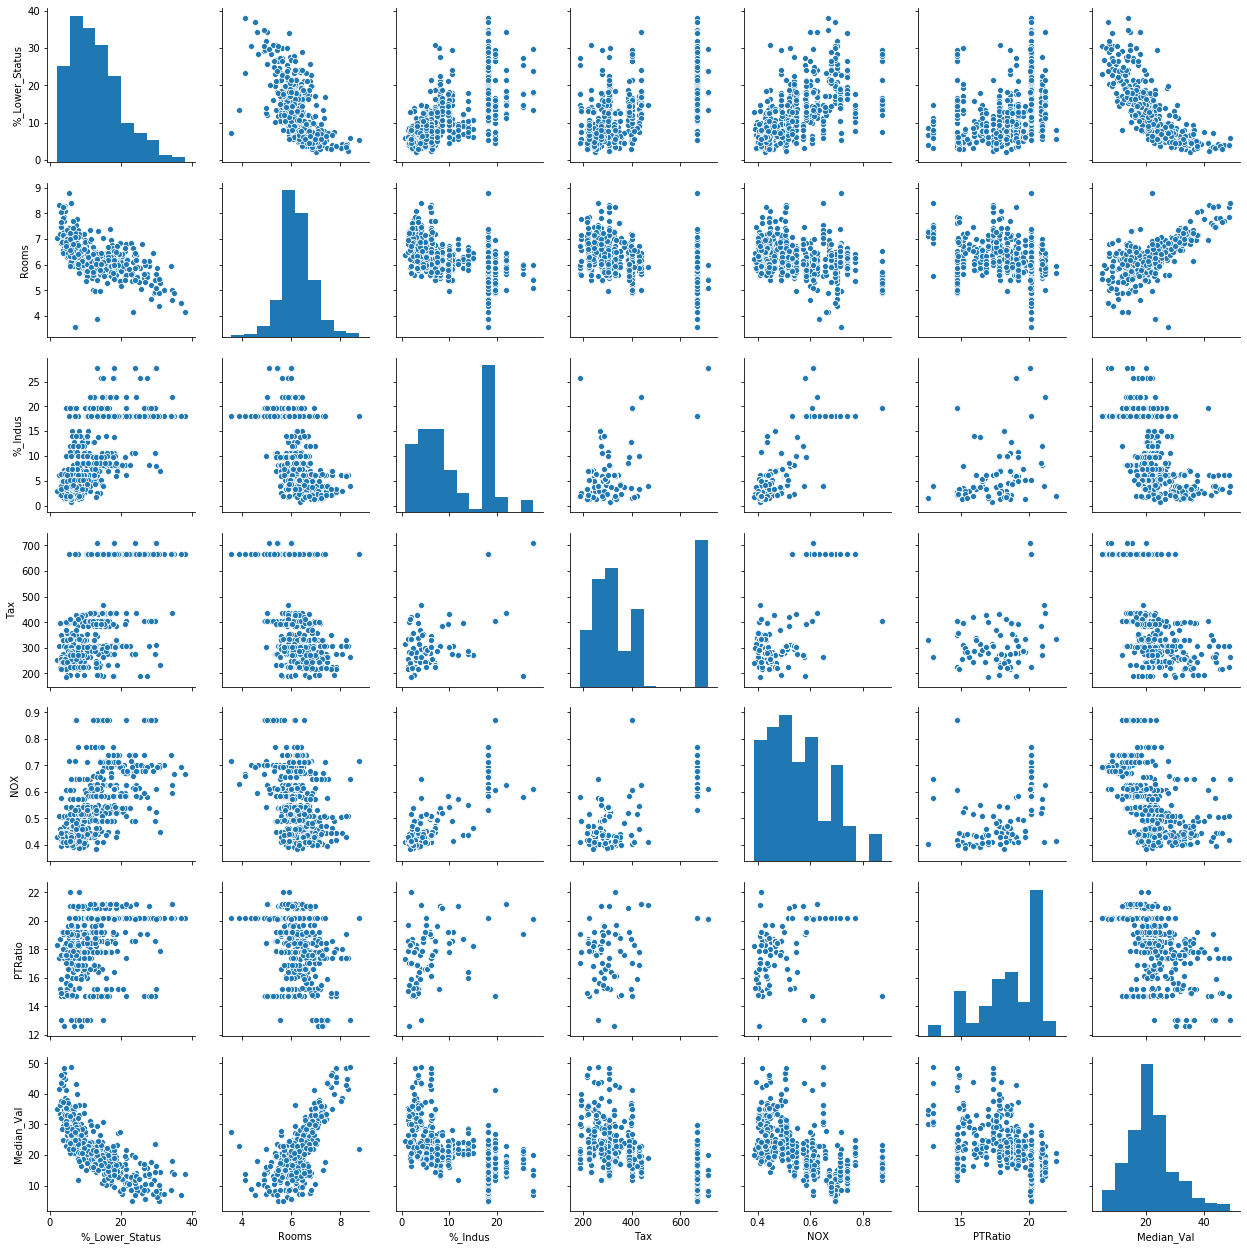

In [125]:
sns.pairplot(high_corr_features)

From looking at the right hand column of the pairplot above, I observed that only % Lower Status and number of Rooms had an obvious relationship with the Median Value. Furthermore, Tax, the % Industrial, and NOX were all corrolated with eachother making them bad features to include in the model.

#### 4.5.2.3 Filtering using F_regression

I also used this test to see if it identified any alternative features vs the corrolation test.

In [126]:
# modification of chi squared test code found here:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
fregX = fifty_plus_removed.iloc[:, 0:13]  
fregy = fifty_plus_removed["Median_Val"]
fregX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [127]:
bestfeatures = SelectKBest(score_func=f_regression, k=10) # show the top 10 best features
fregfit = bestfeatures.fit(fregX,fregy)
dfscores = pd.DataFrame(fregfit.scores_)
dfcolumns = pd.DataFrame(fregX.columns) 
fregfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)
fregfeatureScores.columns = ['Features','Score']  #naming the dataframe columns
print(fregfeatureScores.nlargest(10,'Score'))  #print 10 best features

          Features       Score
12  %_Lower_Status  666.627892
5            Rooms  435.309814
2          %_Indus  274.507475
9              Tax  237.855059
4              NOX  185.148836
10         PTRatio  179.568192
6       %_Pre_1940  156.620474
8   Highway_Access  143.190234
0       Crime_Rate  123.991786
1    %_Large_Plots   95.527784


As with the corrolation test, % Lower Status and Rooms were identified as by far the best predictors.

### 4.5.3 Testing with Filtered Features

In this section I tested to if the performance of the model was improved by using only the two best predictors of the Median Value: % of Lower Status people and the number of Rooms.

In [128]:
# creating a new dataset containing the two inputs and target variable
filtered_features = fifty_plus_removed[["%_Lower_Status","Rooms","Median_Val"]]
filtered_features.head()

,%_Lower_Status,Rooms,Median_Val
0,4.98,6.575,24.0
1,9.14,6.421,21.6
2,4.03,7.185,34.7
3,2.94,6.998,33.4
4,5.33,7.147,36.2


In [129]:
# shuffle again and split into train and test
filtered_features = shuffle(filtered_features)

FFX = filtered_features.drop(labels=['Median_Val'], axis = 1)
FFy = filtered_features['Median_Val']

FFX_train, FFX_test, FFy_train, FFy_test = mod.train_test_split(FFX, FFy, test_size = 0.2)

In [130]:
#check how many datapoints are in the train and test batches
FFX_train.shape, FFX_test.shape

((392, 2), (98, 2))

In [131]:
# new filtered features model
FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 627us/step - loss: 425.7433
Epoch 2/300
392/392 [==============================] - 0s 421us/step - loss: 280.5264
Epoch 3/300
392/392 [==============================] - 0s 409us/step - loss: 211.4636
Epoch 4/300
392/392 [==============================] - 0s 459us/step - loss: 179.9068
Epoch 5/300
392/392 [==============================] - 0s 401us/step - loss: 157.9352
Epoch 6/300
392/392 [==============================] - 0s 422us/step - loss: 139.2381
Epoch 7/300
392/392 [==============================] - 0s 454us/step - loss: 122.2324
Epoch 8/300
392/392 [==============================] - 0s 449us/step - loss: 106.2742
Epoch 9/300
392/392 [==============================] - 0s 414us/step - loss: 91.6095
Epoch 10/300
392/392 [==============================] - 0s 465us/step - loss: 78.1142
Epoch 11/300
392/392 [==============================] - 0s 442us/step - loss: 65.8343
Epoch 12/300
392/392 [==============================] -

392/392 [==============================] - 0s 437us/step - loss: 17.4573
Epoch 97/300
392/392 [==============================] - 0s 441us/step - loss: 17.3775
Epoch 98/300
392/392 [==============================] - 0s 432us/step - loss: 17.4728
Epoch 99/300
392/392 [==============================] - 0s 425us/step - loss: 17.3667
Epoch 100/300
392/392 [==============================] - 0s 429us/step - loss: 17.4592
Epoch 101/300
392/392 [==============================] - 0s 421us/step - loss: 17.3800
Epoch 102/300
392/392 [==============================] - 0s 423us/step - loss: 17.4080
Epoch 103/300
392/392 [==============================] - 0s 436us/step - loss: 17.2849
Epoch 104/300
392/392 [==============================] - 0s 432us/step - loss: 17.2732
Epoch 105/300
392/392 [==============================] - 0s 427us/step - loss: 17.3815
Epoch 106/300
392/392 [==============================] - 0s 429us/step - loss: 17.4449
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 396us/step - loss: 16.8276
Epoch 191/300
392/392 [==============================] - 0s 415us/step - loss: 16.9409
Epoch 192/300
392/392 [==============================] - 0s 435us/step - loss: 16.9659
Epoch 193/300
392/392 [==============================] - 0s 421us/step - loss: 16.9080
Epoch 194/300
392/392 [==============================] - 0s 424us/step - loss: 16.8176
Epoch 195/300
392/392 [==============================] - 0s 415us/step - loss: 16.8264
Epoch 196/300
392/392 [==============================] - 0s 424us/step - loss: 16.8870
Epoch 197/300
392/392 [==============================] - 0s 438us/step - loss: 16.8424
Epoch 198/300
392/392 [==============================] - 0s 425us/step - loss: 16.8126
Epoch 199/300
392/392 [==============================] - 0s 425us/step - loss: 16.8282
Epoch 200/300
392/392 [==============================] - 0s 427us/step - loss: 16.8161
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 402us/step - loss: 16.3999
Epoch 285/300
392/392 [==============================] - 0s 436us/step - loss: 16.4608
Epoch 286/300
392/392 [==============================] - 0s 415us/step - loss: 16.4636
Epoch 287/300
392/392 [==============================] - 0s 383us/step - loss: 16.4519
Epoch 288/300
392/392 [==============================] - 0s 391us/step - loss: 16.4386
Epoch 289/300
392/392 [==============================] - 0s 425us/step - loss: 16.4691
Epoch 290/300
392/392 [==============================] - 0s 427us/step - loss: 16.3820
Epoch 291/300
392/392 [==============================] - 0s 382us/step - loss: 16.3488
Epoch 292/300
392/392 [==============================] - 0s 392us/step - loss: 16.4971
Epoch 293/300
392/392 [==============================] - 0s 435us/step - loss: 16.3472
Epoch 294/300
392/392 [==============================] - 0s 407us/step - loss: 16.4344
Epoch 295/300
392/392 [==============================] - 

In [132]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 192us/step


17.30821975396604

**Result:** The result was a MSE of 16.9, drastically worse than the Baseline Test and some of the better performing subsequent models.

#### 4.5.3.1 Filtered Features Standardisation

While initial results for the model using the filtered features were worse than the Baseline, the data had not been standardised yet. The logical next step was to standardise the filtered features and evaluate performance with that data.

In [133]:
#scaling the filtered features
scaler = pre.StandardScaler()
FFX_train = pd.DataFrame(scaler.fit_transform(FFX_train), columns=FFX.columns)
FFX_test = pd.DataFrame(scaler.transform(FFX_test), columns=FFX.columns)

In [134]:
FFX_train.head()

,%_Lower_Status,Rooms
0,-0.609225,-0.651556
1,0.851568,-0.316995
2,0.532153,-1.013868
3,-1.104674,0.490883
4,0.488144,-1.009242


In [135]:
# model test with normalised input features 

FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 718us/step - loss: 485.0536
Epoch 2/300
392/392 [==============================] - 0s 445us/step - loss: 449.1575
Epoch 3/300
392/392 [==============================] - 0s 442us/step - loss: 405.1463
Epoch 4/300
392/392 [==============================] - 0s 469us/step - loss: 354.0317
Epoch 5/300
392/392 [==============================] - 0s 442us/step - loss: 298.6799
Epoch 6/300
392/392 [==============================] - 0s 472us/step - loss: 242.7174
Epoch 7/300
392/392 [==============================] - 0s 473us/step - loss: 190.1369
Epoch 8/300
392/392 [==============================] - 0s 473us/step - loss: 143.7994
Epoch 9/300
392/392 [==============================] - 0s 447us/step - loss: 105.5762
Epoch 10/300
392/392 [==============================] - 0s 428us/step - loss: 76.1925
Epoch 11/300
392/392 [==============================] - 0s 480us/step - loss: 54.9960
Epoch 12/300
392/392 [==============================] 

392/392 [==============================] - 0s 472us/step - loss: 13.6994
Epoch 97/300
392/392 [==============================] - 0s 454us/step - loss: 13.7291
Epoch 98/300
392/392 [==============================] - 0s 463us/step - loss: 13.7226
Epoch 99/300
392/392 [==============================] - 0s 464us/step - loss: 13.6915
Epoch 100/300
392/392 [==============================] - 0s 455us/step - loss: 13.6471
Epoch 101/300
392/392 [==============================] - 0s 451us/step - loss: 13.6400
Epoch 102/300
392/392 [==============================] - 0s 460us/step - loss: 13.6833
Epoch 103/300
392/392 [==============================] - 0s 471us/step - loss: 13.6227
Epoch 104/300
392/392 [==============================] - 0s 488us/step - loss: 13.6149
Epoch 105/300
392/392 [==============================] - 0s 486us/step - loss: 13.6004
Epoch 106/300
392/392 [==============================] - 0s 452us/step - loss: 13.6107
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 420us/step - loss: 13.0195
Epoch 191/300
392/392 [==============================] - 0s 400us/step - loss: 12.9748
Epoch 192/300
392/392 [==============================] - 0s 436us/step - loss: 12.9490
Epoch 193/300
392/392 [==============================] - 0s 409us/step - loss: 12.9559
Epoch 194/300
392/392 [==============================] - 0s 444us/step - loss: 12.9684
Epoch 195/300
392/392 [==============================] - 0s 459us/step - loss: 12.9702
Epoch 196/300
392/392 [==============================] - 0s 444us/step - loss: 12.9468
Epoch 197/300
392/392 [==============================] - 0s 423us/step - loss: 12.9335
Epoch 198/300
392/392 [==============================] - 0s 452us/step - loss: 12.9321
Epoch 199/300
392/392 [==============================] - 0s 432us/step - loss: 12.9131
Epoch 200/300
392/392 [==============================] - 0s 425us/step - loss: 12.9837
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 451us/step - loss: 12.7526
Epoch 285/300
392/392 [==============================] - 0s 448us/step - loss: 12.7885
Epoch 286/300
392/392 [==============================] - 0s 457us/step - loss: 12.7511
Epoch 287/300
392/392 [==============================] - 0s 455us/step - loss: 12.7861
Epoch 288/300
392/392 [==============================] - 0s 446us/step - loss: 12.7869
Epoch 289/300
392/392 [==============================] - 0s 459us/step - loss: 12.7678
Epoch 290/300
392/392 [==============================] - 0s 457us/step - loss: 12.7958
Epoch 291/300
392/392 [==============================] - 0s 456us/step - loss: 12.7736
Epoch 292/300
392/392 [==============================] - 0s 456us/step - loss: 12.7818
Epoch 293/300
392/392 [==============================] - 0s 447us/step - loss: 12.7397
Epoch 294/300
392/392 [==============================] - 0s 457us/step - loss: 12.7830
Epoch 295/300
392/392 [==============================] - 

In [136]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 234us/step


11.835633491983218

**Result:** MSE was 18.124

Even after the standardisation the performance of the model still failed by a wide marginto beat the Baseline test where all 13 features where included.

#### 4.5.3.2 Filtered Features - Comparing Various Model Configurations

To be sure that not improvements using the filtered set were possible I tested serveral different model configurations. 

In [137]:
# function to test various model configurations on the filter features dataset
def FF_tester(layer_size1, layer_size2, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(layer_size2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [138]:
#big_all_adam = FF_tester(64,64,32,"adam") # large layers, large batches, adam optimizer
#big_all_adam

In [139]:
#bigLayer_mediumbatch_adam = FF_tester(64,64,16,"adam") # large layers, large batches, adam optimizer
#bigLayer_smallbatch_adam = FF_tester(64,64,4,"adam")

In [140]:
#print(bigLayer_mediumbatch_adam)

In [141]:
# print(bigLayer_smallbatch_adam)

In [142]:
# mediumLayer_bigbatch_adam = FF_tester(32,12,32,"adam")
# mediumLayer_mediumbatch_adam  = FF_tester(32,12,16,"adam")
# mediumLayer_smallbatch_adam  = FF_tester(32,12,4,"adam")

In [143]:
# print(mediumLayer_bigbatch_adam)
# print(mediumLayer_mediumbatch_adam)
# print(mediumLayer_smallbatch_adam)

In [144]:
#smallLayer_bigbatch_adam  = FF_tester(12,6,32,"adam")
#smallLayer_mediumbatch_adam  = FF_tester(12,6,16,"adam")
#smallLayer_smallbatch_adam  = FF_tester(12,6,4,"adam")
# tinyLayer_smallbatch_adam = FF_tester(2,2,4,"adam")

In [145]:
# print(smallLayer_bigbatch_adam)
# print(smallLayer_mediumbatch_adam)
# print(smallLayer_smallbatch_adam)
# print(tinyLayer_smallbatch_adam)

**Result:** Medium layer sizes seemed to peform the best, but still did not better the original baseline test. Next I tried removing a layer.

In [146]:
def FF_tester_1layer(layer_size1, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [147]:
# hugelayer = FF_tester_1layer(64, 4, "adam")
# biglayer = FF_tester_1layer(32, 4, "adam")
# mediumlayer = FF_tester_1layer(12, 4, "adam")
# smalllayer = FF_tester_1layer(6, 4, "adam")


In [148]:
# print(hugelayer)
# print(biglayer)
# print(mediumlayer)
# print(smalllayer)

**Result:** Again, there didn't seem to be any drastic improvements and the results were still not beating the initial Baseline Test on all features. 

## 4.6 Conclusion and Final Model

In this final section, I retested the best performing models from above to determine the final model. For the re-test I used the dataset with all variables included, but with the samples that had a Median Value of 50,000 removed. 

In [149]:
final_model_df = fifty_plus_removed
final_model_df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [150]:
# suffling the data 
final_model_df = shuffle(final_model_df)
final_model_df

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
453,8.24809,0.0,18.10,0.0,0.713,7.393,99.3,2.4527,24.0,666.0,20.2,375.87,16.74,17.8
177,0.05425,0.0,4.05,0.0,0.510,6.315,73.4,3.3175,5.0,296.0,16.6,395.60,6.29,24.6
359,4.26131,0.0,18.10,0.0,0.770,6.112,81.3,2.5091,24.0,666.0,20.2,390.74,12.67,22.6
375,19.60910,0.0,18.10,0.0,0.671,7.313,97.9,1.3163,24.0,666.0,20.2,396.90,13.44,15.0
189,0.08370,45.0,3.44,0.0,0.437,7.185,38.9,4.5667,5.0,398.0,15.2,396.90,5.39,34.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.47547,0.0,9.90,0.0,0.544,6.113,58.8,4.0019,4.0,304.0,18.4,396.23,12.73,21.0
184,0.08308,0.0,2.46,0.0,0.488,5.604,89.8,2.9879,3.0,193.0,17.8,391.00,13.98,26.4
487,4.83567,0.0,18.10,0.0,0.583,5.905,53.2,3.1523,24.0,666.0,20.2,388.22,11.45,20.6
378,23.64820,0.0,18.10,0.0,0.671,6.380,96.2,1.3861,24.0,666.0,20.2,396.90,23.69,13.1


In [151]:
# creating the input and out datasets for the final tests
FinalX = final_model_df.drop(labels=['Median_Val'], axis = 1)
Finaly = final_model_df['Median_Val']

FinalX_train, FinalX_test, Finaly_train, Finaly_test = mod.train_test_split(FinalX, Finaly, test_size = 0.2, random_state = 0)

In [152]:
FinalX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
453,8.24809,0.0,18.10,0.0,0.713,7.393,99.3,2.4527,24.0,666.0,20.2,375.87,16.74
177,0.05425,0.0,4.05,0.0,0.510,6.315,73.4,3.3175,5.0,296.0,16.6,395.60,6.29
359,4.26131,0.0,18.10,0.0,0.770,6.112,81.3,2.5091,24.0,666.0,20.2,390.74,12.67
375,19.60910,0.0,18.10,0.0,0.671,7.313,97.9,1.3163,24.0,666.0,20.2,396.90,13.44
189,0.08370,45.0,3.44,0.0,0.437,7.185,38.9,4.5667,5.0,398.0,15.2,396.90,5.39


In [153]:
# scaling the data
scaler = pre.StandardScaler()
FinalX_train = pd.DataFrame(scaler.fit_transform(FinalX_train), columns=FinalX.columns)
FinalX_test = pd.DataFrame(scaler.transform(FinalX_test), columns=FinalX.columns)

In [154]:
FinalX_train.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.372704,-0.494121,-0.156335,-0.249661,-0.077864,-0.415473,0.310465,-0.372062,-0.616266,-0.595299,-0.012991,0.440093,-0.410576
1,-0.408822,1.004408,-0.722202,-0.249661,-0.975521,-0.819564,-1.424085,1.304900,-0.966715,-0.595299,-0.713788,0.414811,-0.061404
2,-0.410659,2.931088,-0.885773,-0.249661,-1.203108,0.935042,-1.442041,0.582587,-0.616266,-0.950018,0.360768,0.447609,-1.353057
3,-0.339606,-0.494121,-0.701572,4.005431,-0.390902,0.962386,0.346377,-0.291678,-0.149000,-0.577262,-0.480189,0.373472,-0.416253
4,-0.409694,2.931088,-1.333752,-0.249661,-1.186187,-0.884887,-1.657513,3.174669,-0.616266,-0.414933,1.668922,0.287035,-0.683101


In [155]:
#test final model option 1
def Final_tester(layer_size1, layer_size2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(layer_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(layer_size2, activation="relu"))
        m.add(ks.layers.Dense(1,activation="linear"))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=20, verbose=1)

        m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(FinalX_test, Finaly_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [156]:
final_results = [
    Final_tester(13, 13),
    Final_tester(26, 26),
    Final_tester(26, 13),
    Final_tester(52, 26),
    Final_tester(64, 13)
]

Epoch 1/300
392/392 [==============================] - 0s 858us/step - loss: 493.1631
Epoch 2/300
392/392 [==============================] - 0s 468us/step - loss: 368.6130
Epoch 3/300
392/392 [==============================] - 0s 495us/step - loss: 172.8198
Epoch 4/300
392/392 [==============================] - 0s 480us/step - loss: 59.2703
Epoch 5/300
392/392 [==============================] - 0s 513us/step - loss: 33.4944
Epoch 6/300
392/392 [==============================] - 0s 483us/step - loss: 24.2595
Epoch 7/300
392/392 [==============================] - 0s 486us/step - loss: 20.4730
Epoch 8/300
392/392 [==============================] - 0s 483us/step - loss: 18.2789
Epoch 9/300
392/392 [==============================] - 0s 439us/step - loss: 16.7301
Epoch 10/300
392/392 [==============================] - 0s 479us/step - loss: 15.7491
Epoch 11/300
392/392 [==============================] - 0s 501us/step - loss: 14.7750
Epoch 12/300
392/392 [==============================] - 0s 4

392/392 [==============================] - 0s 480us/step - loss: 5.5359
Epoch 98/300
392/392 [==============================] - 0s 456us/step - loss: 5.5065
Epoch 99/300
392/392 [==============================] - 0s 468us/step - loss: 5.4896
Epoch 100/300
392/392 [==============================] - 0s 493us/step - loss: 5.3764
Epoch 101/300
392/392 [==============================] - 0s 465us/step - loss: 5.4792
Epoch 102/300
392/392 [==============================] - 0s 465us/step - loss: 5.3263
Epoch 103/300
392/392 [==============================] - 0s 456us/step - loss: 5.3911
Epoch 104/300
392/392 [==============================] - 0s 478us/step - loss: 5.3828
Epoch 105/300
392/392 [==============================] - 0s 469us/step - loss: 5.3428
Epoch 106/300
392/392 [==============================] - 0s 436us/step - loss: 5.3315
Epoch 107/300
392/392 [==============================] - 0s 428us/step - loss: 5.2960
Epoch 108/300
392/392 [==============================] - 0s 441us/step

392/392 [==============================] - 0s 452us/step - loss: 4.2835
Epoch 193/300
392/392 [==============================] - 0s 485us/step - loss: 4.2546
Epoch 194/300
392/392 [==============================] - 0s 486us/step - loss: 4.2493
Epoch 195/300
392/392 [==============================] - 0s 480us/step - loss: 4.2925
Epoch 196/300
392/392 [==============================] - 0s 477us/step - loss: 4.2636
Epoch 197/300
392/392 [==============================] - 0s 475us/step - loss: 4.2119
Epoch 198/300
392/392 [==============================] - 0s 480us/step - loss: 4.2092
Epoch 199/300
392/392 [==============================] - 0s 467us/step - loss: 4.1888
Epoch 200/300
392/392 [==============================] - 0s 463us/step - loss: 4.1905
Epoch 201/300
392/392 [==============================] - 0s 471us/step - loss: 4.1433
Epoch 202/300
392/392 [==============================] - 0s 480us/step - loss: 4.1326
Epoch 203/300
392/392 [==============================] - 0s 479us/st

392/392 [==============================] - 0s 482us/step - loss: 3.5624
Epoch 288/300
392/392 [==============================] - 0s 462us/step - loss: 3.5455
Epoch 289/300
392/392 [==============================] - 0s 474us/step - loss: 3.5396
Epoch 290/300
392/392 [==============================] - 0s 477us/step - loss: 3.4422
Epoch 291/300
392/392 [==============================] - 0s 471us/step - loss: 3.5530
Epoch 292/300
392/392 [==============================] - 0s 474us/step - loss: 3.5900
Epoch 293/300
392/392 [==============================] - 0s 467us/step - loss: 3.5261
Epoch 294/300
392/392 [==============================] - 0s 484us/step - loss: 3.4771
Epoch 295/300
392/392 [==============================] - 0s 470us/step - loss: 3.5050
Epoch 296/300
392/392 [==============================] - 0s 505us/step - loss: 3.4843
Epoch 297/300
392/392 [==============================] - 0s 474us/step - loss: 3.4832
Epoch 298/300
392/392 [==============================] - 0s 449us/st

392/392 [==============================] - 0s 414us/step - loss: 5.7244
Epoch 83/300
392/392 [==============================] - 0s 444us/step - loss: 5.6627
Epoch 84/300
392/392 [==============================] - 0s 441us/step - loss: 5.5592
Epoch 85/300
392/392 [==============================] - 0s 432us/step - loss: 5.5361
Epoch 86/300
392/392 [==============================] - 0s 432us/step - loss: 5.6245
Epoch 87/300
392/392 [==============================] - 0s 447us/step - loss: 5.5981
Epoch 88/300
392/392 [==============================] - 0s 434us/step - loss: 5.6673
Epoch 89/300
392/392 [==============================] - 0s 408us/step - loss: 5.6606
Epoch 90/300
392/392 [==============================] - 0s 454us/step - loss: 5.6275
Epoch 91/300
392/392 [==============================] - 0s 445us/step - loss: 5.5654
Epoch 92/300
392/392 [==============================] - 0s 425us/step - loss: 5.5136
Epoch 93/300
392/392 [==============================] - 0s 401us/step - loss: 

392/392 [==============================] - 0s 433us/step - loss: 4.5060
Epoch 178/300
392/392 [==============================] - 0s 437us/step - loss: 4.6060
Epoch 179/300
392/392 [==============================] - 0s 455us/step - loss: 4.5822
Epoch 180/300
392/392 [==============================] - 0s 400us/step - loss: 4.4589
Epoch 181/300
392/392 [==============================] - 0s 442us/step - loss: 4.6041
Epoch 182/300
392/392 [==============================] - 0s 428us/step - loss: 4.5047
Epoch 183/300
392/392 [==============================] - 0s 461us/step - loss: 4.5455
Epoch 184/300
392/392 [==============================] - 0s 415us/step - loss: 4.5337
Epoch 185/300
392/392 [==============================] - 0s 423us/step - loss: 4.4536
Epoch 186/300
392/392 [==============================] - 0s 453us/step - loss: 4.5498
Epoch 187/300
392/392 [==============================] - 0s 431us/step - loss: 4.4529
Epoch 188/300
392/392 [==============================] - 0s 450us/st

392/392 [==============================] - 0s 448us/step - loss: 3.8966
Epoch 273/300
392/392 [==============================] - 0s 291us/step - loss: 3.8674
Epoch 274/300
392/392 [==============================] - 0s 341us/step - loss: 3.9539
Epoch 275/300
392/392 [==============================] - 0s 327us/step - loss: 3.8760
Epoch 276/300
392/392 [==============================] - 0s 329us/step - loss: 3.9509
Epoch 277/300
392/392 [==============================] - 0s 330us/step - loss: 4.0195
Epoch 278/300
392/392 [==============================] - 0s 338us/step - loss: 3.8675
Epoch 279/300
392/392 [==============================] - 0s 337us/step - loss: 3.8607
Epoch 280/300
392/392 [==============================] - 0s 326us/step - loss: 3.8674
Epoch 281/300
392/392 [==============================] - 0s 335us/step - loss: 3.9555
Epoch 282/300
392/392 [==============================] - 0s 319us/step - loss: 3.9479
Epoch 283/300
392/392 [==============================] - 0s 339us/st

392/392 [==============================] - 0s 424us/step - loss: 6.3601
Epoch 68/300
392/392 [==============================] - 0s 426us/step - loss: 6.4048
Epoch 69/300
392/392 [==============================] - 0s 447us/step - loss: 6.2958
Epoch 70/300
392/392 [==============================] - 0s 435us/step - loss: 6.3147
Epoch 71/300
392/392 [==============================] - 0s 473us/step - loss: 6.2719
Epoch 72/300
392/392 [==============================] - 0s 470us/step - loss: 6.2679
Epoch 73/300
392/392 [==============================] - 0s 429us/step - loss: 6.2750
Epoch 74/300
392/392 [==============================] - 0s 465us/step - loss: 6.2935
Epoch 75/300
392/392 [==============================] - 0s 429us/step - loss: 6.2163
Epoch 76/300
392/392 [==============================] - 0s 456us/step - loss: 6.1438
Epoch 77/300
392/392 [==============================] - 0s 428us/step - loss: 6.1913
Epoch 78/300
392/392 [==============================] - 0s 438us/step - loss: 

392/392 [==============================] - 0s 320us/step - loss: 4.9810
Epoch 163/300
392/392 [==============================] - 0s 387us/step - loss: 4.9280
Epoch 164/300
392/392 [==============================] - 0s 449us/step - loss: 4.8790
Epoch 165/300
392/392 [==============================] - 0s 457us/step - loss: 4.8783
Epoch 166/300
392/392 [==============================] - 0s 476us/step - loss: 4.8351
Epoch 167/300
392/392 [==============================] - 0s 463us/step - loss: 4.9275
Epoch 168/300
392/392 [==============================] - 0s 459us/step - loss: 4.7980
Epoch 169/300
392/392 [==============================] - 0s 446us/step - loss: 4.8722
Epoch 170/300
392/392 [==============================] - 0s 432us/step - loss: 4.7562
Epoch 171/300
392/392 [==============================] - 0s 437us/step - loss: 4.8016
Epoch 172/300
392/392 [==============================] - 0s 448us/step - loss: 4.7774
Epoch 173/300
392/392 [==============================] - 0s 463us/st

392/392 [==============================] - 0s 305us/step - loss: 4.0436
Epoch 258/300
392/392 [==============================] - 0s 316us/step - loss: 4.0590
Epoch 259/300
392/392 [==============================] - 0s 348us/step - loss: 4.0409
Epoch 260/300
392/392 [==============================] - 0s 327us/step - loss: 3.9533
Epoch 261/300
392/392 [==============================] - 0s 313us/step - loss: 3.9838
Epoch 262/300
392/392 [==============================] - 0s 324us/step - loss: 3.9241
Epoch 263/300
392/392 [==============================] - 0s 304us/step - loss: 3.9248
Epoch 264/300
392/392 [==============================] - 0s 316us/step - loss: 4.0437
Epoch 265/300
392/392 [==============================] - 0s 317us/step - loss: 3.9695
Epoch 266/300
392/392 [==============================] - 0s 332us/step - loss: 3.9874
Epoch 267/300
392/392 [==============================] - 0s 313us/step - loss: 4.0298
Epoch 268/300
392/392 [==============================] - 0s 335us/st

392/392 [==============================] - 0s 329us/step - loss: 7.0583
Epoch 52/300
392/392 [==============================] - 0s 328us/step - loss: 6.9954
Epoch 53/300
392/392 [==============================] - 0s 336us/step - loss: 6.8784
Epoch 54/300
392/392 [==============================] - 0s 336us/step - loss: 6.8547
Epoch 55/300
392/392 [==============================] - 0s 334us/step - loss: 6.8300
Epoch 56/300
392/392 [==============================] - 0s 341us/step - loss: 6.7992
Epoch 57/300
392/392 [==============================] - 0s 332us/step - loss: 6.9141
Epoch 58/300
392/392 [==============================] - 0s 335us/step - loss: 6.7237
Epoch 59/300
392/392 [==============================] - 0s 342us/step - loss: 6.7745
Epoch 60/300
392/392 [==============================] - 0s 338us/step - loss: 6.5726
Epoch 61/300
392/392 [==============================] - 0s 337us/step - loss: 6.6967
Epoch 62/300
392/392 [==============================] - 0s 343us/step - loss: 

Epoch 147/300
392/392 [==============================] - 0s 330us/step - loss: 4.7893
Epoch 148/300
392/392 [==============================] - 0s 335us/step - loss: 4.8338
Epoch 149/300
392/392 [==============================] - 0s 324us/step - loss: 4.8623
Epoch 150/300
392/392 [==============================] - 0s 328us/step - loss: 4.8348
Epoch 151/300
392/392 [==============================] - 0s 340us/step - loss: 4.7887
Epoch 152/300
392/392 [==============================] - 0s 338us/step - loss: 4.9250
Epoch 153/300
392/392 [==============================] - 0s 343us/step - loss: 4.7652
Epoch 154/300
392/392 [==============================] - 0s 325us/step - loss: 4.7036
Epoch 155/300
392/392 [==============================] - 0s 330us/step - loss: 4.8254
Epoch 156/300
392/392 [==============================] - 0s 354us/step - loss: 4.6359
Epoch 157/300
392/392 [==============================] - 0s 326us/step - loss: 4.6788
Epoch 158/300
392/392 [==============================]

392/392 [==============================] - 0s 290us/step - loss: 3.9796
Epoch 243/300
392/392 [==============================] - 0s 304us/step - loss: 3.9604
Epoch 244/300
392/392 [==============================] - 0s 327us/step - loss: 3.7680
Epoch 245/300
392/392 [==============================] - 0s 318us/step - loss: 3.8552
Epoch 246/300
392/392 [==============================] - 0s 320us/step - loss: 3.8967
Epoch 247/300
392/392 [==============================] - 0s 308us/step - loss: 4.0478
Epoch 248/300
392/392 [==============================] - 0s 316us/step - loss: 3.7944
Epoch 249/300
392/392 [==============================] - 0s 322us/step - loss: 3.7867
Epoch 250/300
392/392 [==============================] - 0s 320us/step - loss: 3.8320
Epoch 251/300
392/392 [==============================] - 0s 312us/step - loss: 3.8161
Epoch 252/300
392/392 [==============================] - 0s 340us/step - loss: 3.8754
Epoch 253/300
392/392 [==============================] - 0s 325us/st

Epoch 37/300
392/392 [==============================] - 0s 284us/step - loss: 8.7330
Epoch 38/300
392/392 [==============================] - 0s 265us/step - loss: 8.5939
Epoch 39/300
392/392 [==============================] - 0s 300us/step - loss: 8.5563
Epoch 40/300
392/392 [==============================] - 0s 302us/step - loss: 8.3668
Epoch 41/300
392/392 [==============================] - 0s 313us/step - loss: 8.4216
Epoch 42/300
392/392 [==============================] - 0s 308us/step - loss: 8.3784
Epoch 43/300
392/392 [==============================] - 0s 307us/step - loss: 8.1304
Epoch 44/300
392/392 [==============================] - 0s 321us/step - loss: 8.2244
Epoch 45/300
392/392 [==============================] - 0s 282us/step - loss: 8.0452
Epoch 46/300
392/392 [==============================] - 0s 294us/step - loss: 7.9449
Epoch 47/300
392/392 [==============================] - 0s 295us/step - loss: 7.8928
Epoch 48/300
392/392 [==============================] - 0s 297us/

Epoch 133/300
392/392 [==============================] - 0s 288us/step - loss: 5.5338
Epoch 134/300
392/392 [==============================] - 0s 307us/step - loss: 5.3967
Epoch 135/300
392/392 [==============================] - 0s 305us/step - loss: 5.4160
Epoch 136/300
392/392 [==============================] - 0s 318us/step - loss: 5.4400
Epoch 137/300
392/392 [==============================] - 0s 330us/step - loss: 5.3157
Epoch 138/300
392/392 [==============================] - 0s 277us/step - loss: 5.3329
Epoch 139/300
392/392 [==============================] - 0s 300us/step - loss: 5.2301
Epoch 140/300
392/392 [==============================] - 0s 293us/step - loss: 5.4342
Epoch 141/300
392/392 [==============================] - 0s 294us/step - loss: 5.2937
Epoch 142/300
392/392 [==============================] - 0s 305us/step - loss: 5.3608
Epoch 143/300
392/392 [==============================] - 0s 287us/step - loss: 5.3215
Epoch 144/300
392/392 [==============================]

392/392 [==============================] - 0s 292us/step - loss: 4.2703
Epoch 229/300
392/392 [==============================] - 0s 290us/step - loss: 4.2977
Epoch 230/300
392/392 [==============================] - 0s 296us/step - loss: 4.3020
Epoch 231/300
392/392 [==============================] - 0s 318us/step - loss: 4.3252
Epoch 232/300
392/392 [==============================] - 0s 294us/step - loss: 4.3004
Epoch 233/300
392/392 [==============================] - 0s 306us/step - loss: 4.2251
Epoch 234/300
392/392 [==============================] - 0s 290us/step - loss: 4.2124
Epoch 235/300
392/392 [==============================] - 0s 311us/step - loss: 4.1982
Epoch 236/300
392/392 [==============================] - 0s 290us/step - loss: 4.1759
Epoch 237/300
392/392 [==============================] - 0s 294us/step - loss: 4.2655
Epoch 238/300
392/392 [==============================] - 0s 312us/step - loss: 4.2458
Epoch 239/300
392/392 [==============================] - 0s 304us/st

392/392 [==============================] - 0s 320us/step - loss: 7.8704
Epoch 23/300
392/392 [==============================] - 0s 347us/step - loss: 7.5606
Epoch 24/300
392/392 [==============================] - 0s 432us/step - loss: 7.5766
Epoch 25/300
392/392 [==============================] - 0s 396us/step - loss: 7.4420
Epoch 26/300
392/392 [==============================] - 0s 357us/step - loss: 7.1357
Epoch 27/300
392/392 [==============================] - 0s 347us/step - loss: 7.0987
Epoch 28/300
392/392 [==============================] - 0s 354us/step - loss: 6.9267
Epoch 29/300
392/392 [==============================] - 0s 331us/step - loss: 6.9165
Epoch 30/300
392/392 [==============================] - 0s 308us/step - loss: 6.8951
Epoch 31/300
392/392 [==============================] - 0s 339us/step - loss: 6.6148
Epoch 32/300
392/392 [==============================] - 0s 352us/step - loss: 6.5948
Epoch 33/300
392/392 [==============================] - 0s 333us/step - loss: 

392/392 [==============================] - 0s 496us/step - loss: 4.0604
Epoch 118/300
392/392 [==============================] - 0s 471us/step - loss: 4.1226
Epoch 119/300
392/392 [==============================] - 0s 494us/step - loss: 4.0552
Epoch 120/300
392/392 [==============================] - 0s 486us/step - loss: 4.0801
Epoch 121/300
392/392 [==============================] - 0s 450us/step - loss: 3.8977
Epoch 122/300
392/392 [==============================] - 0s 436us/step - loss: 3.9643
Epoch 123/300
392/392 [==============================] - 0s 494us/step - loss: 3.9574
Epoch 124/300
392/392 [==============================] - 0s 500us/step - loss: 4.0181
Epoch 125/300
392/392 [==============================] - 0s 471us/step - loss: 3.9365
Epoch 126/300
392/392 [==============================] - 0s 476us/step - loss: 4.0346
Epoch 127/300
392/392 [==============================] - 0s 477us/step - loss: 3.8835
Epoch 128/300
392/392 [==============================] - 0s 534us/st

392/392 [==============================] - 0s 497us/step - loss: 3.2784
Epoch 213/300
392/392 [==============================] - 0s 444us/step - loss: 3.1696
Epoch 214/300
392/392 [==============================] - 0s 479us/step - loss: 3.1130
Epoch 215/300
392/392 [==============================] - 0s 438us/step - loss: 3.2764: 0s - loss: 2.89
Epoch 216/300
392/392 [==============================] - 0s 457us/step - loss: 3.1136
Epoch 217/300
392/392 [==============================] - 0s 451us/step - loss: 3.1226
Epoch 218/300
392/392 [==============================] - 0s 441us/step - loss: 3.1816
Epoch 219/300
392/392 [==============================] - 0s 463us/step - loss: 3.1450
Epoch 220/300
392/392 [==============================] - 0s 454us/step - loss: 3.1396
Epoch 221/300
392/392 [==============================] - 0s 491us/step - loss: 3.2534
Epoch 222/300
392/392 [==============================] - 0s 458us/step - loss: 3.1055
Epoch 223/300
392/392 [============================

392/392 [==============================] - 0s 466us/step - loss: 17.0732
Epoch 7/300
392/392 [==============================] - 0s 457us/step - loss: 15.5906
Epoch 8/300
392/392 [==============================] - 0s 481us/step - loss: 14.4270
Epoch 9/300
392/392 [==============================] - 0s 490us/step - loss: 13.6523
Epoch 10/300
392/392 [==============================] - 0s 484us/step - loss: 12.7645
Epoch 11/300
392/392 [==============================] - 0s 476us/step - loss: 12.2876
Epoch 12/300
392/392 [==============================] - 0s 438us/step - loss: 11.4007
Epoch 13/300
392/392 [==============================] - 0s 487us/step - loss: 10.8689
Epoch 14/300
392/392 [==============================] - 0s 490us/step - loss: 10.3687
Epoch 15/300
392/392 [==============================] - 0s 458us/step - loss: 10.0543
Epoch 16/300
392/392 [==============================] - 0s 454us/step - loss: 9.3743
Epoch 17/300
392/392 [==============================] - 0s 485us/step -

392/392 [==============================] - 0s 469us/step - loss: 3.7877
Epoch 103/300
392/392 [==============================] - 0s 465us/step - loss: 3.9446
Epoch 104/300
392/392 [==============================] - 0s 485us/step - loss: 3.6625
Epoch 105/300
392/392 [==============================] - 0s 491us/step - loss: 3.6498
Epoch 106/300
392/392 [==============================] - 0s 477us/step - loss: 3.7293
Epoch 107/300
392/392 [==============================] - 0s 421us/step - loss: 3.5669
Epoch 108/300
392/392 [==============================] - 0s 445us/step - loss: 3.6791
Epoch 109/300
392/392 [==============================] - 0s 453us/step - loss: 3.7056
Epoch 110/300
392/392 [==============================] - 0s 465us/step - loss: 3.6712
Epoch 111/300
392/392 [==============================] - 0s 455us/step - loss: 3.5464
Epoch 112/300
392/392 [==============================] - 0s 454us/step - loss: 3.6202
Epoch 113/300
392/392 [==============================] - 0s 436us/st

392/392 [==============================] - 0s 432us/step - loss: 2.5250
Epoch 197/300
392/392 [==============================] - 0s 503us/step - loss: 2.5211
Epoch 198/300
392/392 [==============================] - 0s 447us/step - loss: 2.4436
Epoch 199/300
392/392 [==============================] - 0s 480us/step - loss: 2.6189
Epoch 200/300
392/392 [==============================] - 0s 462us/step - loss: 2.4556
Epoch 201/300
392/392 [==============================] - 0s 482us/step - loss: 2.4443
Epoch 202/300
392/392 [==============================] - 0s 485us/step - loss: 2.4789
Epoch 203/300
392/392 [==============================] - 0s 437us/step - loss: 2.4980
Epoch 204/300
392/392 [==============================] - 0s 488us/step - loss: 2.5592
Epoch 205/300
392/392 [==============================] - 0s 472us/step - loss: 2.4903
Epoch 206/300
392/392 [==============================] - 0s 472us/step - loss: 2.4044
Epoch 207/300
392/392 [==============================] - 0s 476us/st

392/392 [==============================] - 0s 467us/step - loss: 1.8876
Epoch 292/300
392/392 [==============================] - 0s 460us/step - loss: 1.9049
Epoch 293/300
392/392 [==============================] - 0s 440us/step - loss: 2.0263
Epoch 294/300
392/392 [==============================] - 0s 452us/step - loss: 2.0576
Epoch 295/300
392/392 [==============================] - 0s 441us/step - loss: 1.9064
Epoch 296/300
392/392 [==============================] - 0s 463us/step - loss: 1.8932
Epoch 297/300
392/392 [==============================] - 0s 492us/step - loss: 1.9852
Epoch 298/300
392/392 [==============================] - 0s 458us/step - loss: 2.0167
Epoch 299/300
392/392 [==============================] - 0s 472us/step - loss: 2.1003
Epoch 300/300
98/98 [==============================] - 0s 204us/step
Epoch 1/300
392/392 [==============================] - 0s 821us/step - loss: 434.5986
Epoch 2/300
392/392 [==============================] - 0s 500us/step - loss: 128.7515

392/392 [==============================] - 0s 485us/step - loss: 4.4630
Epoch 87/300
392/392 [==============================] - 0s 517us/step - loss: 4.4057
Epoch 88/300
392/392 [==============================] - 0s 609us/step - loss: 4.5713
Epoch 89/300
392/392 [==============================] - 0s 569us/step - loss: 4.4483
Epoch 90/300
392/392 [==============================] - 0s 516us/step - loss: 4.4823
Epoch 91/300
392/392 [==============================] - 0s 493us/step - loss: 4.2499
Epoch 92/300
392/392 [==============================] - 0s 507us/step - loss: 4.3152
Epoch 93/300
392/392 [==============================] - 0s 492us/step - loss: 4.2973
Epoch 94/300
392/392 [==============================] - 0s 511us/step - loss: 4.2060
Epoch 95/300
392/392 [==============================] - 0s 505us/step - loss: 4.0601
Epoch 96/300
392/392 [==============================] - 0s 508us/step - loss: 4.1444
Epoch 97/300
392/392 [==============================] - 0s 492us/step - loss: 

392/392 [==============================] - 0s 463us/step - loss: 2.5925
Epoch 182/300
392/392 [==============================] - 0s 510us/step - loss: 2.7074
Epoch 183/300
392/392 [==============================] - 0s 515us/step - loss: 2.6107
Epoch 184/300
392/392 [==============================] - 0s 471us/step - loss: 2.6347
Epoch 185/300
392/392 [==============================] - 0s 502us/step - loss: 2.5711
Epoch 186/300
392/392 [==============================] - 0s 511us/step - loss: 2.5631
Epoch 187/300
392/392 [==============================] - 0s 493us/step - loss: 2.5506
Epoch 188/300
392/392 [==============================] - 0s 514us/step - loss: 2.5597
Epoch 189/300
392/392 [==============================] - 0s 464us/step - loss: 2.5816
Epoch 190/300
392/392 [==============================] - 0s 514us/step - loss: 2.7122
Epoch 191/300
392/392 [==============================] - 0s 518us/step - loss: 2.4470
Epoch 192/300
392/392 [==============================] - 0s 509us/st

392/392 [==============================] - 0s 496us/step - loss: 1.8617
Epoch 277/300
392/392 [==============================] - 0s 495us/step - loss: 1.8741
Epoch 278/300
392/392 [==============================] - 0s 444us/step - loss: 1.8362
Epoch 279/300
392/392 [==============================] - 0s 466us/step - loss: 1.7838
Epoch 280/300
392/392 [==============================] - 0s 517us/step - loss: 1.9457
Epoch 281/300
392/392 [==============================] - 0s 475us/step - loss: 1.9886
Epoch 282/300
392/392 [==============================] - 0s 458us/step - loss: 2.0105
Epoch 283/300
392/392 [==============================] - 0s 487us/step - loss: 1.9250
Epoch 284/300
392/392 [==============================] - 0s 495us/step - loss: 1.8916
Epoch 285/300
392/392 [==============================] - 0s 450us/step - loss: 1.7633
Epoch 286/300
392/392 [==============================] - 0s 487us/step - loss: 1.7995
Epoch 287/300
392/392 [==============================] - 0s 454us/st

392/392 [==============================] - 0s 490us/step - loss: 4.6443
Epoch 72/300
392/392 [==============================] - 0s 510us/step - loss: 4.7213
Epoch 73/300
392/392 [==============================] - 0s 465us/step - loss: 4.6587
Epoch 74/300
392/392 [==============================] - 0s 512us/step - loss: 4.6483
Epoch 75/300
392/392 [==============================] - 0s 515us/step - loss: 4.6652
Epoch 76/300
392/392 [==============================] - 0s 475us/step - loss: 4.7397
Epoch 77/300
392/392 [==============================] - 0s 504us/step - loss: 4.6766
Epoch 78/300
392/392 [==============================] - 0s 493us/step - loss: 4.5941
Epoch 79/300
392/392 [==============================] - 0s 494us/step - loss: 4.6548
Epoch 80/300
392/392 [==============================] - 0s 457us/step - loss: 4.4937
Epoch 81/300
392/392 [==============================] - 0s 488us/step - loss: 4.5246
Epoch 82/300
392/392 [==============================] - 0s 489us/step - loss: 

392/392 [==============================] - 0s 484us/step - loss: 2.8255
Epoch 167/300
392/392 [==============================] - 0s 535us/step - loss: 3.0829
Epoch 168/300
392/392 [==============================] - 0s 513us/step - loss: 2.8382
Epoch 169/300
392/392 [==============================] - 0s 459us/step - loss: 3.0561
Epoch 170/300
392/392 [==============================] - 0s 499us/step - loss: 2.9284
Epoch 171/300
392/392 [==============================] - 0s 496us/step - loss: 2.9505
Epoch 172/300
392/392 [==============================] - 0s 467us/step - loss: 2.9566
Epoch 173/300
392/392 [==============================] - 0s 483us/step - loss: 2.8477
Epoch 174/300
392/392 [==============================] - 0s 452us/step - loss: 2.8109
Epoch 175/300
392/392 [==============================] - 0s 468us/step - loss: 2.8880
Epoch 176/300
392/392 [==============================] - 0s 459us/step - loss: 2.9032
Epoch 177/300
392/392 [==============================] - 0s 469us/st

392/392 [==============================] - 0s 466us/step - loss: 2.1150
Epoch 262/300
392/392 [==============================] - 0s 489us/step - loss: 2.2572
Epoch 263/300
392/392 [==============================] - 0s 505us/step - loss: 2.2592
Epoch 264/300
392/392 [==============================] - 0s 476us/step - loss: 2.1125
Epoch 265/300
392/392 [==============================] - 0s 435us/step - loss: 2.2169
Epoch 266/300
392/392 [==============================] - 0s 457us/step - loss: 2.2524
Epoch 267/300
392/392 [==============================] - 0s 516us/step - loss: 2.1824
Epoch 268/300
392/392 [==============================] - 0s 482us/step - loss: 2.1386
Epoch 269/300
392/392 [==============================] - 0s 459us/step - loss: 2.1664
Epoch 270/300
392/392 [==============================] - 0s 489us/step - loss: 2.2133
Epoch 271/300
392/392 [==============================] - 0s 479us/step - loss: 2.1327
Epoch 272/300
392/392 [==============================] - 0s 482us/st

392/392 [==============================] - 0s 508us/step - loss: 6.0213
Epoch 57/300
392/392 [==============================] - 0s 512us/step - loss: 5.8922
Epoch 58/300
392/392 [==============================] - 0s 548us/step - loss: 6.0658
Epoch 59/300
392/392 [==============================] - 0s 497us/step - loss: 5.8175
Epoch 60/300
392/392 [==============================] - 0s 535us/step - loss: 5.7922
Epoch 61/300
392/392 [==============================] - 0s 536us/step - loss: 5.7347
Epoch 62/300
392/392 [==============================] - 0s 512us/step - loss: 5.7373
Epoch 63/300
392/392 [==============================] - 0s 544us/step - loss: 5.7517
Epoch 64/300
392/392 [==============================] - 0s 532us/step - loss: 5.7750
Epoch 65/300
392/392 [==============================] - 0s 509us/step - loss: 5.5931
Epoch 66/300
392/392 [==============================] - 0s 515us/step - loss: 5.6648
Epoch 67/300
392/392 [==============================] - 0s 518us/step - loss: 

Epoch 152/300
392/392 [==============================] - 0s 503us/step - loss: 3.7550
Epoch 153/300
392/392 [==============================] - 0s 492us/step - loss: 3.7330
Epoch 154/300
392/392 [==============================] - 0s 513us/step - loss: 3.7212
Epoch 155/300
392/392 [==============================] - 0s 507us/step - loss: 3.8579
Epoch 156/300
392/392 [==============================] - 0s 504us/step - loss: 3.8825
Epoch 157/300
392/392 [==============================] - 0s 504us/step - loss: 3.8738
Epoch 158/300
392/392 [==============================] - 0s 477us/step - loss: 3.7186
Epoch 159/300
392/392 [==============================] - 0s 508us/step - loss: 3.7500
Epoch 160/300
392/392 [==============================] - 0s 502us/step - loss: 3.7890
Epoch 161/300
392/392 [==============================] - 0s 496us/step - loss: 3.7642
Epoch 162/300
392/392 [==============================] - 0s 518us/step - loss: 3.7672
Epoch 163/300
392/392 [==============================]

392/392 [==============================] - 0s 500us/step - loss: 2.8817
Epoch 248/300
392/392 [==============================] - 0s 481us/step - loss: 2.8998
Epoch 249/300
392/392 [==============================] - 0s 480us/step - loss: 2.8981
Epoch 250/300
392/392 [==============================] - 0s 514us/step - loss: 2.8594
Epoch 251/300
392/392 [==============================] - 0s 479us/step - loss: 2.8761
Epoch 252/300
392/392 [==============================] - 0s 507us/step - loss: 2.9272
Epoch 253/300
392/392 [==============================] - 0s 465us/step - loss: 2.8627
Epoch 254/300
392/392 [==============================] - 0s 481us/step - loss: 2.9393
Epoch 255/300
392/392 [==============================] - 0s 476us/step - loss: 2.8763
Epoch 256/300
392/392 [==============================] - 0s 495us/step - loss: 2.8917
Epoch 257/300
392/392 [==============================] - 0s 463us/step - loss: 2.7706
Epoch 258/300
392/392 [==============================] - 0s 489us/st

392/392 [==============================] - 0s 517us/step - loss: 5.9814
Epoch 43/300
392/392 [==============================] - 0s 500us/step - loss: 5.9604
Epoch 44/300
392/392 [==============================] - 0s 469us/step - loss: 5.9986
Epoch 45/300
392/392 [==============================] - 0s 488us/step - loss: 5.8929
Epoch 46/300
392/392 [==============================] - 0s 500us/step - loss: 5.7462
Epoch 47/300
392/392 [==============================] - 0s 459us/step - loss: 5.6710
Epoch 48/300
392/392 [==============================] - 0s 491us/step - loss: 5.6288
Epoch 49/300
392/392 [==============================] - 0s 514us/step - loss: 5.6296
Epoch 50/300
392/392 [==============================] - 0s 519us/step - loss: 5.7163
Epoch 51/300
392/392 [==============================] - 0s 488us/step - loss: 5.5633
Epoch 52/300
392/392 [==============================] - 0s 489us/step - loss: 5.4271
Epoch 53/300
392/392 [==============================] - 0s 527us/step - loss: 

392/392 [==============================] - 0s 511us/step - loss: 3.7187
Epoch 139/300
392/392 [==============================] - 0s 460us/step - loss: 3.7005
Epoch 140/300
392/392 [==============================] - 0s 498us/step - loss: 3.6186
Epoch 141/300
392/392 [==============================] - 0s 444us/step - loss: 3.8903
Epoch 142/300
392/392 [==============================] - 0s 476us/step - loss: 3.6281
Epoch 143/300
392/392 [==============================] - 0s 450us/step - loss: 3.7106
Epoch 144/300
392/392 [==============================] - 0s 497us/step - loss: 3.5878
Epoch 145/300
392/392 [==============================] - 0s 435us/step - loss: 3.5533
Epoch 146/300
392/392 [==============================] - 0s 485us/step - loss: 3.5584
Epoch 147/300
392/392 [==============================] - 0s 460us/step - loss: 3.6032
Epoch 148/300
392/392 [==============================] - 0s 503us/step - loss: 3.6216
Epoch 149/300
392/392 [==============================] - 0s 440us/st

392/392 [==============================] - 0s 493us/step - loss: 2.8212
Epoch 234/300
392/392 [==============================] - 0s 508us/step - loss: 3.0529
Epoch 235/300
392/392 [==============================] - 0s 485us/step - loss: 2.8866
Epoch 236/300
392/392 [==============================] - 0s 489us/step - loss: 2.7516
Epoch 237/300
392/392 [==============================] - 0s 513us/step - loss: 2.8142
Epoch 238/300
392/392 [==============================] - 0s 498us/step - loss: 2.8504
Epoch 239/300
392/392 [==============================] - 0s 485us/step - loss: 2.8713
Epoch 240/300
392/392 [==============================] - 0s 490us/step - loss: 2.9303
Epoch 241/300
392/392 [==============================] - 0s 493us/step - loss: 2.8350
Epoch 242/300
392/392 [==============================] - 0s 516us/step - loss: 2.8107
Epoch 243/300
392/392 [==============================] - 0s 494us/step - loss: 2.7521
Epoch 244/300
392/392 [==============================] - 0s 504us/st

392/392 [==============================] - 0s 489us/step - loss: 6.8918
Epoch 29/300
392/392 [==============================] - 0s 449us/step - loss: 6.8185
Epoch 30/300
392/392 [==============================] - 0s 411us/step - loss: 6.7572
Epoch 31/300
392/392 [==============================] - 0s 406us/step - loss: 6.7827
Epoch 32/300
392/392 [==============================] - 0s 477us/step - loss: 6.6094
Epoch 33/300
392/392 [==============================] - 0s 481us/step - loss: 6.5618
Epoch 34/300
392/392 [==============================] - 0s 491us/step - loss: 6.7954
Epoch 35/300
392/392 [==============================] - 0s 479us/step - loss: 6.4851
Epoch 36/300
392/392 [==============================] - 0s 486us/step - loss: 6.3192
Epoch 37/300
392/392 [==============================] - 0s 480us/step - loss: 6.1828
Epoch 38/300
392/392 [==============================] - 0s 478us/step - loss: 6.2203
Epoch 39/300
392/392 [==============================] - 0s 481us/step - loss: 

392/392 [==============================] - 0s 465us/step - loss: 3.9263
Epoch 125/300
392/392 [==============================] - 0s 500us/step - loss: 4.0694
Epoch 126/300
392/392 [==============================] - 0s 539us/step - loss: 4.0517
Epoch 127/300
392/392 [==============================] - 0s 515us/step - loss: 4.1354
Epoch 128/300
392/392 [==============================] - 0s 497us/step - loss: 3.9167
Epoch 129/300
392/392 [==============================] - 0s 460us/step - loss: 3.8295
Epoch 130/300
392/392 [==============================] - 0s 423us/step - loss: 3.7491
Epoch 131/300
392/392 [==============================] - 0s 467us/step - loss: 3.7766
Epoch 132/300
392/392 [==============================] - 0s 472us/step - loss: 3.7779
Epoch 133/300
392/392 [==============================] - 0s 495us/step - loss: 3.8671
Epoch 134/300
392/392 [==============================] - 0s 452us/step - loss: 3.7899
Epoch 135/300
392/392 [==============================] - 0s 481us/st

392/392 [==============================] - 0s 509us/step - loss: 2.8097
Epoch 220/300
392/392 [==============================] - 0s 508us/step - loss: 2.9611
Epoch 221/300
392/392 [==============================] - 0s 478us/step - loss: 2.7440
Epoch 222/300
392/392 [==============================] - 0s 472us/step - loss: 2.7821
Epoch 223/300
392/392 [==============================] - 0s 501us/step - loss: 2.7753
Epoch 224/300
392/392 [==============================] - 0s 520us/step - loss: 2.7906
Epoch 225/300
392/392 [==============================] - 0s 478us/step - loss: 2.7869
Epoch 226/300
392/392 [==============================] - 0s 484us/step - loss: 2.7655
Epoch 227/300
392/392 [==============================] - 0s 470us/step - loss: 2.7447
Epoch 228/300
392/392 [==============================] - 0s 489us/step - loss: 2.6576
Epoch 229/300
392/392 [==============================] - 0s 476us/step - loss: 2.7217
Epoch 230/300
392/392 [==============================] - 0s 480us/st

392/392 [==============================] - 0s 464us/step - loss: 9.9756
Epoch 14/300
392/392 [==============================] - 0s 490us/step - loss: 9.6729
Epoch 15/300
392/392 [==============================] - 0s 462us/step - loss: 9.3289
Epoch 16/300
392/392 [==============================] - 0s 492us/step - loss: 9.0641
Epoch 17/300
392/392 [==============================] - 0s 473us/step - loss: 8.7094
Epoch 18/300
392/392 [==============================] - 0s 454us/step - loss: 8.4623
Epoch 19/300
392/392 [==============================] - 0s 498us/step - loss: 8.3825
Epoch 20/300
392/392 [==============================] - 0s 507us/step - loss: 8.0495
Epoch 21/300
392/392 [==============================] - 0s 464us/step - loss: 7.9513
Epoch 22/300
392/392 [==============================] - 0s 467us/step - loss: 7.7806
Epoch 23/300
392/392 [==============================] - 0s 500us/step - loss: 7.6804
Epoch 24/300
392/392 [==============================] - 0s 436us/step - loss: 

392/392 [==============================] - 0s 480us/step - loss: 4.5387
Epoch 110/300
392/392 [==============================] - 0s 486us/step - loss: 4.6032
Epoch 111/300
392/392 [==============================] - 0s 471us/step - loss: 4.5002
Epoch 112/300
392/392 [==============================] - 0s 471us/step - loss: 4.4393
Epoch 113/300
392/392 [==============================] - 0s 454us/step - loss: 4.4358
Epoch 114/300
392/392 [==============================] - 0s 502us/step - loss: 4.4946
Epoch 115/300
392/392 [==============================] - 0s 485us/step - loss: 4.3823
Epoch 116/300
392/392 [==============================] - 0s 440us/step - loss: 4.4328
Epoch 117/300
392/392 [==============================] - 0s 509us/step - loss: 4.4372
Epoch 118/300
392/392 [==============================] - 0s 468us/step - loss: 4.3503
Epoch 119/300
392/392 [==============================] - 0s 427us/step - loss: 4.4824
Epoch 120/300
392/392 [==============================] - 0s 470us/st

392/392 [==============================] - 0s 461us/step - loss: 3.3806
Epoch 205/300
392/392 [==============================] - 0s 461us/step - loss: 3.3156
Epoch 206/300
392/392 [==============================] - 0s 471us/step - loss: 3.3329
Epoch 207/300
392/392 [==============================] - 0s 478us/step - loss: 3.3941
Epoch 208/300
392/392 [==============================] - 0s 439us/step - loss: 3.2870
Epoch 209/300
392/392 [==============================] - 0s 465us/step - loss: 3.3706
Epoch 210/300
392/392 [==============================] - 0s 445us/step - loss: 3.2296
Epoch 211/300
392/392 [==============================] - 0s 426us/step - loss: 3.2820
Epoch 212/300
392/392 [==============================] - 0s 464us/step - loss: 3.3637
Epoch 213/300
392/392 [==============================] - 0s 496us/step - loss: 3.1989
Epoch 214/300
392/392 [==============================] - 0s 447us/step - loss: 3.2099
Epoch 215/300
392/392 [==============================] - 0s 490us/st

392/392 [==============================] - 0s 469us/step - loss: 2.6529
Epoch 300/300
98/98 [==============================] - 0s 185us/step
Epoch 1/300
392/392 [==============================] - 0s 843us/step - loss: 480.3437
Epoch 2/300
392/392 [==============================] - 0s 500us/step - loss: 274.1320
Epoch 3/300
392/392 [==============================] - 0s 448us/step - loss: 75.6716
Epoch 4/300
392/392 [==============================] - 0s 503us/step - loss: 28.6832
Epoch 5/300
392/392 [==============================] - 0s 501us/step - loss: 19.0389
Epoch 6/300
392/392 [==============================] - 0s 450us/step - loss: 16.1414
Epoch 7/300
392/392 [==============================] - 0s 456us/step - loss: 14.6987
Epoch 8/300
392/392 [==============================] - 0s 493us/step - loss: 13.7684
Epoch 9/300
392/392 [==============================] - 0s 438us/step - loss: 13.0031
Epoch 10/300
392/392 [==============================] - 0s 478us/step - loss: 12.2817
Epoch 

392/392 [==============================] - 0s 459us/step - loss: 4.2269
Epoch 95/300
392/392 [==============================] - 0s 491us/step - loss: 4.1359
Epoch 96/300
392/392 [==============================] - 0s 510us/step - loss: 4.1890
Epoch 97/300
392/392 [==============================] - 0s 449us/step - loss: 4.2487
Epoch 98/300
392/392 [==============================] - 0s 498us/step - loss: 4.2225
Epoch 99/300
392/392 [==============================] - 0s 500us/step - loss: 4.1984
Epoch 100/300
392/392 [==============================] - 0s 444us/step - loss: 4.0144
Epoch 101/300
392/392 [==============================] - 0s 486us/step - loss: 4.0625
Epoch 102/300
392/392 [==============================] - 0s 464us/step - loss: 4.1591
Epoch 103/300
392/392 [==============================] - 0s 473us/step - loss: 4.0849
Epoch 104/300
392/392 [==============================] - 0s 509us/step - loss: 3.9665
Epoch 105/300
392/392 [==============================] - 0s 495us/step - 

392/392 [==============================] - 0s 476us/step - loss: 2.9936
Epoch 190/300
392/392 [==============================] - 0s 491us/step - loss: 3.0959
Epoch 191/300
392/392 [==============================] - 0s 498us/step - loss: 2.9546
Epoch 192/300
392/392 [==============================] - 0s 478us/step - loss: 2.9372
Epoch 193/300
392/392 [==============================] - 0s 497us/step - loss: 3.0344
Epoch 194/300
392/392 [==============================] - 0s 456us/step - loss: 3.0006
Epoch 195/300
392/392 [==============================] - 0s 509us/step - loss: 2.9393
Epoch 196/300
392/392 [==============================] - 0s 480us/step - loss: 3.0407
Epoch 197/300
392/392 [==============================] - 0s 506us/step - loss: 2.9359
Epoch 198/300
392/392 [==============================] - 0s 486us/step - loss: 2.8280
Epoch 199/300
392/392 [==============================] - 0s 478us/step - loss: 2.9762
Epoch 200/300
392/392 [==============================] - 0s 484us/st

392/392 [==============================] - 0s 494us/step - loss: 2.3468
Epoch 285/300
392/392 [==============================] - 0s 492us/step - loss: 2.4571
Epoch 286/300
392/392 [==============================] - 0s 484us/step - loss: 2.4435
Epoch 287/300
392/392 [==============================] - 0s 471us/step - loss: 2.3590
Epoch 288/300
392/392 [==============================] - 0s 499us/step - loss: 2.2604
Epoch 289/300
392/392 [==============================] - 0s 460us/step - loss: 2.3053
Epoch 290/300
392/392 [==============================] - 0s 494us/step - loss: 2.3206
Epoch 291/300
392/392 [==============================] - 0s 490us/step - loss: 2.3229
Epoch 292/300
392/392 [==============================] - 0s 475us/step - loss: 2.2948
Epoch 293/300
392/392 [==============================] - 0s 479us/step - loss: 2.2647
Epoch 294/300
392/392 [==============================] - 0s 500us/step - loss: 2.2404
Epoch 295/300
392/392 [==============================] - 0s 502us/st

392/392 [==============================] - 0s 471us/step - loss: 4.9960
Epoch 80/300
392/392 [==============================] - 0s 432us/step - loss: 5.1204
Epoch 81/300
392/392 [==============================] - 0s 472us/step - loss: 5.0861
Epoch 82/300
392/392 [==============================] - 0s 487us/step - loss: 4.9144
Epoch 83/300
392/392 [==============================] - 0s 477us/step - loss: 4.8648
Epoch 84/300
392/392 [==============================] - 0s 463us/step - loss: 4.8118
Epoch 85/300
392/392 [==============================] - 0s 475us/step - loss: 4.9185
Epoch 86/300
392/392 [==============================] - 0s 453us/step - loss: 4.7459
Epoch 87/300
392/392 [==============================] - 0s 350us/step - loss: 4.7042
Epoch 88/300
392/392 [==============================] - 0s 481us/step - loss: 4.7049
Epoch 89/300
392/392 [==============================] - 0s 478us/step - loss: 4.7666
Epoch 90/300
392/392 [==============================] - 0s 476us/step - loss: 

392/392 [==============================] - 0s 309us/step - loss: 3.3934
Epoch 175/300
392/392 [==============================] - 0s 320us/step - loss: 3.3127
Epoch 176/300
392/392 [==============================] - 0s 349us/step - loss: 3.3744
Epoch 177/300
392/392 [==============================] - 0s 340us/step - loss: 3.4241
Epoch 178/300
392/392 [==============================] - 0s 340us/step - loss: 3.5139
Epoch 179/300
392/392 [==============================] - 0s 325us/step - loss: 3.3983
Epoch 180/300
392/392 [==============================] - 0s 316us/step - loss: 3.4773
Epoch 181/300
392/392 [==============================] - 0s 331us/step - loss: 3.2912
Epoch 182/300
392/392 [==============================] - 0s 361us/step - loss: 3.3176
Epoch 183/300
392/392 [==============================] - 0s 321us/step - loss: 3.3266
Epoch 184/300
392/392 [==============================] - 0s 326us/step - loss: 3.3232
Epoch 185/300
392/392 [==============================] - 0s 340us/st

392/392 [==============================] - 0s 309us/step - loss: 2.4709
Epoch 270/300
392/392 [==============================] - 0s 334us/step - loss: 2.5080
Epoch 271/300
392/392 [==============================] - 0s 326us/step - loss: 2.5094
Epoch 272/300
392/392 [==============================] - 0s 340us/step - loss: 2.4344
Epoch 273/300
392/392 [==============================] - 0s 318us/step - loss: 2.5291
Epoch 274/300
392/392 [==============================] - 0s 331us/step - loss: 2.5118
Epoch 275/300
392/392 [==============================] - 0s 329us/step - loss: 2.4626
Epoch 276/300
392/392 [==============================] - 0s 307us/step - loss: 2.4466
Epoch 277/300
392/392 [==============================] - 0s 267us/step - loss: 2.4540
Epoch 278/300
392/392 [==============================] - 0s 296us/step - loss: 2.4971
Epoch 279/300
392/392 [==============================] - 0s 289us/step - loss: 2.4686
Epoch 280/300
392/392 [==============================] - 0s 315us/st

392/392 [==============================] - 0s 345us/step - loss: 4.1519
Epoch 65/300
392/392 [==============================] - 0s 347us/step - loss: 3.9957
Epoch 66/300
392/392 [==============================] - 0s 326us/step - loss: 4.3050
Epoch 67/300
392/392 [==============================] - 0s 318us/step - loss: 4.2327
Epoch 68/300
392/392 [==============================] - 0s 330us/step - loss: 4.2966
Epoch 69/300
392/392 [==============================] - 0s 357us/step - loss: 3.8185
Epoch 70/300
392/392 [==============================] - 0s 329us/step - loss: 4.0460
Epoch 71/300
392/392 [==============================] - 0s 347us/step - loss: 3.9984
Epoch 72/300
392/392 [==============================] - 0s 341us/step - loss: 3.9872
Epoch 73/300
392/392 [==============================] - 0s 352us/step - loss: 3.8120
Epoch 74/300
392/392 [==============================] - 0s 366us/step - loss: 3.7416
Epoch 75/300
392/392 [==============================] - 0s 357us/step - loss: 

392/392 [==============================] - 0s 494us/step - loss: 2.1235
Epoch 160/300
392/392 [==============================] - 0s 507us/step - loss: 2.1081
Epoch 161/300
392/392 [==============================] - 0s 454us/step - loss: 1.9788
Epoch 162/300
392/392 [==============================] - 0s 465us/step - loss: 1.9629
Epoch 163/300
392/392 [==============================] - 0s 453us/step - loss: 1.8888
Epoch 164/300
392/392 [==============================] - 0s 497us/step - loss: 2.1263
Epoch 165/300
392/392 [==============================] - 0s 446us/step - loss: 1.9128
Epoch 166/300
392/392 [==============================] - 0s 507us/step - loss: 1.9437
Epoch 167/300
392/392 [==============================] - 0s 491us/step - loss: 1.9152
Epoch 168/300
392/392 [==============================] - 0s 504us/step - loss: 1.9158
Epoch 169/300
392/392 [==============================] - 0s 493us/step - loss: 1.9851
Epoch 170/300
392/392 [==============================] - 0s 506us/st

392/392 [==============================] - 0s 467us/step - loss: 1.2020
Epoch 255/300
392/392 [==============================] - 0s 477us/step - loss: 1.1282
Epoch 256/300
392/392 [==============================] - 0s 464us/step - loss: 1.1202
Epoch 257/300
392/392 [==============================] - 0s 469us/step - loss: 1.1717
Epoch 258/300
392/392 [==============================] - 0s 489us/step - loss: 1.1374
Epoch 259/300
392/392 [==============================] - 0s 460us/step - loss: 1.2096
Epoch 260/300
392/392 [==============================] - 0s 484us/step - loss: 1.2282
Epoch 261/300
392/392 [==============================] - 0s 460us/step - loss: 1.3445
Epoch 262/300
392/392 [==============================] - 0s 501us/step - loss: 1.1574
Epoch 263/300
392/392 [==============================] - 0s 419us/step - loss: 1.1770
Epoch 264/300
392/392 [==============================] - 0s 495us/step - loss: 1.2406
Epoch 265/300
392/392 [==============================] - 0s 467us/st

392/392 [==============================] - 0s 528us/step - loss: 4.3421
Epoch 50/300
392/392 [==============================] - 0s 518us/step - loss: 4.3293
Epoch 51/300
392/392 [==============================] - 0s 441us/step - loss: 4.2505
Epoch 52/300
392/392 [==============================] - 0s 447us/step - loss: 4.3790
Epoch 53/300
392/392 [==============================] - 0s 513us/step - loss: 4.2037
Epoch 54/300
392/392 [==============================] - 0s 473us/step - loss: 4.2090
Epoch 55/300
392/392 [==============================] - 0s 454us/step - loss: 4.1595
Epoch 56/300
392/392 [==============================] - 0s 449us/step - loss: 4.1552
Epoch 57/300
392/392 [==============================] - 0s 508us/step - loss: 3.9168
Epoch 58/300
392/392 [==============================] - 0s 511us/step - loss: 4.0588
Epoch 59/300
392/392 [==============================] - 0s 472us/step - loss: 3.9732
Epoch 60/300
392/392 [==============================] - 0s 496us/step - loss: 

392/392 [==============================] - 0s 474us/step - loss: 2.0377
Epoch 146/300
392/392 [==============================] - 0s 486us/step - loss: 1.9679
Epoch 147/300
392/392 [==============================] - 0s 513us/step - loss: 2.0958
Epoch 148/300
392/392 [==============================] - 0s 501us/step - loss: 2.1673
Epoch 149/300
392/392 [==============================] - 0s 513us/step - loss: 2.1753
Epoch 150/300
392/392 [==============================] - 0s 504us/step - loss: 1.8739
Epoch 151/300
392/392 [==============================] - 0s 474us/step - loss: 2.0279
Epoch 152/300
392/392 [==============================] - 0s 500us/step - loss: 2.0053
Epoch 153/300
392/392 [==============================] - 0s 481us/step - loss: 2.0605
Epoch 154/300
392/392 [==============================] - 0s 502us/step - loss: 2.1187
Epoch 155/300
392/392 [==============================] - 0s 490us/step - loss: 1.9474
Epoch 156/300
392/392 [==============================] - 0s 508us/st

392/392 [==============================] - 0s 459us/step - loss: 1.3722
Epoch 241/300
392/392 [==============================] - 0s 476us/step - loss: 1.3085
Epoch 242/300
392/392 [==============================] - 0s 476us/step - loss: 1.2801
Epoch 243/300
392/392 [==============================] - 0s 511us/step - loss: 1.4107
Epoch 244/300
392/392 [==============================] - 0s 466us/step - loss: 1.3935
Epoch 245/300
392/392 [==============================] - 0s 503us/step - loss: 1.2897
Epoch 246/300
392/392 [==============================] - 0s 508us/step - loss: 1.2241
Epoch 247/300
392/392 [==============================] - 0s 491us/step - loss: 1.3643
Epoch 248/300
392/392 [==============================] - 0s 493us/step - loss: 1.2119
Epoch 249/300
392/392 [==============================] - 0s 432us/step - loss: 1.2870
Epoch 250/300
392/392 [==============================] - 0s 477us/step - loss: 1.2796
Epoch 251/300
392/392 [==============================] - 0s 454us/st

Epoch 35/300
392/392 [==============================] - 0s 506us/step - loss: 5.7537
Epoch 36/300
392/392 [==============================] - 0s 490us/step - loss: 5.8597
Epoch 37/300
392/392 [==============================] - 0s 502us/step - loss: 5.5924
Epoch 38/300
392/392 [==============================] - 0s 507us/step - loss: 5.4932
Epoch 39/300
392/392 [==============================] - 0s 498us/step - loss: 5.4367
Epoch 40/300
392/392 [==============================] - 0s 505us/step - loss: 5.3733
Epoch 41/300
392/392 [==============================] - 0s 498us/step - loss: 5.2124
Epoch 42/300
392/392 [==============================] - 0s 539us/step - loss: 5.1903
Epoch 43/300
392/392 [==============================] - 0s 520us/step - loss: 5.2883
Epoch 44/300
392/392 [==============================] - 0s 502us/step - loss: 4.9665
Epoch 45/300
392/392 [==============================] - 0s 488us/step - loss: 4.9964
Epoch 46/300
392/392 [==============================] - 0s 497us/

392/392 [==============================] - 0s 317us/step - loss: 2.6295
Epoch 132/300
392/392 [==============================] - 0s 329us/step - loss: 2.5504
Epoch 133/300
392/392 [==============================] - 0s 315us/step - loss: 2.6415
Epoch 134/300
392/392 [==============================] - 0s 323us/step - loss: 2.5085
Epoch 135/300
392/392 [==============================] - 0s 322us/step - loss: 2.6176
Epoch 136/300
392/392 [==============================] - 0s 338us/step - loss: 2.5794
Epoch 137/300
392/392 [==============================] - 0s 339us/step - loss: 2.4616
Epoch 138/300
392/392 [==============================] - 0s 332us/step - loss: 2.5863
Epoch 139/300
392/392 [==============================] - 0s 345us/step - loss: 2.4537
Epoch 140/300
392/392 [==============================] - 0s 306us/step - loss: 2.4538
Epoch 141/300
392/392 [==============================] - 0s 309us/step - loss: 2.6463
Epoch 142/300
392/392 [==============================] - 0s 343us/st

392/392 [==============================] - 0s 306us/step - loss: 1.6473
Epoch 227/300
392/392 [==============================] - 0s 345us/step - loss: 1.6368
Epoch 228/300
392/392 [==============================] - 0s 308us/step - loss: 1.6375
Epoch 229/300
392/392 [==============================] - 0s 317us/step - loss: 1.6691
Epoch 230/300
392/392 [==============================] - 0s 318us/step - loss: 1.5369
Epoch 231/300
392/392 [==============================] - 0s 327us/step - loss: 1.6323
Epoch 232/300
392/392 [==============================] - 0s 322us/step - loss: 1.5692
Epoch 233/300
392/392 [==============================] - 0s 340us/step - loss: 1.5900
Epoch 234/300
392/392 [==============================] - 0s 320us/step - loss: 1.5475
Epoch 235/300
392/392 [==============================] - 0s 315us/step - loss: 1.6232
Epoch 236/300
392/392 [==============================] - 0s 335us/step - loss: 1.5997
Epoch 237/300
392/392 [==============================] - 0s 318us/st

392/392 [==============================] - 0s 313us/step - loss: 7.0410
Epoch 22/300
392/392 [==============================] - 0s 319us/step - loss: 6.8323
Epoch 23/300
392/392 [==============================] - 0s 318us/step - loss: 6.7720
Epoch 24/300
392/392 [==============================] - 0s 510us/step - loss: 6.6668
Epoch 25/300
392/392 [==============================] - 0s 619us/step - loss: 6.5691
Epoch 26/300
392/392 [==============================] - 0s 741us/step - loss: 6.4171
Epoch 27/300
392/392 [==============================] - 0s 806us/step - loss: 6.3549
Epoch 28/300
392/392 [==============================] - 0s 526us/step - loss: 6.1393
Epoch 29/300
392/392 [==============================] - 0s 566us/step - loss: 6.4938
Epoch 30/300
392/392 [==============================] - 0s 500us/step - loss: 5.9292
Epoch 31/300
392/392 [==============================] - 0s 552us/step - loss: 6.1298
Epoch 32/300
392/392 [==============================] - 0s 561us/step - loss: 

392/392 [==============================] - 0s 509us/step - loss: 3.2202
Epoch 118/300
392/392 [==============================] - 0s 496us/step - loss: 3.2709
Epoch 119/300
392/392 [==============================] - 0s 499us/step - loss: 3.1031
Epoch 120/300
392/392 [==============================] - 0s 511us/step - loss: 3.3441
Epoch 121/300
392/392 [==============================] - 0s 513us/step - loss: 3.1407
Epoch 122/300
392/392 [==============================] - 0s 498us/step - loss: 2.9457
Epoch 123/300
392/392 [==============================] - 0s 507us/step - loss: 2.8803
Epoch 124/300
392/392 [==============================] - 0s 504us/step - loss: 3.0608
Epoch 125/300
392/392 [==============================] - 0s 505us/step - loss: 2.8782
Epoch 126/300
392/392 [==============================] - 0s 524us/step - loss: 2.9907
Epoch 127/300
392/392 [==============================] - 0s 510us/step - loss: 2.9226
Epoch 128/300
392/392 [==============================] - 0s 506us/st

392/392 [==============================] - 0s 519us/step - loss: 1.9014
Epoch 213/300
392/392 [==============================] - 0s 514us/step - loss: 1.9213
Epoch 214/300
392/392 [==============================] - 0s 512us/step - loss: 1.8702
Epoch 215/300
392/392 [==============================] - 0s 513us/step - loss: 2.0466
Epoch 216/300
392/392 [==============================] - 0s 519us/step - loss: 2.0436
Epoch 217/300
392/392 [==============================] - 0s 521us/step - loss: 2.0186
Epoch 218/300
392/392 [==============================] - 0s 490us/step - loss: 2.0020
Epoch 219/300
392/392 [==============================] - 0s 509us/step - loss: 1.9472
Epoch 220/300
392/392 [==============================] - 0s 505us/step - loss: 1.8894
Epoch 221/300
392/392 [==============================] - 0s 510us/step - loss: 1.9680
Epoch 222/300
392/392 [==============================] - 0s 501us/step - loss: 2.0919
Epoch 223/300
392/392 [==============================] - 0s 503us/st

392/392 [==============================] - 0s 482us/step - loss: 12.6436
Epoch 7/300
392/392 [==============================] - 0s 469us/step - loss: 11.3676
Epoch 8/300
392/392 [==============================] - 0s 472us/step - loss: 10.7808
Epoch 9/300
392/392 [==============================] - 0s 473us/step - loss: 10.0098
Epoch 10/300
392/392 [==============================] - 0s 500us/step - loss: 9.4715
Epoch 11/300
392/392 [==============================] - 0s 491us/step - loss: 9.3995
Epoch 12/300
392/392 [==============================] - 0s 493us/step - loss: 8.6863
Epoch 13/300
392/392 [==============================] - 0s 492us/step - loss: 8.7040
Epoch 14/300
392/392 [==============================] - 0s 498us/step - loss: 8.2055
Epoch 15/300
392/392 [==============================] - 0s 495us/step - loss: 8.1275
Epoch 16/300
392/392 [==============================] - 0s 461us/step - loss: 7.7357
Epoch 17/300
392/392 [==============================] - 0s 442us/step - loss:

392/392 [==============================] - 0s 471us/step - loss: 3.2636
Epoch 103/300
392/392 [==============================] - 0s 477us/step - loss: 3.3588
Epoch 104/300
392/392 [==============================] - 0s 486us/step - loss: 3.4475
Epoch 105/300
392/392 [==============================] - 0s 447us/step - loss: 3.1451
Epoch 106/300
392/392 [==============================] - 0s 489us/step - loss: 3.2133
Epoch 107/300
392/392 [==============================] - 0s 481us/step - loss: 3.3402
Epoch 108/300
392/392 [==============================] - 0s 461us/step - loss: 3.2908
Epoch 109/300
392/392 [==============================] - 0s 425us/step - loss: 3.1373
Epoch 110/300
392/392 [==============================] - 0s 307us/step - loss: 3.1647
Epoch 111/300
392/392 [==============================] - 0s 248us/step - loss: 3.1208
Epoch 112/300
392/392 [==============================] - 0s 574us/step - loss: 3.1521
Epoch 113/300
392/392 [==============================] - 0s 550us/st

392/392 [==============================] - 0s 519us/step - loss: 1.9687
Epoch 197/300
392/392 [==============================] - 0s 491us/step - loss: 2.0362
Epoch 198/300
392/392 [==============================] - 0s 467us/step - loss: 1.8588
Epoch 199/300
392/392 [==============================] - 0s 503us/step - loss: 1.9651
Epoch 200/300
392/392 [==============================] - 0s 485us/step - loss: 1.7475
Epoch 201/300
392/392 [==============================] - 0s 474us/step - loss: 1.8920
Epoch 202/300
392/392 [==============================] - 0s 495us/step - loss: 2.0333
Epoch 203/300
392/392 [==============================] - 0s 486us/step - loss: 1.8950
Epoch 204/300
392/392 [==============================] - 0s 480us/step - loss: 1.7970
Epoch 205/300
392/392 [==============================] - 0s 508us/step - loss: 1.8508
Epoch 206/300
392/392 [==============================] - 0s 452us/step - loss: 1.7535
Epoch 207/300
392/392 [==============================] - 0s 471us/st

392/392 [==============================] - 0s 449us/step - loss: 1.3058
Epoch 292/300
392/392 [==============================] - 0s 505us/step - loss: 1.2819
Epoch 293/300
392/392 [==============================] - 0s 456us/step - loss: 1.2966
Epoch 294/300
392/392 [==============================] - 0s 488us/step - loss: 1.3769
Epoch 295/300
392/392 [==============================] - 0s 468us/step - loss: 1.2890
Epoch 296/300
392/392 [==============================] - 0s 477us/step - loss: 1.3369
Epoch 297/300
392/392 [==============================] - 0s 463us/step - loss: 1.3391
Epoch 298/300
392/392 [==============================] - 0s 499us/step - loss: 1.3389
Epoch 299/300
392/392 [==============================] - 0s 463us/step - loss: 1.4075
Epoch 300/300
98/98 [==============================] - 0s 291us/step
Epoch 1/300
392/392 [==============================] - 0s 648us/step - loss: 425.1106
Epoch 2/300
392/392 [==============================] - 0s 437us/step - loss: 110.6551

392/392 [==============================] - 0s 389us/step - loss: 3.7084
Epoch 87/300
392/392 [==============================] - 0s 570us/step - loss: 3.5197
Epoch 88/300
392/392 [==============================] - 0s 629us/step - loss: 3.6590
Epoch 89/300
392/392 [==============================] - 0s 525us/step - loss: 3.5408
Epoch 90/300
392/392 [==============================] - 0s 623us/step - loss: 3.6285
Epoch 91/300
392/392 [==============================] - 0s 459us/step - loss: 3.4569
Epoch 92/300
392/392 [==============================] - 0s 399us/step - loss: 3.5044
Epoch 93/300
392/392 [==============================] - 0s 494us/step - loss: 3.4120
Epoch 94/300
392/392 [==============================] - 0s 517us/step - loss: 3.4144
Epoch 95/300
392/392 [==============================] - 0s 771us/step - loss: 3.5265
Epoch 96/300
392/392 [==============================] - 0s 659us/step - loss: 3.3054
Epoch 97/300
392/392 [==============================] - 0s 506us/step - loss: 

392/392 [==============================] - 0s 315us/step - loss: 2.0338
Epoch 182/300
392/392 [==============================] - 0s 330us/step - loss: 2.1368
Epoch 183/300
392/392 [==============================] - 0s 332us/step - loss: 2.1627
Epoch 184/300
392/392 [==============================] - 0s 339us/step - loss: 2.1590
Epoch 185/300
392/392 [==============================] - 0s 339us/step - loss: 2.1148
Epoch 186/300
392/392 [==============================] - 0s 340us/step - loss: 2.3488
Epoch 187/300
392/392 [==============================] - 0s 330us/step - loss: 2.0493
Epoch 188/300
392/392 [==============================] - 0s 330us/step - loss: 2.1890
Epoch 189/300
392/392 [==============================] - 0s 316us/step - loss: 2.1607
Epoch 190/300
392/392 [==============================] - 0s 331us/step - loss: 2.0665
Epoch 191/300
392/392 [==============================] - 0s 332us/step - loss: 2.2271
Epoch 192/300
392/392 [==============================] - 0s 324us/st

392/392 [==============================] - 0s 298us/step - loss: 1.5166
Epoch 277/300
392/392 [==============================] - 0s 312us/step - loss: 1.4826
Epoch 278/300
392/392 [==============================] - 0s 312us/step - loss: 1.5436
Epoch 279/300
392/392 [==============================] - 0s 313us/step - loss: 1.5315
Epoch 280/300
392/392 [==============================] - 0s 304us/step - loss: 1.3845
Epoch 281/300
392/392 [==============================] - 0s 319us/step - loss: 1.3271
Epoch 282/300
392/392 [==============================] - 0s 299us/step - loss: 1.4496
Epoch 283/300
392/392 [==============================] - 0s 316us/step - loss: 1.4469
Epoch 284/300
392/392 [==============================] - 0s 310us/step - loss: 1.3762
Epoch 285/300
392/392 [==============================] - 0s 298us/step - loss: 1.4000
Epoch 286/300
392/392 [==============================] - 0s 298us/step - loss: 1.4900
Epoch 287/300
392/392 [==============================] - 0s 298us/st

392/392 [==============================] - 0s 307us/step - loss: 4.0475
Epoch 72/300
392/392 [==============================] - 0s 338us/step - loss: 4.0396
Epoch 73/300
392/392 [==============================] - 0s 309us/step - loss: 3.9403
Epoch 74/300
392/392 [==============================] - 0s 329us/step - loss: 3.9284
Epoch 75/300
392/392 [==============================] - 0s 313us/step - loss: 3.8893
Epoch 76/300
392/392 [==============================] - 0s 324us/step - loss: 3.8741
Epoch 77/300
392/392 [==============================] - 0s 319us/step - loss: 3.8994
Epoch 78/300
392/392 [==============================] - 0s 320us/step - loss: 3.7927
Epoch 79/300
392/392 [==============================] - 0s 319us/step - loss: 3.8841
Epoch 80/300
392/392 [==============================] - 0s 306us/step - loss: 3.6954
Epoch 81/300
392/392 [==============================] - 0s 298us/step - loss: 3.7192
Epoch 82/300
392/392 [==============================] - 0s 319us/step - loss: 

392/392 [==============================] - 0s 320us/step - loss: 2.2325
Epoch 167/300
392/392 [==============================] - 0s 299us/step - loss: 2.1871
Epoch 168/300
392/392 [==============================] - 0s 343us/step - loss: 2.1537
Epoch 169/300
392/392 [==============================] - 0s 322us/step - loss: 2.2788
Epoch 170/300
392/392 [==============================] - 0s 326us/step - loss: 2.2318
Epoch 171/300
392/392 [==============================] - 0s 330us/step - loss: 2.1622
Epoch 172/300
392/392 [==============================] - 0s 349us/step - loss: 2.0925
Epoch 173/300
392/392 [==============================] - 0s 355us/step - loss: 2.2476
Epoch 174/300
392/392 [==============================] - 0s 355us/step - loss: 2.1937
Epoch 175/300
392/392 [==============================] - 0s 325us/step - loss: 2.3070
Epoch 176/300
392/392 [==============================] - 0s 355us/step - loss: 2.1319
Epoch 177/300
392/392 [==============================] - 0s 331us/st

392/392 [==============================] - 0s 534us/step - loss: 1.5102
Epoch 262/300
392/392 [==============================] - 0s 493us/step - loss: 1.4790
Epoch 263/300
392/392 [==============================] - 0s 472us/step - loss: 1.4558
Epoch 264/300
392/392 [==============================] - 0s 468us/step - loss: 1.5842
Epoch 265/300
392/392 [==============================] - 0s 486us/step - loss: 1.6695
Epoch 266/300
392/392 [==============================] - 0s 461us/step - loss: 1.5873
Epoch 267/300
392/392 [==============================] - 0s 487us/step - loss: 1.6026
Epoch 268/300
392/392 [==============================] - 0s 493us/step - loss: 1.5312
Epoch 269/300
392/392 [==============================] - 0s 491us/step - loss: 1.4225
Epoch 270/300
392/392 [==============================] - 0s 488us/step - loss: 1.4477
Epoch 271/300
392/392 [==============================] - 0s 498us/step - loss: 1.4373
Epoch 272/300
392/392 [==============================] - 0s 461us/st

392/392 [==============================] - 0s 389us/step - loss: 4.7508
Epoch 57/300
392/392 [==============================] - 0s 456us/step - loss: 4.7836
Epoch 58/300
392/392 [==============================] - 0s 480us/step - loss: 4.7013
Epoch 59/300
392/392 [==============================] - 0s 618us/step - loss: 4.5976
Epoch 60/300
392/392 [==============================] - 0s 387us/step - loss: 4.5389
Epoch 61/300
392/392 [==============================] - 0s 448us/step - loss: 4.5209
Epoch 62/300
392/392 [==============================] - 0s 413us/step - loss: 4.5781
Epoch 63/300
392/392 [==============================] - 0s 424us/step - loss: 4.5328
Epoch 64/300
392/392 [==============================] - 0s 403us/step - loss: 4.4951
Epoch 65/300
392/392 [==============================] - 0s 514us/step - loss: 4.4538
Epoch 66/300
392/392 [==============================] - 0s 423us/step - loss: 4.3873
Epoch 67/300
392/392 [==============================] - 0s 438us/step - loss: 

392/392 [==============================] - 0s 292us/step - loss: 2.7938
Epoch 152/300
392/392 [==============================] - 0s 302us/step - loss: 2.8605
Epoch 153/300
392/392 [==============================] - 0s 347us/step - loss: 2.7380
Epoch 154/300
392/392 [==============================] - 0s 312us/step - loss: 3.1828
Epoch 155/300
392/392 [==============================] - 0s 335us/step - loss: 2.9162
Epoch 156/300
392/392 [==============================] - 0s 343us/step - loss: 2.9317
Epoch 157/300
392/392 [==============================] - 0s 329us/step - loss: 2.7939
Epoch 158/300
392/392 [==============================] - 0s 349us/step - loss: 2.7142
Epoch 159/300
392/392 [==============================] - 0s 341us/step - loss: 2.7626
Epoch 160/300
392/392 [==============================] - 0s 355us/step - loss: 2.6973
Epoch 161/300
392/392 [==============================] - 0s 378us/step - loss: 2.7517
Epoch 162/300
392/392 [==============================] - 0s 350us/st

392/392 [==============================] - 0s 322us/step - loss: 1.9993
Epoch 247/300
392/392 [==============================] - 0s 384us/step - loss: 1.9008
Epoch 248/300
392/392 [==============================] - 0s 365us/step - loss: 1.8898
Epoch 249/300
392/392 [==============================] - 0s 357us/step - loss: 2.0213
Epoch 250/300
392/392 [==============================] - 0s 366us/step - loss: 2.1158
Epoch 251/300
392/392 [==============================] - 0s 350us/step - loss: 1.9667
Epoch 252/300
392/392 [==============================] - 0s 383us/step - loss: 2.0751
Epoch 253/300
392/392 [==============================] - 0s 364us/step - loss: 2.0047
Epoch 254/300
392/392 [==============================] - 0s 383us/step - loss: 2.0205
Epoch 255/300
392/392 [==============================] - 0s 366us/step - loss: 1.8615
Epoch 256/300
392/392 [==============================] - 0s 372us/step - loss: 1.8864
Epoch 257/300
392/392 [==============================] - 0s 359us/st

Epoch 41/300
392/392 [==============================] - 0s 330us/step - loss: 5.7065
Epoch 42/300
392/392 [==============================] - 0s 348us/step - loss: 5.7644
Epoch 43/300
392/392 [==============================] - 0s 340us/step - loss: 5.5807
Epoch 44/300
392/392 [==============================] - 0s 330us/step - loss: 5.6659
Epoch 45/300
392/392 [==============================] - 0s 349us/step - loss: 5.5104
Epoch 46/300
392/392 [==============================] - 0s 321us/step - loss: 5.4325
Epoch 47/300
392/392 [==============================] - 0s 309us/step - loss: 5.3467
Epoch 48/300
392/392 [==============================] - 0s 328us/step - loss: 5.4775
Epoch 49/300
392/392 [==============================] - 0s 338us/step - loss: 5.3024
Epoch 50/300
392/392 [==============================] - 0s 340us/step - loss: 5.2222
Epoch 51/300
392/392 [==============================] - 0s 346us/step - loss: 5.3480
Epoch 52/300
392/392 [==============================] - 0s 336us/

Epoch 137/300
392/392 [==============================] - 0s 307us/step - loss: 3.3205
Epoch 138/300
392/392 [==============================] - 0s 331us/step - loss: 3.2884
Epoch 139/300
392/392 [==============================] - 0s 333us/step - loss: 3.2917
Epoch 140/300
392/392 [==============================] - 0s 324us/step - loss: 3.2934
Epoch 141/300
392/392 [==============================] - 0s 334us/step - loss: 3.2545
Epoch 142/300
392/392 [==============================] - 0s 332us/step - loss: 3.2219
Epoch 143/300
392/392 [==============================] - 0s 320us/step - loss: 3.2569
Epoch 144/300
392/392 [==============================] - 0s 340us/step - loss: 3.3020
Epoch 145/300
392/392 [==============================] - 0s 330us/step - loss: 3.2308
Epoch 146/300
392/392 [==============================] - 0s 329us/step - loss: 3.3008
Epoch 147/300
392/392 [==============================] - 0s 318us/step - loss: 3.1369
Epoch 148/300
392/392 [==============================]

392/392 [==============================] - 0s 313us/step - loss: 2.3584
Epoch 233/300
392/392 [==============================] - 0s 325us/step - loss: 2.2829
Epoch 234/300
392/392 [==============================] - 0s 323us/step - loss: 2.3800
Epoch 235/300
392/392 [==============================] - 0s 330us/step - loss: 2.3305
Epoch 236/300
392/392 [==============================] - 0s 329us/step - loss: 2.4137
Epoch 237/300
392/392 [==============================] - 0s 343us/step - loss: 2.3673
Epoch 238/300
392/392 [==============================] - 0s 340us/step - loss: 2.2634
Epoch 239/300
392/392 [==============================] - 0s 347us/step - loss: 2.2857
Epoch 240/300
392/392 [==============================] - 0s 338us/step - loss: 2.3251
Epoch 241/300
392/392 [==============================] - 0s 338us/step - loss: 2.3251
Epoch 242/300
392/392 [==============================] - 0s 318us/step - loss: 2.2698
Epoch 243/300
392/392 [==============================] - 0s 339us/st

392/392 [==============================] - 0s 330us/step - loss: 6.3743
Epoch 28/300
392/392 [==============================] - 0s 338us/step - loss: 6.2535
Epoch 29/300
392/392 [==============================] - 0s 340us/step - loss: 6.0483
Epoch 30/300
392/392 [==============================] - 0s 350us/step - loss: 5.8453
Epoch 31/300
392/392 [==============================] - 0s 340us/step - loss: 6.0244
Epoch 32/300
392/392 [==============================] - 0s 322us/step - loss: 5.9735
Epoch 33/300
392/392 [==============================] - 0s 319us/step - loss: 5.7106
Epoch 34/300
392/392 [==============================] - 0s 333us/step - loss: 5.7361
Epoch 35/300
392/392 [==============================] - 0s 323us/step - loss: 5.6476
Epoch 36/300
392/392 [==============================] - 0s 319us/step - loss: 5.7265
Epoch 37/300
392/392 [==============================] - 0s 330us/step - loss: 5.7150
Epoch 38/300
392/392 [==============================] - 0s 338us/step - loss: 

392/392 [==============================] - 0s 314us/step - loss: 2.9374
Epoch 124/300
392/392 [==============================] - 0s 310us/step - loss: 3.0248
Epoch 125/300
392/392 [==============================] - 0s 327us/step - loss: 3.0632
Epoch 126/300
392/392 [==============================] - 0s 377us/step - loss: 3.1252
Epoch 127/300
392/392 [==============================] - 0s 383us/step - loss: 3.0765
Epoch 128/300
392/392 [==============================] - 0s 440us/step - loss: 2.8907
Epoch 129/300
392/392 [==============================] - 0s 443us/step - loss: 3.0769
Epoch 130/300
392/392 [==============================] - 0s 430us/step - loss: 2.9651
Epoch 131/300
392/392 [==============================] - 0s 432us/step - loss: 3.0542
Epoch 132/300
392/392 [==============================] - 0s 449us/step - loss: 2.9116
Epoch 133/300
392/392 [==============================] - 0s 470us/step - loss: 2.9028
Epoch 134/300
392/392 [==============================] - 0s 449us/st

392/392 [==============================] - 0s 323us/step - loss: 1.9346
Epoch 219/300
392/392 [==============================] - 0s 325us/step - loss: 1.7475
Epoch 220/300
392/392 [==============================] - 0s 360us/step - loss: 1.7839
Epoch 221/300
392/392 [==============================] - 0s 354us/step - loss: 1.8614
Epoch 222/300
392/392 [==============================] - 0s 349us/step - loss: 1.8559
Epoch 223/300
392/392 [==============================] - 0s 337us/step - loss: 1.8519
Epoch 224/300
392/392 [==============================] - 0s 332us/step - loss: 1.9619
Epoch 225/300
392/392 [==============================] - 0s 329us/step - loss: 1.6986
Epoch 226/300
392/392 [==============================] - 0s 359us/step - loss: 1.9195
Epoch 227/300
392/392 [==============================] - 0s 364us/step - loss: 1.7804
Epoch 228/300
392/392 [==============================] - 0s 341us/step - loss: 1.7202
Epoch 229/300
392/392 [==============================] - 0s 310us/st

In [157]:
final_labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [158]:
final_results_df = pd.DataFrame({'Tests': final_labels, 'Results': final_results})
final_results_df

,Tests,Results
0,13 -> 13,6.810328
1,26 -> 26,7.976833
2,26 -> 13,7.747356
3,52 -> 26,7.587602
4,64 -> 13,6.848586


From the above test results we can see that the two layers of 13 units produced the best results, by a very fine margin vs a layer of 64 units and 13 units. 

### 4.6.1 Plotting the Final Model Predictions vs the Test Data

In [161]:
# final model with two hidden layers of 13
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(13, activation="relu"))
m.add(ks.layers.Dense(1,activation="linear"))

m.compile(loss="mean_squared_error", optimizer="adam")

es = EarlyStopping(monitor='loss', patience=20, verbose=1)

m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])



Epoch 1/300
392/392 [==============================] - 0s 707us/step - loss: 510.7762
Epoch 2/300
392/392 [==============================] - 0s 338us/step - loss: 406.5238
Epoch 3/300
392/392 [==============================] - 0s 350us/step - loss: 178.4030
Epoch 4/300
392/392 [==============================] - 0s 329us/step - loss: 36.8058
Epoch 5/300
392/392 [==============================] - 0s 442us/step - loss: 22.8805
Epoch 6/300
392/392 [==============================] - 0s 920us/step - loss: 19.2238
Epoch 7/300
392/392 [==============================] - 0s 935us/step - loss: 17.4754
Epoch 8/300
392/392 [==============================] - 0s 794us/step - loss: 16.2644
Epoch 9/300
392/392 [==============================] - 0s 598us/step - loss: 15.3914
Epoch 10/300
392/392 [==============================] - 0s 386us/step - loss: 14.8461
Epoch 11/300
392/392 [==============================] - 0s 373us/step - loss: 14.1197
Epoch 12/300
392/392 [==============================] - 0s 3

392/392 [==============================] - 0s 324us/step - loss: 5.6270
Epoch 98/300
392/392 [==============================] - 0s 366us/step - loss: 5.5742
Epoch 99/300
392/392 [==============================] - 0s 328us/step - loss: 5.4921
Epoch 100/300
392/392 [==============================] - 0s 334us/step - loss: 5.4559
Epoch 101/300
392/392 [==============================] - 0s 350us/step - loss: 5.5233
Epoch 102/300
392/392 [==============================] - 0s 329us/step - loss: 5.4474
Epoch 103/300
392/392 [==============================] - 0s 351us/step - loss: 5.4455
Epoch 104/300
392/392 [==============================] - 0s 340us/step - loss: 5.4977
Epoch 105/300
392/392 [==============================] - 0s 362us/step - loss: 5.4279
Epoch 106/300
392/392 [==============================] - 0s 334us/step - loss: 5.4260
Epoch 107/300
392/392 [==============================] - 0s 321us/step - loss: 5.3268
Epoch 108/300
392/392 [==============================] - 0s 347us/step

392/392 [==============================] - 0s 316us/step - loss: 4.0948
Epoch 193/300
392/392 [==============================] - 0s 337us/step - loss: 4.1091
Epoch 194/300
392/392 [==============================] - 0s 342us/step - loss: 4.0817
Epoch 195/300
392/392 [==============================] - 0s 344us/step - loss: 4.0792
Epoch 196/300
392/392 [==============================] - 0s 335us/step - loss: 4.0362
Epoch 197/300
392/392 [==============================] - 0s 337us/step - loss: 4.0151
Epoch 198/300
392/392 [==============================] - 0s 335us/step - loss: 4.2351
Epoch 199/300
392/392 [==============================] - 0s 340us/step - loss: 3.9274
Epoch 200/300
392/392 [==============================] - 0s 354us/step - loss: 3.9945
Epoch 201/300
392/392 [==============================] - 0s 322us/step - loss: 3.9832
Epoch 202/300
392/392 [==============================] - 0s 320us/step - loss: 4.0788
Epoch 203/300
392/392 [==============================] - 0s 325us/st

392/392 [==============================] - 0s 288us/step - loss: 3.4178
Epoch 288/300
392/392 [==============================] - 0s 355us/step - loss: 3.4658
Epoch 289/300
392/392 [==============================] - 0s 340us/step - loss: 3.4644
Epoch 290/300
392/392 [==============================] - 0s 329us/step - loss: 3.4425
Epoch 291/300
392/392 [==============================] - 0s 311us/step - loss: 3.5239
Epoch 292/300
392/392 [==============================] - 0s 296us/step - loss: 3.5283
Epoch 293/300
392/392 [==============================] - 0s 358us/step - loss: 3.4362
Epoch 294/300
392/392 [==============================] - 0s 338us/step - loss: 3.4060
Epoch 295/300
392/392 [==============================] - 0s 348us/step - loss: 3.4358
Epoch 296/300
392/392 [==============================] - 0s 339us/step - loss: 3.3854
Epoch 297/300
392/392 [==============================] - 0s 318us/step - loss: 3.4488
Epoch 298/300
392/392 [==============================] - 0s 336us/st

In [164]:
#creating array of final predictions
Final_prediction = m.predict(FinalX_test).T
Final_prediction

array([[21.861832 , 19.165104 , 44.06628  , 22.194042 , 38.035553 ,
        13.082574 , 14.378979 , 19.242647 , 32.096443 ,  9.453553 ,
        23.26384  , 25.320635 , 24.60474  , 18.331738 , 18.465221 ,
        23.311703 , 30.128996 , 11.940611 , 16.63404  , 24.278894 ,
        21.181623 , 21.605272 , 25.930086 , 19.72164  , 12.545339 ,
        24.656157 , 22.84689  , 16.359718 , 17.165754 ,  8.309833 ,
        20.152243 , 13.819004 , 23.23356  , 23.449524 , 17.40104  ,
        14.757636 , 22.33971  , 16.615612 , 18.005701 , 36.059853 ,
        21.257523 , 20.527191 , 11.9744005, 27.758944 , 12.795763 ,
        19.70276  , 11.174735 , 22.76124  , 11.255681 , 20.581705 ,
        19.424744 , 18.757278 , 19.875198 , 21.143778 , 25.019115 ,
        16.21141  , 26.591074 , 43.915813 , 13.408961 , 51.615093 ,
         7.8817024, 27.384518 , 16.227442 , 31.454424 , 23.699415 ,
        16.305296 , 18.73073  , 36.186726 , 24.493513 , 16.449387 ,
         8.667704 , 19.54353  , 20.542633 , 22.7

In [166]:
# creating array of final "real" test values
MedianVal_real_Final = Finaly_test.as_matrix().astype(np.float32)
MedianVal_real_Final

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([24.5, 20.9, 41.7, 24.1, 34.9, 19. , 12.6, 19.4, 33.1,  8.8, 23. ,
       25.2, 15. , 16.2, 18. , 20.8, 29.6,  9.5, 17.8, 26.4, 20.1, 22.6,
       28.7, 19.2,  8.4, 22. , 28.1, 13.8, 14.3,  5.6, 21.7, 14.9, 20.6,
       23.1, 18.8, 14.9, 20.4, 15.2, 17.3, 31. , 21.6, 20.5,  7.2, 30.1,
       10.2, 21.8, 10.2, 24.3, 13.9, 23. , 20.3, 21.4, 19.3, 19.8, 24.6,
       16.1, 26.5, 48.3, 17.9, 48.8,  7.4, 26.6, 15.2, 33.4, 21.7, 18.4,
       17.8, 36.5, 21.9, 11.9,  8.4, 23. , 16.8, 18.9, 14.5, 26.2, 31.5,
       19.3, 27.9, 24.1, 13.4, 18.9, 24. , 21.4, 36.4, 13.3, 14.1, 32.4,
       23.9, 21. , 24.5, 22.4, 18.6, 19.7, 15. , 29.1, 19.6, 28. ],
      dtype=float32)

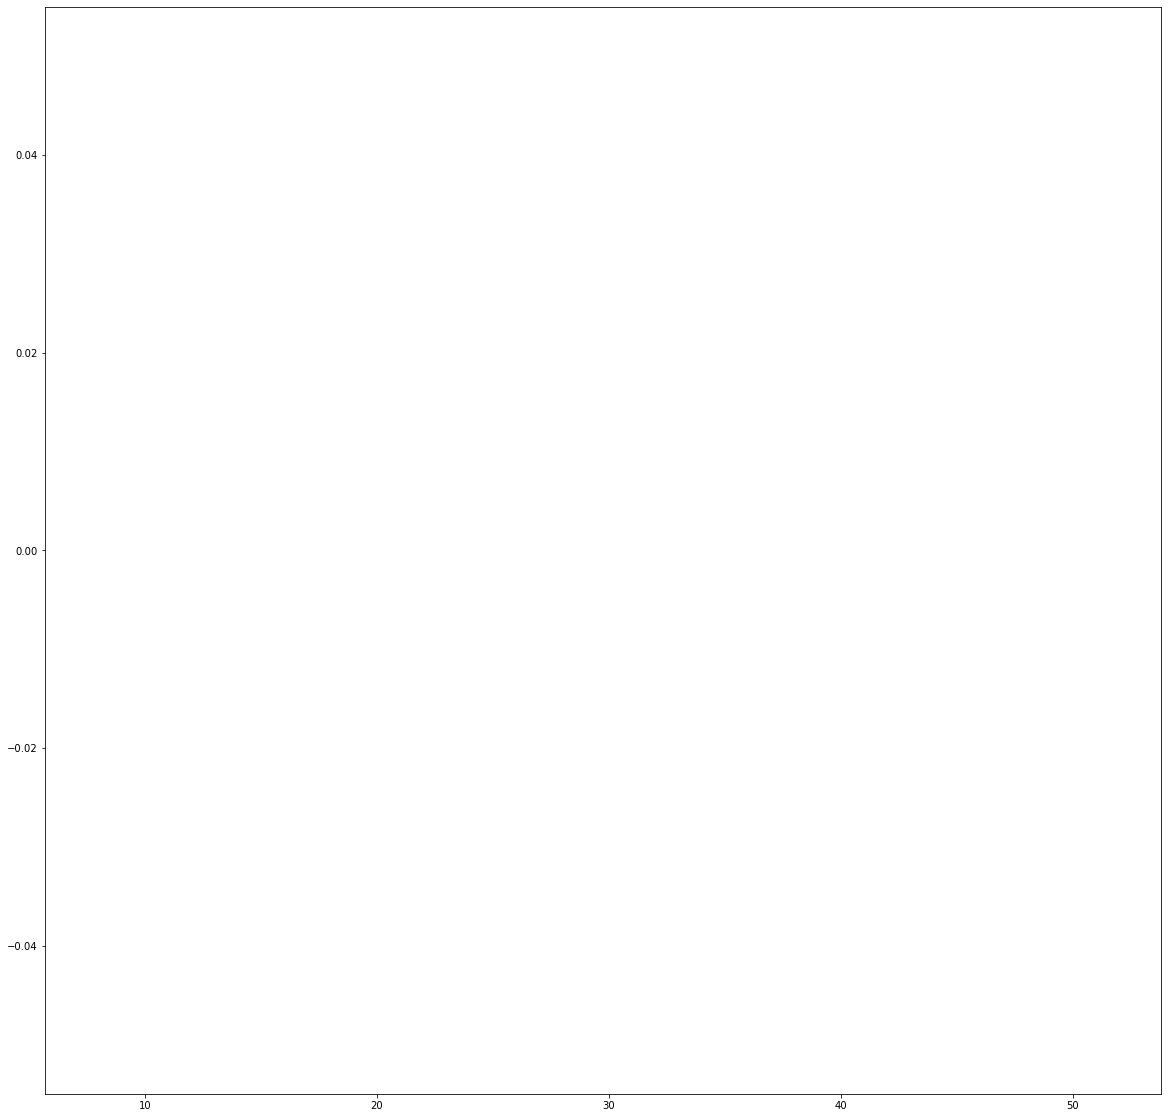

In [174]:
ax = pyplt.plot(Final_prediction, range(len(Final_prediction)))
pyplt.show()

# 5. References

[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].

[13] Brownlee, J. (2019). An Introduction to Feature Selection. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/an-introduction-to-feature-selection/ [Accessed 4 Dec. 2019].

[14] Chandrayan, P. (2019). Hypothesis Testing Using T Test : Inferential Statistics Part3. [online] Medium. Available at: https://towardsdatascience.com/hypothesis-testing-using-t-test-inferential-statistics-part3-6fb43683bc32 [Accessed 12 Dec. 2019].

[15] Brownlee, J. (2019). A Gentle Introduction to Normality Tests in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ [Accessed 30 Oct. 2019].